In [1]:
# 다른 경로에 있는 모듈을 가져오기 위해 절대 경로 추가

import os
import sys

root = os.path.join(os.path.abspath(os.getcwd()), '..', '..')
root = os.path.normpath(root)

if root not in sys.path:
    sys.path.insert(0, root)

In [2]:
# 필요한 라이브러리 로드

import emoji
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import torch
from communav.utils import db
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from soynlp.normalizer import repeat_normalize
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup

/tmp/ipykernel_1966/1026082369.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/retn0/repositories/nbsp1221/communav/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 카테고리 정의

CATEGORIES = {
    0: '자유',
    1: '학사',
    2: '장학 · 행정',
    3: '학교생활',
    4: '수업',
    5: '수업/이과',
    6: '수업/문과',
    7: '캠퍼스',
    8: '취업 · 진로',
    9: '일상생활',
    10: '음식점 · 카페',
    11: '취미 · 여가',
    12: '인간관계',
    13: '병역'
}

In [4]:
# 파라미터 설정

TABLE_NAME = 'everytime_article_dataset_v1'
MODEL_ID = 'beomi/KcELECTRA-base-v2022'
TOKENIZER_ID = './custom-tokenizer'
NUM_LABELS = len(CATEGORIES)
MAX_LENGTH = 128
F_BETA = 0.5
METRIC_AVERAGE = 'weighted'
METRIC_ZERO_DIVISION = 0
BATCH_SIZE = 32
ITERATION = 20
EPOCHS = 40
LEARNING_RATE = 2e-5
SAVE_PATH = '.'

In [5]:
# 커뮤니티 게시글 데이터 로드

connection = db.get_connection()
cursor = connection.cursor()

cursor.execute(f'''
    SELECT id, title, text, category_id
    FROM {TABLE_NAME}
    WHERE category_id IS NOT NULL
''')
original_articles = cursor.fetchall()
print(f'Loaded {len(original_articles)} articles.')

cursor.close()
db.close_connection()

Connected to DB successfully.
Loaded 4094 articles.


In [6]:
# 가져온 데이터의 일부를 출력

for article in original_articles[:20]:
    print(article)

{'id': 1, 'title': '어제 비마관 화장실에서 핸드폰 찾아주신분!', 'text': '제가 경황이 없어서 감사하다고도 못 했네요.\n정말 감사합니다!!!', 'category_id': 9}
{'id': 3, 'title': '조은문화사 몇시에 보통 열리나요??', 'text': '1교시 수업 책 찾아야되서', 'category_id': 7}
{'id': 4, 'title': '전공수업듣는데', 'text': '복학한거처럼 보이는 형이 열심히는 하시던데 뭔가 군대갔다고오고 모든걸 까먹은 자기를 자책하듯이 수업듣는걸 보고 나도 3년후에 저러겠구나 싶더라... ㅠㅠ', 'category_id': 4}
{'id': 5, 'title': '정문에 있는 인쇄집들 몇시까지 하는지 아시나요?', 'text': '9시 넘어야 갈수있을거 같은데\n열어 있을지..', 'category_id': 7}
{'id': 8, 'title': '문화유목시대 교재뭔가요', 'text': '정정기간때 신청해서 잘 모르겠어요. ㅠㅠ 계획서보니까 고른다고하는데 뭐에요?', 'category_id': 6}
{'id': 13, 'title': '전자회로실험 파형이 물결처럼 나와야하는데 왜 난 일자로 나오지???;;', 'text': '이번에 복학해서 실험들으려는데 그냥 예비는 똑같이 따라하면 되는거 아닌가?\n왜 일자로만 나와....', 'category_id': 5}
{'id': 14, 'title': '전자회로실험 파형이 물결처럼 나와야하는데 왜 난 일자로 나오지???;;', 'text': '이번에 복학해서 실험들으려는데 그냥 예비는 똑같이 따라하면 되는거 아닌가?\n왜 일자로만 나와....\n이건 회로인데 뭐가 잘못된거지요????;;', 'category_id': 5}
{'id': 17, 'title': '컴퓨터구조 책삽니다', 'text': '표지에 컴퓨터구조 및 설계 써있고 5판 한글판 중고 2만원에삽니다\nPatterson , Hennessy 저자 입니다', 'category_

In [7]:
# 데이터 전처리 함수 정의

normal_pattern = re.compile(r'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣]+')
url_pattern = re.compile(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

def preprocess(value):
    value = normal_pattern.sub(' ', value)
    value = emoji.replace_emoji(value, replace='')
    value = url_pattern.sub('', value)
    value = repeat_normalize(value, num_repeats=2)
    value = value.strip()
    return value

In [8]:
# 데이터 전처리

preprocessed_articles = []

for article in tqdm(original_articles):
    title = article['title']
    text = article['text']
    content = (title + ' ' + text).replace('\n', ' ')

    preprocessed_articles.append({
        'content': preprocess(content),
        'label': article['category_id']
    })

100%|██████████| 4094/4094 [00:00<00:00, 19052.45it/s]


In [9]:
# 전처리된 데이터의 일부를 출력

for article in preprocessed_articles[:20]:
    print(article)

{'content': '어제 비마관 화장실에서 핸드폰 찾아주신분! 제가 경황이 없어서 감사하다고도 못 했네요. 정말 감사합니다!!!', 'label': 9}
{'content': '조은문화사 몇시에 보통 열리나요?? 1교시 수업 책 찾아야되서', 'label': 7}
{'content': '전공수업듣는데 복학한거처럼 보이는 형이 열심히는 하시던데 뭔가 군대갔다고오고 모든걸 까먹은 자기를 자책하듯이 수업듣는걸 보고 나도 3년후에 저러겠구나 싶더라... ㅠㅠ', 'label': 4}
{'content': '정문에 있는 인쇄집들 몇시까지 하는지 아시나요? 9시 넘어야 갈수있을거 같은데 열어 있을지..', 'label': 7}
{'content': '문화유목시대 교재뭔가요 정정기간때 신청해서 잘 모르겠어요. ㅠㅠ 계획서보니까 고른다고하는데 뭐에요?', 'label': 6}
{'content': '전자회로실험 파형이 물결처럼 나와야하는데 왜 난 일자로 나오지???;; 이번에 복학해서 실험들으려는데 그냥 예비는 똑같이 따라하면 되는거 아닌가? 왜 일자로만 나와....', 'label': 5}
{'content': '전자회로실험 파형이 물결처럼 나와야하는데 왜 난 일자로 나오지???;; 이번에 복학해서 실험들으려는데 그냥 예비는 똑같이 따라하면 되는거 아닌가? 왜 일자로만 나와.... 이건 회로인데 뭐가 잘못된거지요????;;', 'label': 5}
{'content': '컴퓨터구조 책삽니다 표지에 컴퓨터구조 및 설계 써있고 5판 한글판 중고 2만원에삽니다 Patterson , Hennessy 저자 입니다', 'label': 5}
{'content': '오늘 영화의 이해 수업 영화의 이해 유양근 교수님 수업을 못가서 그런데 혹시 교재같은거나 해오라고 하신거 있나요?! ㅜㅜ', 'label': 6}
{'content': '초급일본어 전유나 초급일본어 책필요한가요?', 'label': 6}
{'content': '졸업학점있잖아 교양 30 전공 60 선택50 이면 무조건 저거

In [10]:
# 데이터 분포 확인 함수 정의

def plot_distribution(articles):
    label_counts = {category_id: 0 for category_id in CATEGORIES}
    for article in articles:
        label_counts[article['label']] += 1

    total_count = sum(label_counts.values())
    percentages = {category_id: count / total_count * 100 for category_id, count in label_counts.items()}
    for category_id, percentage in percentages.items():
        print(f'{CATEGORIES[category_id]} [{category_id}]: {percentage:.2f}%')

    plt.figure(figsize=(12, 8))
    plt.bar(CATEGORIES.keys(), label_counts.values())
    for i, count in enumerate(label_counts.values()):
        plt.text(i, count + 0.1, str(count), ha='center')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title('Distribution of Categories')
    plt.xticks(range(len(CATEGORIES)), list(CATEGORIES.keys()))
    plt.tight_layout()
    plt.show()

자유 [0]: 9.55%
학사 [1]: 6.64%
장학 · 행정 [2]: 21.81%
학교생활 [3]: 7.65%
수업 [4]: 4.20%
수업/이과 [5]: 10.50%
수업/문과 [6]: 6.72%
캠퍼스 [7]: 7.01%
취업 · 진로 [8]: 3.57%
일상생활 [9]: 6.79%
음식점 · 카페 [10]: 4.91%
취미 · 여가 [11]: 4.30%
인간관계 [12]: 2.56%
병역 [13]: 3.79%


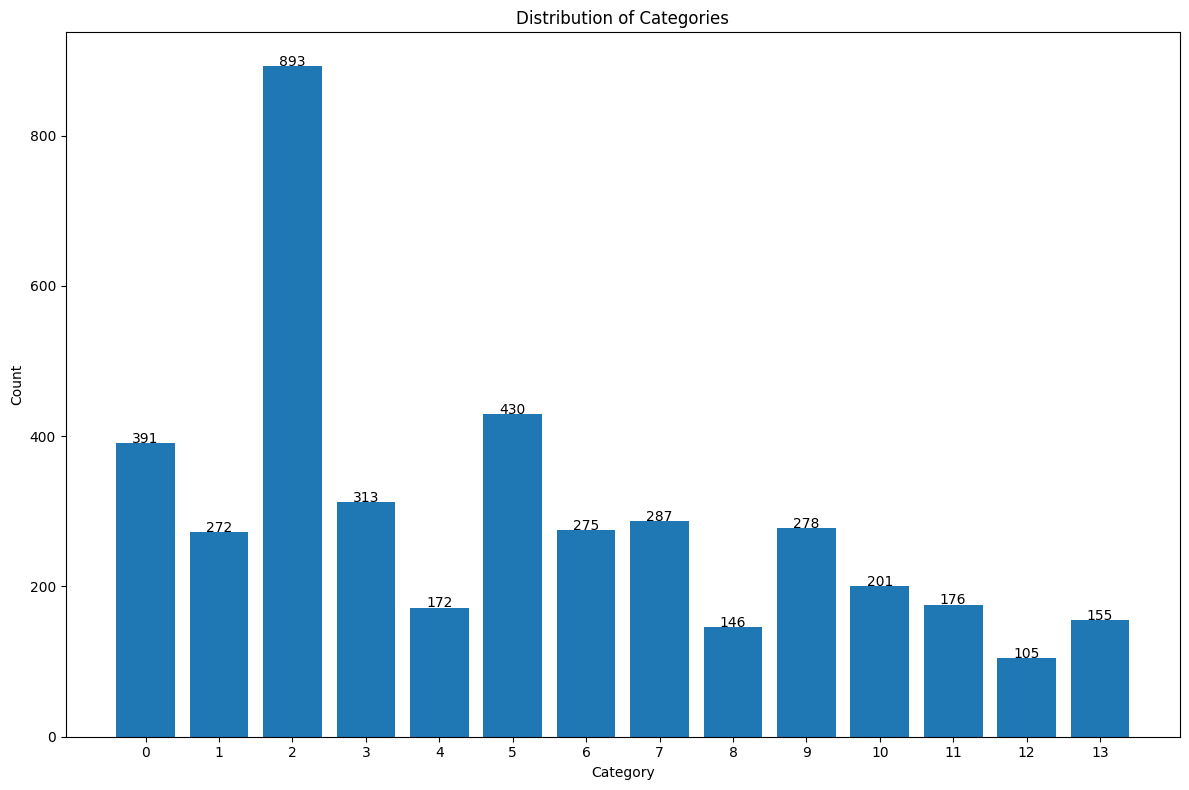

In [11]:
# 데이터 분포 확인

plot_distribution(preprocessed_articles)

In [12]:
# 훈련 데이터와 검증 데이터로 분리

train_articles, val_articles = train_test_split(
    preprocessed_articles,
    test_size=0.2,
    random_state=42
)

print(f'Number of training articles: {len(train_articles)}')
print(f'Number of validation articles: {len(val_articles)}')

Number of training articles: 3275
Number of validation articles: 819


자유 [0]: 9.74%
학사 [1]: 6.81%
장학 · 행정 [2]: 21.71%
학교생활 [3]: 7.82%
수업 [4]: 4.37%
수업/이과 [5]: 10.23%
수업/문과 [6]: 7.42%
캠퍼스 [7]: 7.08%
취업 · 진로 [8]: 3.54%
일상생활 [9]: 6.29%
음식점 · 카페 [10]: 4.70%
취미 · 여가 [11]: 3.85%
인간관계 [12]: 2.56%
병역 [13]: 3.88%


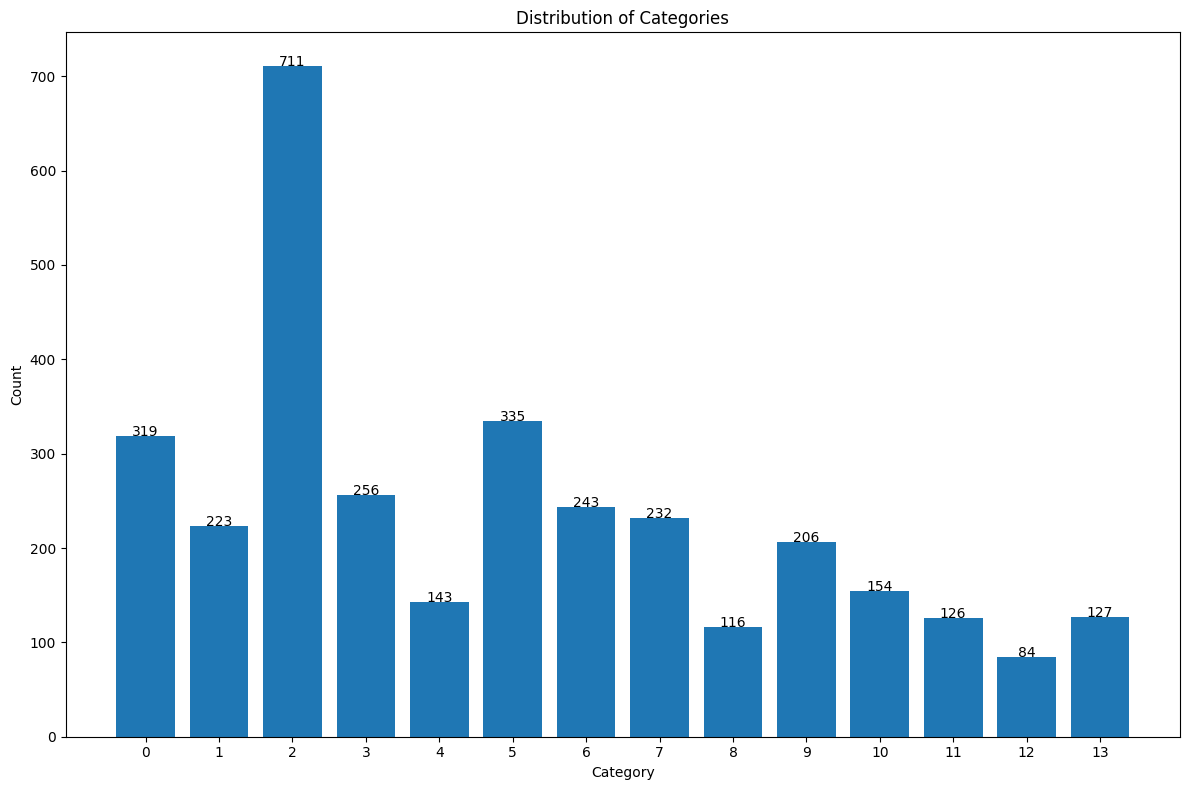

In [13]:
# 훈련 데이터의 데이터 분포 확인

plot_distribution(train_articles)

자유 [0]: 8.79%
학사 [1]: 5.98%
장학 · 행정 [2]: 22.22%
학교생활 [3]: 6.96%
수업 [4]: 3.54%
수업/이과 [5]: 11.60%
수업/문과 [6]: 3.91%
캠퍼스 [7]: 6.72%
취업 · 진로 [8]: 3.66%
일상생활 [9]: 8.79%
음식점 · 카페 [10]: 5.74%
취미 · 여가 [11]: 6.11%
인간관계 [12]: 2.56%
병역 [13]: 3.42%


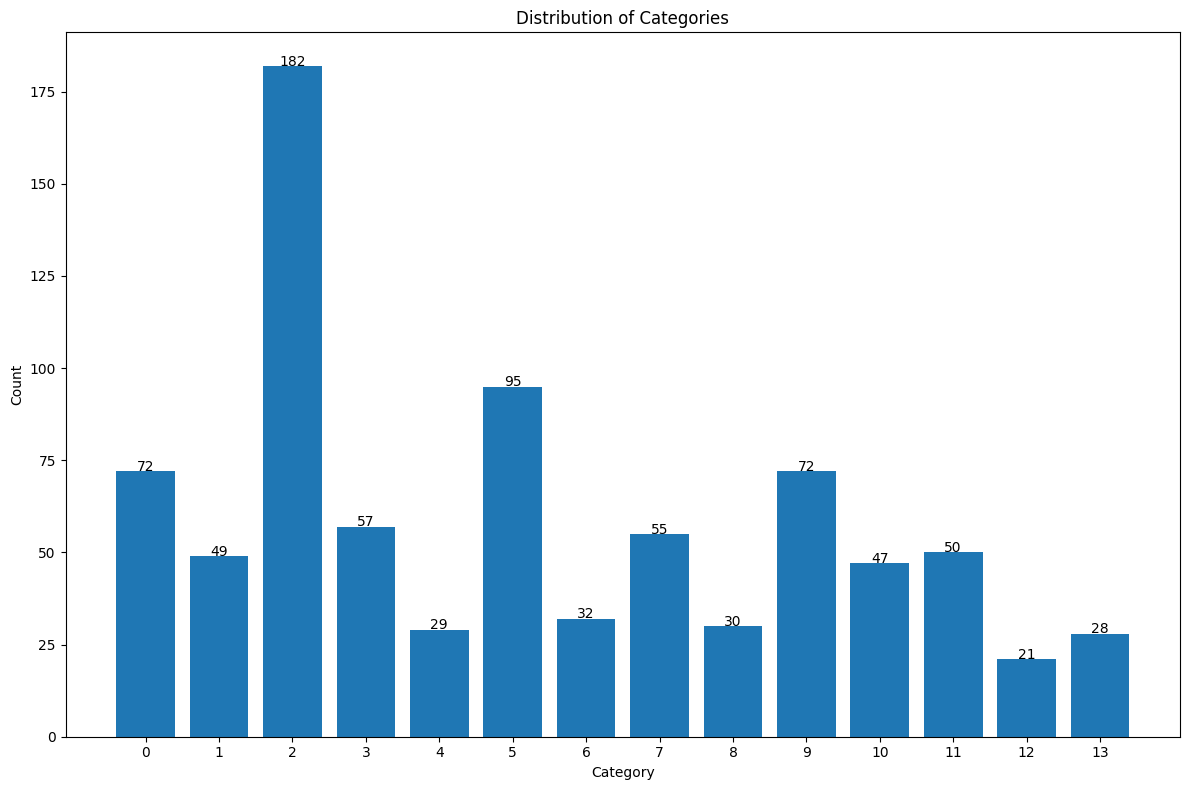

In [14]:
# 검증 데이터의 데이터 분포 확인

plot_distribution(val_articles)

In [15]:
# 토크나이저 로드

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_ID, do_basic_tokenize=False)

print('Original:', preprocessed_articles[0]['content'])
print('Tokenized:', tokenizer.tokenize(preprocessed_articles[0]['content']))

Original: 어제 비마관 화장실에서 핸드폰 찾아주신분! 제가 경황이 없어서 감사하다고도 못 했네요. 정말 감사합니다!!!
Tokenized: ['어제', '비', '##마', '##관', '화장실', '##에서', '핸드폰', '찾아', '##주신', '##분', '!', '제가', '경', '##황', '##이', '없어서', '감사', '##하다고', '##도', '못', '했네요', '.', '정말', '감사합니다', '!', '!', '!']


In [16]:
# 텍스트 인코딩 및 데이터셋 생성

train_contents = [article['content'] for article in train_articles]
train_labels = [article['label'] for article in train_articles]
val_contents = [article['content'] for article in val_articles]
val_labels = [article['label'] for article in val_articles]

train_encodings = tokenizer(
    train_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)
val_encodings = tokenizer(
    val_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)

train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels)
)
val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels)
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

/tmp/ipykernel_1966/2848816050.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['input_ids']),
/tmp/ipykernel_1966/2848816050.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['attention_mask']),
/tmp/ipykernel_1966/2848816050.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_encodings['input_ids']),
/tmp/ipykernel_1966/2848816050.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.cl

In [17]:
# 학습 전 초기화

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3060 Ti


In [18]:
# 평가 지표 계산 함수 정의

def calculate_metrics(true_labels, predicted_labels):
    acc = accuracy_score(true_labels, predicted_labels)
    prec = precision_score(true_labels, predicted_labels, average=METRIC_AVERAGE, zero_division=METRIC_ZERO_DIVISION)
    rec = recall_score(true_labels, predicted_labels, average=METRIC_AVERAGE, zero_division=METRIC_ZERO_DIVISION)
    f_beta = fbeta_score(true_labels, predicted_labels, beta=F_BETA, average=METRIC_AVERAGE, zero_division=METRIC_ZERO_DIVISION)

    return acc, prec, rec, f_beta

In [19]:
# 학습 시작

best_val_f_beta = 0.95
best_model_path = None

for iteration in range(ITERATION):
    print(f'Iteration {iteration + 1}/{ITERATION}')

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=NUM_LABELS)
    model.to(device)
    model.resize_token_embeddings(len(tokenizer))

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_dataset) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    better_val_f_beta = 0.95
    better_model_path = None

    for epoch in range(EPOCHS):
        model.train()

        train_loss = 0.0
        train_predictions = []
        train_labels_epoch = []

        for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1} - Training'):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            train_predictions.extend(predictions.tolist())
            train_labels_epoch.extend(labels.tolist())

        train_acc, train_prec, train_rec, train_f_beta = calculate_metrics(train_labels_epoch, train_predictions)
        train_loss /= len(train_dataloader)

        model.eval()

        val_loss = 0.0
        val_predictions = []

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f'Epoch {epoch + 1} - Validation'):
                input_ids = batch[0].to(device)
                attention_mask = batch[1].to(device)
                labels = batch[2].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=1)

                val_predictions.extend(predictions.tolist())

        val_acc, val_prec, val_rec, val_f_beta = calculate_metrics(val_labels, val_predictions)
        val_loss /= len(val_dataloader)

        print(f'Iteration {iteration + 1} - Epoch {epoch + 1}:')
        print(f'  Train Acc = {train_acc:.4f}, Train Prec = {train_prec:.4f}, Train Rec = {train_rec:.4f}, Train F-Beta = {train_f_beta:.4f}, Train Loss = {train_loss:.4f}')
        print(f'  Val Acc = {val_acc:.4f}, Val Prec = {val_prec:.4f}, Val Rec = {val_rec:.4f}, Val F-Beta = {val_f_beta:.4f}, Val Loss = {val_loss:.4f}')

        if val_f_beta > better_val_f_beta:
            better_val_f_beta = val_f_beta
            better_model_path = os.path.join(SAVE_PATH, f'model-iteration-{iteration + 1:02d}-epoch-{epoch + 1:02d}-{better_val_f_beta:.4f}')
            model.save_pretrained(better_model_path)
            tokenizer.save_pretrained(better_model_path)
            print(f'  Better model saved with {better_val_f_beta:.4f} F-beta score.')

    if better_val_f_beta > best_val_f_beta:
        best_val_f_beta = better_val_f_beta
        best_model_path = better_model_path

print('Training finished.')

Iteration 1/20


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.31it/s]


Iteration 1 - Epoch 1:
  Train Acc = 0.2882, Train Prec = 0.2310, Train Rec = 0.2882, Train F-Beta = 0.1607, Train Loss = 2.3145
  Val Acc = 0.4786, Val Prec = 0.3515, Val Rec = 0.4786, Val F-Beta = 0.3302, Val Loss = 1.8097


Epoch 2 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.24it/s]


Iteration 1 - Epoch 2:
  Train Acc = 0.6217, Train Prec = 0.6592, Train Rec = 0.6217, Train F-Beta = 0.5620, Train Loss = 1.3826
  Val Acc = 0.7473, Val Prec = 0.7795, Val Rec = 0.7473, Val F-Beta = 0.7021, Val Loss = 0.9373


Epoch 3 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 1 - Epoch 3:
  Train Acc = 0.8684, Train Prec = 0.8801, Train Rec = 0.8684, Train F-Beta = 0.8696, Train Loss = 0.6866
  Val Acc = 0.9170, Val Prec = 0.9224, Val Rec = 0.9170, Val F-Beta = 0.9181, Val Loss = 0.4645


Epoch 4 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 1 - Epoch 4:
  Train Acc = 0.9603, Train Prec = 0.9605, Train Rec = 0.9603, Train F-Beta = 0.9604, Train Loss = 0.3038
  Val Acc = 0.9353, Val Prec = 0.9379, Val Rec = 0.9353, Val F-Beta = 0.9364, Val Loss = 0.3063


Epoch 5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 1 - Epoch 5:
  Train Acc = 0.9823, Train Prec = 0.9824, Train Rec = 0.9823, Train F-Beta = 0.9823, Train Loss = 0.1464
  Val Acc = 0.9414, Val Prec = 0.9447, Val Rec = 0.9414, Val F-Beta = 0.9431, Val Loss = 0.2670


Epoch 6 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 1 - Epoch 6:
  Train Acc = 0.9893, Train Prec = 0.9893, Train Rec = 0.9893, Train F-Beta = 0.9893, Train Loss = 0.0838
  Val Acc = 0.9487, Val Prec = 0.9500, Val Rec = 0.9487, Val F-Beta = 0.9492, Val Loss = 0.2510


Epoch 7 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 1 - Epoch 7:
  Train Acc = 0.9936, Train Prec = 0.9936, Train Rec = 0.9936, Train F-Beta = 0.9936, Train Loss = 0.0525
  Val Acc = 0.9426, Val Prec = 0.9475, Val Rec = 0.9426, Val F-Beta = 0.9452, Val Loss = 0.2779


Epoch 8 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 1 - Epoch 8:
  Train Acc = 0.9945, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0403
  Val Acc = 0.9499, Val Prec = 0.9507, Val Rec = 0.9499, Val F-Beta = 0.9501, Val Loss = 0.2342
  Better model saved with 0.9501 F-beta score.


Epoch 9 - Validation: 100%|██████████| 26/26 [00:02<00:00,  9.75it/s]


Iteration 1 - Epoch 9:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0247
  Val Acc = 0.9499, Val Prec = 0.9504, Val Rec = 0.9499, Val F-Beta = 0.9499, Val Loss = 0.2482


Epoch 10 - Validation: 100%|██████████| 26/26 [00:02<00:00,  9.89it/s]


Iteration 1 - Epoch 10:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0165
  Val Acc = 0.9499, Val Prec = 0.9512, Val Rec = 0.9499, Val F-Beta = 0.9504, Val Loss = 0.2589
  Better model saved with 0.9504 F-beta score.


Epoch 11 - Validation: 100%|██████████| 26/26 [00:02<00:00,  9.78it/s]


Iteration 1 - Epoch 11:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0137
  Val Acc = 0.9463, Val Prec = 0.9472, Val Rec = 0.9463, Val F-Beta = 0.9467, Val Loss = 0.2628


Epoch 12 - Validation: 100%|██████████| 26/26 [00:02<00:00,  9.79it/s]


Iteration 1 - Epoch 12:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0171
  Val Acc = 0.9463, Val Prec = 0.9471, Val Rec = 0.9463, Val F-Beta = 0.9466, Val Loss = 0.2638


Epoch 13 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.21it/s]


Iteration 1 - Epoch 13:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F-Beta = 0.9942, Train Loss = 0.0270
  Val Acc = 0.9389, Val Prec = 0.9454, Val Rec = 0.9389, Val F-Beta = 0.9417, Val Loss = 0.3038


Epoch 14 - Validation: 100%|██████████| 26/26 [00:02<00:00,  9.73it/s]


Iteration 1 - Epoch 14:
  Train Acc = 0.7850, Train Prec = 0.8066, Train Rec = 0.7850, Train F-Beta = 0.7969, Train Loss = 0.7147
  Val Acc = 0.8669, Val Prec = 0.8791, Val Rec = 0.8669, Val F-Beta = 0.8723, Val Loss = 0.4913


Epoch 15 - Validation: 100%|██████████| 26/26 [00:02<00:00,  9.84it/s]


Iteration 1 - Epoch 15:
  Train Acc = 0.9820, Train Prec = 0.9820, Train Rec = 0.9820, Train F-Beta = 0.9820, Train Loss = 0.0710
  Val Acc = 0.9475, Val Prec = 0.9502, Val Rec = 0.9475, Val F-Beta = 0.9489, Val Loss = 0.2602


Epoch 16 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.12it/s]


Iteration 1 - Epoch 16:
  Train Acc = 0.9966, Train Prec = 0.9967, Train Rec = 0.9966, Train F-Beta = 0.9966, Train Loss = 0.0181
  Val Acc = 0.9585, Val Prec = 0.9589, Val Rec = 0.9585, Val F-Beta = 0.9585, Val Loss = 0.2438
  Better model saved with 0.9585 F-beta score.


Epoch 17 - Validation: 100%|██████████| 26/26 [00:02<00:00,  9.74it/s]


Iteration 1 - Epoch 17:
  Train Acc = 0.9963, Train Prec = 0.9964, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0177
  Val Acc = 0.9524, Val Prec = 0.9541, Val Rec = 0.9524, Val F-Beta = 0.9530, Val Loss = 0.2799


Epoch 18 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.13it/s]


Iteration 1 - Epoch 18:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0088
  Val Acc = 0.9438, Val Prec = 0.9448, Val Rec = 0.9438, Val F-Beta = 0.9440, Val Loss = 0.2948


Epoch 19 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 1 - Epoch 19:
  Train Acc = 0.9969, Train Prec = 0.9969, Train Rec = 0.9969, Train F-Beta = 0.9969, Train Loss = 0.0149
  Val Acc = 0.9389, Val Prec = 0.9398, Val Rec = 0.9389, Val F-Beta = 0.9391, Val Loss = 0.3239


Epoch 20 - Validation: 100%|██████████| 26/26 [00:02<00:00,  9.86it/s]


Iteration 1 - Epoch 20:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0129
  Val Acc = 0.9463, Val Prec = 0.9469, Val Rec = 0.9463, Val F-Beta = 0.9462, Val Loss = 0.2945


Epoch 21 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 1 - Epoch 21:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F-Beta = 0.9942, Train Loss = 0.0218
  Val Acc = 0.9389, Val Prec = 0.9416, Val Rec = 0.9389, Val F-Beta = 0.9399, Val Loss = 0.3411


Epoch 22 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 1 - Epoch 22:
  Train Acc = 0.9957, Train Prec = 0.9957, Train Rec = 0.9957, Train F-Beta = 0.9957, Train Loss = 0.0166
  Val Acc = 0.9377, Val Prec = 0.9424, Val Rec = 0.9377, Val F-Beta = 0.9395, Val Loss = 0.3440


Epoch 23 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 1 - Epoch 23:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0077
  Val Acc = 0.9499, Val Prec = 0.9512, Val Rec = 0.9499, Val F-Beta = 0.9505, Val Loss = 0.2900


Epoch 24 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 1 - Epoch 24:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0052
  Val Acc = 0.9475, Val Prec = 0.9483, Val Rec = 0.9475, Val F-Beta = 0.9479, Val Loss = 0.2888


Epoch 25 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 1 - Epoch 25:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0027
  Val Acc = 0.9463, Val Prec = 0.9478, Val Rec = 0.9463, Val F-Beta = 0.9469, Val Loss = 0.3160


Epoch 26 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 1 - Epoch 26:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0053
  Val Acc = 0.9377, Val Prec = 0.9419, Val Rec = 0.9377, Val F-Beta = 0.9398, Val Loss = 0.3413


Epoch 27 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 1 - Epoch 27:
  Train Acc = 0.9960, Train Prec = 0.9961, Train Rec = 0.9960, Train F-Beta = 0.9960, Train Loss = 0.0211
  Val Acc = 0.9475, Val Prec = 0.9485, Val Rec = 0.9475, Val F-Beta = 0.9479, Val Loss = 0.3154


Epoch 28 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 1 - Epoch 28:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0086
  Val Acc = 0.9438, Val Prec = 0.9457, Val Rec = 0.9438, Val F-Beta = 0.9443, Val Loss = 0.3441


Epoch 29 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 1 - Epoch 29:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0100
  Val Acc = 0.9499, Val Prec = 0.9512, Val Rec = 0.9499, Val F-Beta = 0.9504, Val Loss = 0.2946


Epoch 30 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 1 - Epoch 30:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0121
  Val Acc = 0.9402, Val Prec = 0.9435, Val Rec = 0.9402, Val F-Beta = 0.9419, Val Loss = 0.3383


Epoch 31 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 1 - Epoch 31:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0055
  Val Acc = 0.9499, Val Prec = 0.9514, Val Rec = 0.9499, Val F-Beta = 0.9505, Val Loss = 0.3102


Epoch 32 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 1 - Epoch 32:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0079
  Val Acc = 0.9463, Val Prec = 0.9481, Val Rec = 0.9463, Val F-Beta = 0.9471, Val Loss = 0.3326


Epoch 33 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 1 - Epoch 33:
  Train Acc = 0.9969, Train Prec = 0.9970, Train Rec = 0.9969, Train F-Beta = 0.9969, Train Loss = 0.0128
  Val Acc = 0.9536, Val Prec = 0.9554, Val Rec = 0.9536, Val F-Beta = 0.9545, Val Loss = 0.3008


Epoch 34 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 1 - Epoch 34:
  Train Acc = 0.9969, Train Prec = 0.9969, Train Rec = 0.9969, Train F-Beta = 0.9969, Train Loss = 0.0155
  Val Acc = 0.9463, Val Prec = 0.9481, Val Rec = 0.9463, Val F-Beta = 0.9469, Val Loss = 0.3806


Epoch 35 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 1 - Epoch 35:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0023
  Val Acc = 0.9451, Val Prec = 0.9477, Val Rec = 0.9451, Val F-Beta = 0.9461, Val Loss = 0.3398


Epoch 36 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 1 - Epoch 36:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0077
  Val Acc = 0.9389, Val Prec = 0.9409, Val Rec = 0.9389, Val F-Beta = 0.9391, Val Loss = 0.3821


Epoch 37 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 1 - Epoch 37:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0075
  Val Acc = 0.9475, Val Prec = 0.9509, Val Rec = 0.9475, Val F-Beta = 0.9490, Val Loss = 0.3694


Epoch 38 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 1 - Epoch 38:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0122
  Val Acc = 0.9487, Val Prec = 0.9505, Val Rec = 0.9487, Val F-Beta = 0.9494, Val Loss = 0.3502


Epoch 39 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 1 - Epoch 39:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0184
  Val Acc = 0.9451, Val Prec = 0.9478, Val Rec = 0.9451, Val F-Beta = 0.9460, Val Loss = 0.3388


Epoch 40 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 1 - Epoch 40:
  Train Acc = 0.9948, Train Prec = 0.9948, Train Rec = 0.9948, Train F-Beta = 0.9948, Train Loss = 0.0179
  Val Acc = 0.9353, Val Prec = 0.9399, Val Rec = 0.9353, Val F-Beta = 0.9377, Val Loss = 0.3699
Iteration 2/20


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 2 - Epoch 1:
  Train Acc = 0.2882, Train Prec = 0.1605, Train Rec = 0.2882, Train F-Beta = 0.1562, Train Loss = 2.2871
  Val Acc = 0.4701, Val Prec = 0.3759, Val Rec = 0.4701, Val F-Beta = 0.3381, Val Loss = 1.7693


Epoch 2 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 2:
  Train Acc = 0.5936, Train Prec = 0.6500, Train Rec = 0.5936, Train F-Beta = 0.5040, Train Loss = 1.3879
  Val Acc = 0.7045, Val Prec = 0.6870, Val Rec = 0.7045, Val F-Beta = 0.6262, Val Loss = 1.0216


Epoch 3 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 3:
  Train Acc = 0.8198, Train Prec = 0.8599, Train Rec = 0.8198, Train F-Beta = 0.8131, Train Loss = 0.7587
  Val Acc = 0.8987, Val Prec = 0.9033, Val Rec = 0.8987, Val F-Beta = 0.8997, Val Loss = 0.5446


Epoch 4 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 4:
  Train Acc = 0.9533, Train Prec = 0.9538, Train Rec = 0.9533, Train F-Beta = 0.9533, Train Loss = 0.3501
  Val Acc = 0.9304, Val Prec = 0.9317, Val Rec = 0.9304, Val F-Beta = 0.9311, Val Loss = 0.3128


Epoch 5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 2 - Epoch 5:
  Train Acc = 0.9829, Train Prec = 0.9830, Train Rec = 0.9829, Train F-Beta = 0.9829, Train Loss = 0.1594
  Val Acc = 0.9402, Val Prec = 0.9422, Val Rec = 0.9402, Val F-Beta = 0.9412, Val Loss = 0.2661


Epoch 6 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 6:
  Train Acc = 0.9866, Train Prec = 0.9866, Train Rec = 0.9866, Train F-Beta = 0.9866, Train Loss = 0.1032
  Val Acc = 0.9426, Val Prec = 0.9446, Val Rec = 0.9426, Val F-Beta = 0.9435, Val Loss = 0.2584


Epoch 7 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 7:
  Train Acc = 0.9924, Train Prec = 0.9924, Train Rec = 0.9924, Train F-Beta = 0.9924, Train Loss = 0.0627
  Val Acc = 0.9426, Val Prec = 0.9445, Val Rec = 0.9426, Val F-Beta = 0.9435, Val Loss = 0.2555


Epoch 8 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 8:
  Train Acc = 0.9951, Train Prec = 0.9951, Train Rec = 0.9951, Train F-Beta = 0.9951, Train Loss = 0.0434
  Val Acc = 0.9414, Val Prec = 0.9439, Val Rec = 0.9414, Val F-Beta = 0.9426, Val Loss = 0.2562


Epoch 9 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 9:
  Train Acc = 0.9896, Train Prec = 0.9896, Train Rec = 0.9896, Train F-Beta = 0.9896, Train Loss = 0.0534
  Val Acc = 0.9292, Val Prec = 0.9332, Val Rec = 0.9292, Val F-Beta = 0.9312, Val Loss = 0.3003


Epoch 10 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 2 - Epoch 10:
  Train Acc = 0.9911, Train Prec = 0.9912, Train Rec = 0.9911, Train F-Beta = 0.9912, Train Loss = 0.0434
  Val Acc = 0.9414, Val Prec = 0.9433, Val Rec = 0.9414, Val F-Beta = 0.9424, Val Loss = 0.2781


Epoch 11 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 11:
  Train Acc = 0.9933, Train Prec = 0.9933, Train Rec = 0.9933, Train F-Beta = 0.9933, Train Loss = 0.0334
  Val Acc = 0.9463, Val Prec = 0.9492, Val Rec = 0.9463, Val F-Beta = 0.9475, Val Loss = 0.3106


Epoch 12 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 2 - Epoch 12:
  Train Acc = 0.9924, Train Prec = 0.9924, Train Rec = 0.9924, Train F-Beta = 0.9924, Train Loss = 0.0362
  Val Acc = 0.9304, Val Prec = 0.9367, Val Rec = 0.9304, Val F-Beta = 0.9335, Val Loss = 0.3681


Epoch 13 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 2 - Epoch 13:
  Train Acc = 0.9933, Train Prec = 0.9933, Train Rec = 0.9933, Train F-Beta = 0.9933, Train Loss = 0.0334
  Val Acc = 0.9536, Val Prec = 0.9558, Val Rec = 0.9536, Val F-Beta = 0.9546, Val Loss = 0.2519
  Better model saved with 0.9546 F-beta score.


Epoch 14 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 14:
  Train Acc = 0.9969, Train Prec = 0.9969, Train Rec = 0.9969, Train F-Beta = 0.9969, Train Loss = 0.0208
  Val Acc = 0.9548, Val Prec = 0.9572, Val Rec = 0.9548, Val F-Beta = 0.9561, Val Loss = 0.2313
  Better model saved with 0.9561 F-beta score.


Epoch 15 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 2 - Epoch 15:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0142
  Val Acc = 0.9487, Val Prec = 0.9525, Val Rec = 0.9487, Val F-Beta = 0.9507, Val Loss = 0.2966


Epoch 16 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 16:
  Train Acc = 0.9948, Train Prec = 0.9948, Train Rec = 0.9948, Train F-Beta = 0.9948, Train Loss = 0.0246
  Val Acc = 0.9487, Val Prec = 0.9494, Val Rec = 0.9487, Val F-Beta = 0.9489, Val Loss = 0.2791


Epoch 17 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 17:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0201
  Val Acc = 0.9536, Val Prec = 0.9543, Val Rec = 0.9536, Val F-Beta = 0.9537, Val Loss = 0.2616


Epoch 18 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 2 - Epoch 18:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0051
  Val Acc = 0.9524, Val Prec = 0.9533, Val Rec = 0.9524, Val F-Beta = 0.9528, Val Loss = 0.2736


Epoch 19 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 2 - Epoch 19:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0088
  Val Acc = 0.9438, Val Prec = 0.9462, Val Rec = 0.9438, Val F-Beta = 0.9448, Val Loss = 0.3487


Epoch 20 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 20:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0179
  Val Acc = 0.9487, Val Prec = 0.9497, Val Rec = 0.9487, Val F-Beta = 0.9491, Val Loss = 0.3011


Epoch 21 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 2 - Epoch 21:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0133
  Val Acc = 0.9512, Val Prec = 0.9527, Val Rec = 0.9512, Val F-Beta = 0.9518, Val Loss = 0.3208


Epoch 22 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 2 - Epoch 22:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0079
  Val Acc = 0.9475, Val Prec = 0.9503, Val Rec = 0.9475, Val F-Beta = 0.9486, Val Loss = 0.3241


Epoch 23 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 23:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0076
  Val Acc = 0.9536, Val Prec = 0.9550, Val Rec = 0.9536, Val F-Beta = 0.9541, Val Loss = 0.2735


Epoch 24 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 24:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0028
  Val Acc = 0.9451, Val Prec = 0.9476, Val Rec = 0.9451, Val F-Beta = 0.9461, Val Loss = 0.3310


Epoch 25 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 2 - Epoch 25:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0021
  Val Acc = 0.9585, Val Prec = 0.9601, Val Rec = 0.9585, Val F-Beta = 0.9592, Val Loss = 0.2627
  Better model saved with 0.9592 F-beta score.


Epoch 26 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 2 - Epoch 26:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0018
  Val Acc = 0.9585, Val Prec = 0.9604, Val Rec = 0.9585, Val F-Beta = 0.9594, Val Loss = 0.2617
  Better model saved with 0.9594 F-beta score.


Epoch 27 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.15it/s]


Iteration 2 - Epoch 27:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0017
  Val Acc = 0.9548, Val Prec = 0.9567, Val Rec = 0.9548, Val F-Beta = 0.9557, Val Loss = 0.2920


Epoch 28 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 28:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0014
  Val Acc = 0.9560, Val Prec = 0.9580, Val Rec = 0.9560, Val F-Beta = 0.9570, Val Loss = 0.2929


Epoch 29 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 29:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0014
  Val Acc = 0.9573, Val Prec = 0.9596, Val Rec = 0.9573, Val F-Beta = 0.9584, Val Loss = 0.2949


Epoch 30 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 2 - Epoch 30:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0012
  Val Acc = 0.9573, Val Prec = 0.9596, Val Rec = 0.9573, Val F-Beta = 0.9584, Val Loss = 0.2979


Epoch 31 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 31:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0011
  Val Acc = 0.9573, Val Prec = 0.9596, Val Rec = 0.9573, Val F-Beta = 0.9584, Val Loss = 0.3013


Epoch 32 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 32:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0010
  Val Acc = 0.9573, Val Prec = 0.9596, Val Rec = 0.9573, Val F-Beta = 0.9584, Val Loss = 0.3046


Epoch 33 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 33:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0009
  Val Acc = 0.9573, Val Prec = 0.9596, Val Rec = 0.9573, Val F-Beta = 0.9584, Val Loss = 0.3057


Epoch 34 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 34:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0009
  Val Acc = 0.9573, Val Prec = 0.9596, Val Rec = 0.9573, Val F-Beta = 0.9584, Val Loss = 0.3076


Epoch 35 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 35:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0008
  Val Acc = 0.9573, Val Prec = 0.9596, Val Rec = 0.9573, Val F-Beta = 0.9584, Val Loss = 0.3111


Epoch 36 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 36:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0010
  Val Acc = 0.9499, Val Prec = 0.9545, Val Rec = 0.9499, Val F-Beta = 0.9528, Val Loss = 0.3370


Epoch 37 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 37:
  Train Acc = 0.9863, Train Prec = 0.9863, Train Rec = 0.9863, Train F-Beta = 0.9863, Train Loss = 0.0551
  Val Acc = 0.9475, Val Prec = 0.9502, Val Rec = 0.9475, Val F-Beta = 0.9487, Val Loss = 0.3540


Epoch 38 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 38:
  Train Acc = 0.9890, Train Prec = 0.9890, Train Rec = 0.9890, Train F-Beta = 0.9890, Train Loss = 0.0494
  Val Acc = 0.9512, Val Prec = 0.9549, Val Rec = 0.9512, Val F-Beta = 0.9532, Val Loss = 0.3046


Epoch 39 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 2 - Epoch 39:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0109
  Val Acc = 0.9536, Val Prec = 0.9546, Val Rec = 0.9536, Val F-Beta = 0.9539, Val Loss = 0.2894


Epoch 40 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 2 - Epoch 40:
  Train Acc = 0.9969, Train Prec = 0.9969, Train Rec = 0.9969, Train F-Beta = 0.9969, Train Loss = 0.0195
  Val Acc = 0.9426, Val Prec = 0.9492, Val Rec = 0.9426, Val F-Beta = 0.9465, Val Loss = 0.3869
Iteration 3/20


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 3 - Epoch 1:
  Train Acc = 0.2861, Train Prec = 0.2446, Train Rec = 0.2861, Train F-Beta = 0.1839, Train Loss = 2.3064
  Val Acc = 0.4884, Val Prec = 0.4395, Val Rec = 0.4884, Val F-Beta = 0.3451, Val Loss = 1.8143


Epoch 2 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 3 - Epoch 2:
  Train Acc = 0.5881, Train Prec = 0.5765, Train Rec = 0.5881, Train F-Beta = 0.5044, Train Loss = 1.4500
  Val Acc = 0.6923, Val Prec = 0.6593, Val Rec = 0.6923, Val F-Beta = 0.6342, Val Loss = 1.0531


Epoch 3 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 3 - Epoch 3:
  Train Acc = 0.8156, Train Prec = 0.8089, Train Rec = 0.8156, Train F-Beta = 0.7822, Train Loss = 0.7834
  Val Acc = 0.8352, Val Prec = 0.8183, Val Rec = 0.8352, Val F-Beta = 0.8049, Val Loss = 0.6319


Epoch 4 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 3 - Epoch 4:
  Train Acc = 0.9240, Train Prec = 0.9304, Train Rec = 0.9240, Train F-Beta = 0.9188, Train Loss = 0.4031
  Val Acc = 0.8962, Val Prec = 0.9089, Val Rec = 0.8962, Val F-Beta = 0.9005, Val Loss = 0.4078


Epoch 5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 3 - Epoch 5:
  Train Acc = 0.9661, Train Prec = 0.9672, Train Rec = 0.9661, Train F-Beta = 0.9664, Train Loss = 0.2187
  Val Acc = 0.9292, Val Prec = 0.9348, Val Rec = 0.9292, Val F-Beta = 0.9323, Val Loss = 0.3123


Epoch 6 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 3 - Epoch 6:
  Train Acc = 0.9829, Train Prec = 0.9830, Train Rec = 0.9829, Train F-Beta = 0.9830, Train Loss = 0.1264
  Val Acc = 0.9512, Val Prec = 0.9512, Val Rec = 0.9512, Val F-Beta = 0.9511, Val Loss = 0.2623
  Better model saved with 0.9511 F-beta score.


Epoch 7 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 3 - Epoch 7:
  Train Acc = 0.9869, Train Prec = 0.9870, Train Rec = 0.9869, Train F-Beta = 0.9869, Train Loss = 0.0861
  Val Acc = 0.9341, Val Prec = 0.9386, Val Rec = 0.9341, Val F-Beta = 0.9362, Val Loss = 0.2911


Epoch 8 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 3 - Epoch 8:
  Train Acc = 0.9924, Train Prec = 0.9924, Train Rec = 0.9924, Train F-Beta = 0.9924, Train Loss = 0.0593
  Val Acc = 0.9463, Val Prec = 0.9471, Val Rec = 0.9463, Val F-Beta = 0.9465, Val Loss = 0.2499


Epoch 9 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 3 - Epoch 9:
  Train Acc = 0.9872, Train Prec = 0.9872, Train Rec = 0.9872, Train F-Beta = 0.9872, Train Loss = 0.0696
  Val Acc = 0.9451, Val Prec = 0.9463, Val Rec = 0.9451, Val F-Beta = 0.9457, Val Loss = 0.2464


Epoch 10 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 3 - Epoch 10:
  Train Acc = 0.9927, Train Prec = 0.9927, Train Rec = 0.9927, Train F-Beta = 0.9927, Train Loss = 0.0417
  Val Acc = 0.9487, Val Prec = 0.9501, Val Rec = 0.9487, Val F-Beta = 0.9494, Val Loss = 0.2559


Epoch 11 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 3 - Epoch 11:
  Train Acc = 0.9963, Train Prec = 0.9964, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0298
  Val Acc = 0.9426, Val Prec = 0.9445, Val Rec = 0.9426, Val F-Beta = 0.9433, Val Loss = 0.2616


Epoch 12 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 3 - Epoch 12:
  Train Acc = 0.9966, Train Prec = 0.9966, Train Rec = 0.9966, Train F-Beta = 0.9966, Train Loss = 0.0214
  Val Acc = 0.9451, Val Prec = 0.9480, Val Rec = 0.9451, Val F-Beta = 0.9465, Val Loss = 0.2680


Epoch 13 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 3 - Epoch 13:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0135
  Val Acc = 0.9377, Val Prec = 0.9457, Val Rec = 0.9377, Val F-Beta = 0.9423, Val Loss = 0.3308


Epoch 14 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 3 - Epoch 14:
  Train Acc = 0.9969, Train Prec = 0.9970, Train Rec = 0.9969, Train F-Beta = 0.9969, Train Loss = 0.0185
  Val Acc = 0.9463, Val Prec = 0.9479, Val Rec = 0.9463, Val F-Beta = 0.9471, Val Loss = 0.2679


Epoch 15 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.15it/s]


Iteration 3 - Epoch 15:
  Train Acc = 0.9945, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0252
  Val Acc = 0.9426, Val Prec = 0.9461, Val Rec = 0.9426, Val F-Beta = 0.9444, Val Loss = 0.3086


Epoch 16 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 3 - Epoch 16:
  Train Acc = 0.9960, Train Prec = 0.9960, Train Rec = 0.9960, Train F-Beta = 0.9960, Train Loss = 0.0191
  Val Acc = 0.9548, Val Prec = 0.9560, Val Rec = 0.9548, Val F-Beta = 0.9552, Val Loss = 0.2750
  Better model saved with 0.9552 F-beta score.


Epoch 17 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 3 - Epoch 17:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0088
  Val Acc = 0.9512, Val Prec = 0.9534, Val Rec = 0.9512, Val F-Beta = 0.9524, Val Loss = 0.2817


Epoch 18 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.15it/s]


Iteration 3 - Epoch 18:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0133
  Val Acc = 0.9585, Val Prec = 0.9598, Val Rec = 0.9585, Val F-Beta = 0.9591, Val Loss = 0.2654
  Better model saved with 0.9591 F-beta score.


Epoch 19 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 3 - Epoch 19:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0116
  Val Acc = 0.9499, Val Prec = 0.9518, Val Rec = 0.9499, Val F-Beta = 0.9507, Val Loss = 0.2800


Epoch 20 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 3 - Epoch 20:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0038
  Val Acc = 0.9536, Val Prec = 0.9545, Val Rec = 0.9536, Val F-Beta = 0.9539, Val Loss = 0.2691


Epoch 21 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 3 - Epoch 21:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0081
  Val Acc = 0.9524, Val Prec = 0.9538, Val Rec = 0.9524, Val F-Beta = 0.9530, Val Loss = 0.2737


Epoch 22 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 3 - Epoch 22:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0044
  Val Acc = 0.9548, Val Prec = 0.9566, Val Rec = 0.9548, Val F-Beta = 0.9556, Val Loss = 0.2780


Epoch 23 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 3 - Epoch 23:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0025
  Val Acc = 0.9560, Val Prec = 0.9576, Val Rec = 0.9560, Val F-Beta = 0.9568, Val Loss = 0.2794


Epoch 24 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 3 - Epoch 24:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0021
  Val Acc = 0.9524, Val Prec = 0.9538, Val Rec = 0.9524, Val F-Beta = 0.9530, Val Loss = 0.2816


Epoch 25 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 3 - Epoch 25:
  Train Acc = 0.9954, Train Prec = 0.9954, Train Rec = 0.9954, Train F-Beta = 0.9954, Train Loss = 0.0209
  Val Acc = 0.9389, Val Prec = 0.9410, Val Rec = 0.9389, Val F-Beta = 0.9394, Val Loss = 0.4098


Epoch 26 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 3 - Epoch 26:
  Train Acc = 0.9954, Train Prec = 0.9954, Train Rec = 0.9954, Train F-Beta = 0.9954, Train Loss = 0.0229
  Val Acc = 0.9280, Val Prec = 0.9357, Val Rec = 0.9280, Val F-Beta = 0.9316, Val Loss = 0.4721


Epoch 27 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 3 - Epoch 27:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0132
  Val Acc = 0.9487, Val Prec = 0.9519, Val Rec = 0.9487, Val F-Beta = 0.9504, Val Loss = 0.3103


Epoch 28 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 3 - Epoch 28:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0140
  Val Acc = 0.9463, Val Prec = 0.9518, Val Rec = 0.9463, Val F-Beta = 0.9491, Val Loss = 0.3667


Epoch 29 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 3 - Epoch 29:
  Train Acc = 0.9939, Train Prec = 0.9939, Train Rec = 0.9939, Train F-Beta = 0.9939, Train Loss = 0.0262
  Val Acc = 0.9451, Val Prec = 0.9467, Val Rec = 0.9451, Val F-Beta = 0.9456, Val Loss = 0.3210


Epoch 30 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 3 - Epoch 30:
  Train Acc = 0.9966, Train Prec = 0.9966, Train Rec = 0.9966, Train F-Beta = 0.9966, Train Loss = 0.0142
  Val Acc = 0.9402, Val Prec = 0.9437, Val Rec = 0.9402, Val F-Beta = 0.9419, Val Loss = 0.3722


Epoch 31 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 3 - Epoch 31:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0133
  Val Acc = 0.9451, Val Prec = 0.9465, Val Rec = 0.9451, Val F-Beta = 0.9455, Val Loss = 0.3173


Epoch 32 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 3 - Epoch 32:
  Train Acc = 0.9939, Train Prec = 0.9939, Train Rec = 0.9939, Train F-Beta = 0.9939, Train Loss = 0.0228
  Val Acc = 0.9414, Val Prec = 0.9454, Val Rec = 0.9414, Val F-Beta = 0.9433, Val Loss = 0.3800


Epoch 33 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 3 - Epoch 33:
  Train Acc = 0.9921, Train Prec = 0.9921, Train Rec = 0.9921, Train F-Beta = 0.9921, Train Loss = 0.0315
  Val Acc = 0.9463, Val Prec = 0.9488, Val Rec = 0.9463, Val F-Beta = 0.9477, Val Loss = 0.3545


Epoch 34 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 3 - Epoch 34:
  Train Acc = 0.9957, Train Prec = 0.9957, Train Rec = 0.9957, Train F-Beta = 0.9957, Train Loss = 0.0213
  Val Acc = 0.9512, Val Prec = 0.9534, Val Rec = 0.9512, Val F-Beta = 0.9522, Val Loss = 0.3215


Epoch 35 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 3 - Epoch 35:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0083
  Val Acc = 0.9499, Val Prec = 0.9519, Val Rec = 0.9499, Val F-Beta = 0.9509, Val Loss = 0.3269


Epoch 36 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 3 - Epoch 36:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0028
  Val Acc = 0.9585, Val Prec = 0.9612, Val Rec = 0.9585, Val F-Beta = 0.9599, Val Loss = 0.3112
  Better model saved with 0.9599 F-beta score.


Epoch 37 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 3 - Epoch 37:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0014
  Val Acc = 0.9585, Val Prec = 0.9603, Val Rec = 0.9585, Val F-Beta = 0.9594, Val Loss = 0.3096


Epoch 38 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 3 - Epoch 38:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0011
  Val Acc = 0.9573, Val Prec = 0.9590, Val Rec = 0.9573, Val F-Beta = 0.9581, Val Loss = 0.3135


Epoch 39 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 3 - Epoch 39:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0028
  Val Acc = 0.9585, Val Prec = 0.9597, Val Rec = 0.9585, Val F-Beta = 0.9590, Val Loss = 0.3157


Epoch 40 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 3 - Epoch 40:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0009
  Val Acc = 0.9585, Val Prec = 0.9597, Val Rec = 0.9585, Val F-Beta = 0.9590, Val Loss = 0.3191
Iteration 4/20


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 4 - Epoch 1:
  Train Acc = 0.2711, Train Prec = 0.2067, Train Rec = 0.2711, Train F-Beta = 0.1682, Train Loss = 2.3267
  Val Acc = 0.4811, Val Prec = 0.3924, Val Rec = 0.4811, Val F-Beta = 0.3479, Val Loss = 1.8131


Epoch 2 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 4 - Epoch 2:
  Train Acc = 0.5979, Train Prec = 0.5704, Train Rec = 0.5979, Train F-Beta = 0.5257, Train Loss = 1.4322
  Val Acc = 0.7106, Val Prec = 0.6629, Val Rec = 0.7106, Val F-Beta = 0.6393, Val Loss = 1.0396


Epoch 3 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 4 - Epoch 3:
  Train Acc = 0.8241, Train Prec = 0.8483, Train Rec = 0.8241, Train F-Beta = 0.8035, Train Loss = 0.7640
  Val Acc = 0.8596, Val Prec = 0.8855, Val Rec = 0.8596, Val F-Beta = 0.8660, Val Loss = 0.5505


Epoch 4 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 4 - Epoch 4:
  Train Acc = 0.9368, Train Prec = 0.9390, Train Rec = 0.9368, Train F-Beta = 0.9371, Train Loss = 0.3777
  Val Acc = 0.9365, Val Prec = 0.9387, Val Rec = 0.9365, Val F-Beta = 0.9371, Val Loss = 0.3349


Epoch 5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 4 - Epoch 5:
  Train Acc = 0.9722, Train Prec = 0.9725, Train Rec = 0.9722, Train F-Beta = 0.9724, Train Loss = 0.1906
  Val Acc = 0.9280, Val Prec = 0.9313, Val Rec = 0.9280, Val F-Beta = 0.9293, Val Loss = 0.2774


Epoch 6 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 4 - Epoch 6:
  Train Acc = 0.9866, Train Prec = 0.9867, Train Rec = 0.9866, Train F-Beta = 0.9866, Train Loss = 0.1085
  Val Acc = 0.9402, Val Prec = 0.9419, Val Rec = 0.9402, Val F-Beta = 0.9406, Val Loss = 0.2608


Epoch 7 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 4 - Epoch 7:
  Train Acc = 0.9918, Train Prec = 0.9918, Train Rec = 0.9918, Train F-Beta = 0.9918, Train Loss = 0.0619
  Val Acc = 0.9524, Val Prec = 0.9545, Val Rec = 0.9524, Val F-Beta = 0.9535, Val Loss = 0.2344
  Better model saved with 0.9535 F-beta score.


Epoch 8 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 4 - Epoch 8:
  Train Acc = 0.9936, Train Prec = 0.9936, Train Rec = 0.9936, Train F-Beta = 0.9936, Train Loss = 0.0504
  Val Acc = 0.9389, Val Prec = 0.9411, Val Rec = 0.9389, Val F-Beta = 0.9399, Val Loss = 0.2751


Epoch 9 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 4 - Epoch 9:
  Train Acc = 0.9936, Train Prec = 0.9936, Train Rec = 0.9936, Train F-Beta = 0.9936, Train Loss = 0.0477
  Val Acc = 0.9426, Val Prec = 0.9432, Val Rec = 0.9426, Val F-Beta = 0.9426, Val Loss = 0.2531


Epoch 10 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 4 - Epoch 10:
  Train Acc = 0.9930, Train Prec = 0.9930, Train Rec = 0.9930, Train F-Beta = 0.9930, Train Loss = 0.0425
  Val Acc = 0.9328, Val Prec = 0.9385, Val Rec = 0.9328, Val F-Beta = 0.9358, Val Loss = 0.3223


Epoch 11 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 4 - Epoch 11:
  Train Acc = 0.9924, Train Prec = 0.9924, Train Rec = 0.9924, Train F-Beta = 0.9924, Train Loss = 0.0394
  Val Acc = 0.9414, Val Prec = 0.9444, Val Rec = 0.9414, Val F-Beta = 0.9429, Val Loss = 0.2742


Epoch 12 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 4 - Epoch 12:
  Train Acc = 0.9957, Train Prec = 0.9957, Train Rec = 0.9957, Train F-Beta = 0.9957, Train Loss = 0.0242
  Val Acc = 0.9536, Val Prec = 0.9554, Val Rec = 0.9536, Val F-Beta = 0.9545, Val Loss = 0.2347
  Better model saved with 0.9545 F-beta score.


Epoch 13 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 4 - Epoch 13:
  Train Acc = 0.9966, Train Prec = 0.9967, Train Rec = 0.9966, Train F-Beta = 0.9966, Train Loss = 0.0197
  Val Acc = 0.9499, Val Prec = 0.9508, Val Rec = 0.9499, Val F-Beta = 0.9503, Val Loss = 0.2444


Epoch 14 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 4 - Epoch 14:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0124
  Val Acc = 0.9475, Val Prec = 0.9513, Val Rec = 0.9475, Val F-Beta = 0.9496, Val Loss = 0.2774


Epoch 15 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 4 - Epoch 15:
  Train Acc = 0.9954, Train Prec = 0.9954, Train Rec = 0.9954, Train F-Beta = 0.9954, Train Loss = 0.0229
  Val Acc = 0.9499, Val Prec = 0.9522, Val Rec = 0.9499, Val F-Beta = 0.9510, Val Loss = 0.2626


Epoch 16 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 4 - Epoch 16:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0161
  Val Acc = 0.9451, Val Prec = 0.9469, Val Rec = 0.9451, Val F-Beta = 0.9458, Val Loss = 0.2980


Epoch 17 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 4 - Epoch 17:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0126
  Val Acc = 0.9438, Val Prec = 0.9498, Val Rec = 0.9438, Val F-Beta = 0.9472, Val Loss = 0.3486


Epoch 18 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 4 - Epoch 18:
  Train Acc = 0.9945, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0255
  Val Acc = 0.9463, Val Prec = 0.9489, Val Rec = 0.9463, Val F-Beta = 0.9473, Val Loss = 0.3189


Epoch 19 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 4 - Epoch 19:
  Train Acc = 0.9927, Train Prec = 0.9927, Train Rec = 0.9927, Train F-Beta = 0.9927, Train Loss = 0.0330
  Val Acc = 0.9389, Val Prec = 0.9423, Val Rec = 0.9389, Val F-Beta = 0.9406, Val Loss = 0.3176


Epoch 20 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 4 - Epoch 20:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0181
  Val Acc = 0.9365, Val Prec = 0.9419, Val Rec = 0.9365, Val F-Beta = 0.9392, Val Loss = 0.3864


Epoch 21 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 4 - Epoch 21:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0172
  Val Acc = 0.9377, Val Prec = 0.9402, Val Rec = 0.9377, Val F-Beta = 0.9388, Val Loss = 0.3506


Epoch 22 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 4 - Epoch 22:
  Train Acc = 0.9957, Train Prec = 0.9957, Train Rec = 0.9957, Train F-Beta = 0.9957, Train Loss = 0.0213
  Val Acc = 0.9463, Val Prec = 0.9491, Val Rec = 0.9463, Val F-Beta = 0.9475, Val Loss = 0.3398


Epoch 23 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 4 - Epoch 23:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0072
  Val Acc = 0.9524, Val Prec = 0.9541, Val Rec = 0.9524, Val F-Beta = 0.9531, Val Loss = 0.3147


Epoch 24 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 4 - Epoch 24:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0107
  Val Acc = 0.9487, Val Prec = 0.9497, Val Rec = 0.9487, Val F-Beta = 0.9491, Val Loss = 0.3106


Epoch 25 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 4 - Epoch 25:
  Train Acc = 0.9945, Train Prec = 0.9946, Train Rec = 0.9945, Train F-Beta = 0.9946, Train Loss = 0.0303
  Val Acc = 0.9426, Val Prec = 0.9461, Val Rec = 0.9426, Val F-Beta = 0.9445, Val Loss = 0.3575


Epoch 26 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 4 - Epoch 26:
  Train Acc = 0.9969, Train Prec = 0.9969, Train Rec = 0.9969, Train F-Beta = 0.9969, Train Loss = 0.0142
  Val Acc = 0.9341, Val Prec = 0.9380, Val Rec = 0.9341, Val F-Beta = 0.9365, Val Loss = 0.3911


Epoch 27 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 4 - Epoch 27:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0128
  Val Acc = 0.9438, Val Prec = 0.9460, Val Rec = 0.9438, Val F-Beta = 0.9447, Val Loss = 0.3604


Epoch 28 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 4 - Epoch 28:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0084
  Val Acc = 0.9512, Val Prec = 0.9518, Val Rec = 0.9512, Val F-Beta = 0.9514, Val Loss = 0.2977


Epoch 29 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 4 - Epoch 29:
  Train Acc = 0.9948, Train Prec = 0.9948, Train Rec = 0.9948, Train F-Beta = 0.9948, Train Loss = 0.0249
  Val Acc = 0.9365, Val Prec = 0.9411, Val Rec = 0.9365, Val F-Beta = 0.9390, Val Loss = 0.3529


Epoch 30 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 4 - Epoch 30:
  Train Acc = 0.9963, Train Prec = 0.9964, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0180
  Val Acc = 0.9512, Val Prec = 0.9527, Val Rec = 0.9512, Val F-Beta = 0.9518, Val Loss = 0.2979


Epoch 31 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 4 - Epoch 31:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0092
  Val Acc = 0.9512, Val Prec = 0.9532, Val Rec = 0.9512, Val F-Beta = 0.9522, Val Loss = 0.3186


Epoch 32 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 4 - Epoch 32:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0050
  Val Acc = 0.9621, Val Prec = 0.9632, Val Rec = 0.9621, Val F-Beta = 0.9626, Val Loss = 0.2779
  Better model saved with 0.9626 F-beta score.


Epoch 33 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 4 - Epoch 33:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0015
  Val Acc = 0.9585, Val Prec = 0.9598, Val Rec = 0.9585, Val F-Beta = 0.9591, Val Loss = 0.2783


Epoch 34 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 4 - Epoch 34:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0014
  Val Acc = 0.9536, Val Prec = 0.9545, Val Rec = 0.9536, Val F-Beta = 0.9540, Val Loss = 0.2941


Epoch 35 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 4 - Epoch 35:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0128
  Val Acc = 0.9487, Val Prec = 0.9492, Val Rec = 0.9487, Val F-Beta = 0.9488, Val Loss = 0.3374


Epoch 36 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 4 - Epoch 36:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0121
  Val Acc = 0.9475, Val Prec = 0.9478, Val Rec = 0.9475, Val F-Beta = 0.9474, Val Loss = 0.3234


Epoch 37 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 4 - Epoch 37:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0028
  Val Acc = 0.9524, Val Prec = 0.9533, Val Rec = 0.9524, Val F-Beta = 0.9527, Val Loss = 0.3085


Epoch 38 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 4 - Epoch 38:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0041
  Val Acc = 0.9524, Val Prec = 0.9528, Val Rec = 0.9524, Val F-Beta = 0.9523, Val Loss = 0.3265


Epoch 39 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 4 - Epoch 39:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0041
  Val Acc = 0.9438, Val Prec = 0.9450, Val Rec = 0.9438, Val F-Beta = 0.9443, Val Loss = 0.3581


Epoch 40 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 4 - Epoch 40:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0115
  Val Acc = 0.9512, Val Prec = 0.9535, Val Rec = 0.9512, Val F-Beta = 0.9522, Val Loss = 0.3131
Iteration 5/20


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 5 - Epoch 1:
  Train Acc = 0.2675, Train Prec = 0.1906, Train Rec = 0.2675, Train F-Beta = 0.1509, Train Loss = 2.3570
  Val Acc = 0.4420, Val Prec = 0.2840, Val Rec = 0.4420, Val F-Beta = 0.2836, Val Loss = 1.9102


Epoch 2 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 5 - Epoch 2:
  Train Acc = 0.5832, Train Prec = 0.5642, Train Rec = 0.5832, Train F-Beta = 0.5078, Train Loss = 1.4529
  Val Acc = 0.7302, Val Prec = 0.6537, Val Rec = 0.7302, Val F-Beta = 0.6450, Val Loss = 0.9826


Epoch 3 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 5 - Epoch 3:
  Train Acc = 0.8464, Train Prec = 0.8606, Train Rec = 0.8464, Train F-Beta = 0.8382, Train Loss = 0.7255
  Val Acc = 0.8791, Val Prec = 0.8926, Val Rec = 0.8791, Val F-Beta = 0.8786, Val Loss = 0.5091


Epoch 4 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 5 - Epoch 4:
  Train Acc = 0.9591, Train Prec = 0.9594, Train Rec = 0.9591, Train F-Beta = 0.9591, Train Loss = 0.3143
  Val Acc = 0.9182, Val Prec = 0.9251, Val Rec = 0.9182, Val F-Beta = 0.9216, Val Loss = 0.3347


Epoch 5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 5 - Epoch 5:
  Train Acc = 0.9759, Train Prec = 0.9760, Train Rec = 0.9759, Train F-Beta = 0.9760, Train Loss = 0.1677
  Val Acc = 0.9267, Val Prec = 0.9333, Val Rec = 0.9267, Val F-Beta = 0.9307, Val Loss = 0.3160


Epoch 6 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 5 - Epoch 6:
  Train Acc = 0.9853, Train Prec = 0.9854, Train Rec = 0.9853, Train F-Beta = 0.9854, Train Loss = 0.1079
  Val Acc = 0.9292, Val Prec = 0.9320, Val Rec = 0.9292, Val F-Beta = 0.9304, Val Loss = 0.2858


Epoch 7 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 5 - Epoch 7:
  Train Acc = 0.9945, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0571
  Val Acc = 0.9451, Val Prec = 0.9484, Val Rec = 0.9451, Val F-Beta = 0.9469, Val Loss = 0.2525


Epoch 8 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 5 - Epoch 8:
  Train Acc = 0.9957, Train Prec = 0.9957, Train Rec = 0.9957, Train F-Beta = 0.9957, Train Loss = 0.0379
  Val Acc = 0.9402, Val Prec = 0.9425, Val Rec = 0.9402, Val F-Beta = 0.9411, Val Loss = 0.2712


Epoch 9 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 5 - Epoch 9:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0313
  Val Acc = 0.9475, Val Prec = 0.9500, Val Rec = 0.9475, Val F-Beta = 0.9486, Val Loss = 0.2596


Epoch 10 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 5 - Epoch 10:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0202
  Val Acc = 0.9451, Val Prec = 0.9481, Val Rec = 0.9451, Val F-Beta = 0.9467, Val Loss = 0.2689


Epoch 11 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 5 - Epoch 11:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0165
  Val Acc = 0.9524, Val Prec = 0.9544, Val Rec = 0.9524, Val F-Beta = 0.9534, Val Loss = 0.2565
  Better model saved with 0.9534 F-beta score.


Epoch 12 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 5 - Epoch 12:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0127
  Val Acc = 0.9548, Val Prec = 0.9571, Val Rec = 0.9548, Val F-Beta = 0.9561, Val Loss = 0.2594
  Better model saved with 0.9561 F-beta score.


Epoch 13 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 5 - Epoch 13:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0179
  Val Acc = 0.9512, Val Prec = 0.9514, Val Rec = 0.9512, Val F-Beta = 0.9511, Val Loss = 0.2589


Epoch 14 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 5 - Epoch 14:
  Train Acc = 0.9881, Train Prec = 0.9881, Train Rec = 0.9881, Train F-Beta = 0.9881, Train Loss = 0.0472
  Val Acc = 0.9328, Val Prec = 0.9363, Val Rec = 0.9328, Val F-Beta = 0.9341, Val Loss = 0.3483


Epoch 15 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 5 - Epoch 15:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F-Beta = 0.9942, Train Loss = 0.0309
  Val Acc = 0.9353, Val Prec = 0.9388, Val Rec = 0.9353, Val F-Beta = 0.9369, Val Loss = 0.3571


Epoch 16 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 5 - Epoch 16:
  Train Acc = 0.9957, Train Prec = 0.9957, Train Rec = 0.9957, Train F-Beta = 0.9957, Train Loss = 0.0222
  Val Acc = 0.9389, Val Prec = 0.9419, Val Rec = 0.9389, Val F-Beta = 0.9404, Val Loss = 0.3335


Epoch 17 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 5 - Epoch 17:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F-Beta = 0.9942, Train Loss = 0.0222
  Val Acc = 0.9353, Val Prec = 0.9373, Val Rec = 0.9353, Val F-Beta = 0.9361, Val Loss = 0.3596


Epoch 18 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 5 - Epoch 18:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9972, Train Loss = 0.0169
  Val Acc = 0.9206, Val Prec = 0.9284, Val Rec = 0.9206, Val F-Beta = 0.9239, Val Loss = 0.4547


Epoch 19 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 5 - Epoch 19:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0138
  Val Acc = 0.9365, Val Prec = 0.9391, Val Rec = 0.9365, Val F-Beta = 0.9375, Val Loss = 0.3995


Epoch 20 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 5 - Epoch 20:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0131
  Val Acc = 0.9402, Val Prec = 0.9425, Val Rec = 0.9402, Val F-Beta = 0.9409, Val Loss = 0.3456


Epoch 21 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 5 - Epoch 21:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0089
  Val Acc = 0.9451, Val Prec = 0.9456, Val Rec = 0.9451, Val F-Beta = 0.9452, Val Loss = 0.3152


Epoch 22 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 5 - Epoch 22:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0044
  Val Acc = 0.9438, Val Prec = 0.9458, Val Rec = 0.9438, Val F-Beta = 0.9448, Val Loss = 0.3261


Epoch 23 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 5 - Epoch 23:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0035
  Val Acc = 0.9402, Val Prec = 0.9410, Val Rec = 0.9402, Val F-Beta = 0.9402, Val Loss = 0.3269


Epoch 24 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 5 - Epoch 24:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0051
  Val Acc = 0.9402, Val Prec = 0.9408, Val Rec = 0.9402, Val F-Beta = 0.9401, Val Loss = 0.3409


Epoch 25 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 5 - Epoch 25:
  Train Acc = 0.9948, Train Prec = 0.9948, Train Rec = 0.9948, Train F-Beta = 0.9948, Train Loss = 0.0264
  Val Acc = 0.9414, Val Prec = 0.9426, Val Rec = 0.9414, Val F-Beta = 0.9419, Val Loss = 0.3209


Epoch 26 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 5 - Epoch 26:
  Train Acc = 0.9960, Train Prec = 0.9960, Train Rec = 0.9960, Train F-Beta = 0.9960, Train Loss = 0.0210
  Val Acc = 0.9426, Val Prec = 0.9460, Val Rec = 0.9426, Val F-Beta = 0.9443, Val Loss = 0.3553


Epoch 27 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 5 - Epoch 27:
  Train Acc = 0.9966, Train Prec = 0.9966, Train Rec = 0.9966, Train F-Beta = 0.9966, Train Loss = 0.0152
  Val Acc = 0.9414, Val Prec = 0.9440, Val Rec = 0.9414, Val F-Beta = 0.9425, Val Loss = 0.3540


Epoch 28 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 5 - Epoch 28:
  Train Acc = 0.9948, Train Prec = 0.9948, Train Rec = 0.9948, Train F-Beta = 0.9948, Train Loss = 0.0183
  Val Acc = 0.9414, Val Prec = 0.9444, Val Rec = 0.9414, Val F-Beta = 0.9429, Val Loss = 0.3839


Epoch 29 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 5 - Epoch 29:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0088
  Val Acc = 0.9426, Val Prec = 0.9455, Val Rec = 0.9426, Val F-Beta = 0.9439, Val Loss = 0.3493


Epoch 30 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 5 - Epoch 30:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0020
  Val Acc = 0.9487, Val Prec = 0.9507, Val Rec = 0.9487, Val F-Beta = 0.9497, Val Loss = 0.3260


Epoch 31 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 5 - Epoch 31:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0022
  Val Acc = 0.9487, Val Prec = 0.9507, Val Rec = 0.9487, Val F-Beta = 0.9497, Val Loss = 0.3330


Epoch 32 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 5 - Epoch 32:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0015
  Val Acc = 0.9475, Val Prec = 0.9493, Val Rec = 0.9475, Val F-Beta = 0.9485, Val Loss = 0.3376


Epoch 33 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 5 - Epoch 33:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0096
  Val Acc = 0.9426, Val Prec = 0.9446, Val Rec = 0.9426, Val F-Beta = 0.9435, Val Loss = 0.3636


Epoch 34 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 5 - Epoch 34:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0080
  Val Acc = 0.9328, Val Prec = 0.9390, Val Rec = 0.9328, Val F-Beta = 0.9355, Val Loss = 0.4244


Epoch 35 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 5 - Epoch 35:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0109
  Val Acc = 0.9438, Val Prec = 0.9448, Val Rec = 0.9438, Val F-Beta = 0.9442, Val Loss = 0.3450


Epoch 36 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 5 - Epoch 36:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0066
  Val Acc = 0.9451, Val Prec = 0.9466, Val Rec = 0.9451, Val F-Beta = 0.9459, Val Loss = 0.3417


Epoch 37 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 5 - Epoch 37:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0065
  Val Acc = 0.9524, Val Prec = 0.9533, Val Rec = 0.9524, Val F-Beta = 0.9528, Val Loss = 0.3317


Epoch 38 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 5 - Epoch 38:
  Train Acc = 0.9957, Train Prec = 0.9957, Train Rec = 0.9957, Train F-Beta = 0.9957, Train Loss = 0.0131
  Val Acc = 0.9365, Val Prec = 0.9439, Val Rec = 0.9365, Val F-Beta = 0.9407, Val Loss = 0.4526


Epoch 39 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 5 - Epoch 39:
  Train Acc = 0.9960, Train Prec = 0.9960, Train Rec = 0.9960, Train F-Beta = 0.9960, Train Loss = 0.0167
  Val Acc = 0.9585, Val Prec = 0.9602, Val Rec = 0.9585, Val F-Beta = 0.9591, Val Loss = 0.3577
  Better model saved with 0.9591 F-beta score.


Epoch 40 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 5 - Epoch 40:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0090
  Val Acc = 0.9487, Val Prec = 0.9504, Val Rec = 0.9487, Val F-Beta = 0.9496, Val Loss = 0.3391
Iteration 6/20


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.15it/s]


Iteration 6 - Epoch 1:
  Train Acc = 0.2711, Train Prec = 0.2500, Train Rec = 0.2711, Train F-Beta = 0.1469, Train Loss = 2.3202
  Val Acc = 0.4554, Val Prec = 0.3604, Val Rec = 0.4554, Val F-Beta = 0.3403, Val Loss = 1.8103


Epoch 2 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 6 - Epoch 2:
  Train Acc = 0.6171, Train Prec = 0.6612, Train Rec = 0.6171, Train F-Beta = 0.5554, Train Loss = 1.4120
  Val Acc = 0.7631, Val Prec = 0.7269, Val Rec = 0.7631, Val F-Beta = 0.7156, Val Loss = 0.9694


Epoch 3 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 6 - Epoch 3:
  Train Acc = 0.8513, Train Prec = 0.8690, Train Rec = 0.8513, Train F-Beta = 0.8397, Train Loss = 0.7179
  Val Acc = 0.8791, Val Prec = 0.8941, Val Rec = 0.8791, Val F-Beta = 0.8685, Val Loss = 0.4895


Epoch 4 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 6 - Epoch 4:
  Train Acc = 0.9487, Train Prec = 0.9511, Train Rec = 0.9487, Train F-Beta = 0.9488, Train Loss = 0.3292
  Val Acc = 0.9328, Val Prec = 0.9377, Val Rec = 0.9328, Val F-Beta = 0.9354, Val Loss = 0.3315


Epoch 5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 6 - Epoch 5:
  Train Acc = 0.9774, Train Prec = 0.9775, Train Rec = 0.9774, Train F-Beta = 0.9775, Train Loss = 0.1641
  Val Acc = 0.9475, Val Prec = 0.9506, Val Rec = 0.9475, Val F-Beta = 0.9494, Val Loss = 0.2459


Epoch 6 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 6 - Epoch 6:
  Train Acc = 0.9823, Train Prec = 0.9824, Train Rec = 0.9823, Train F-Beta = 0.9823, Train Loss = 0.1094
  Val Acc = 0.9377, Val Prec = 0.9401, Val Rec = 0.9377, Val F-Beta = 0.9386, Val Loss = 0.2607


Epoch 7 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 6 - Epoch 7:
  Train Acc = 0.9924, Train Prec = 0.9924, Train Rec = 0.9924, Train F-Beta = 0.9924, Train Loss = 0.0639
  Val Acc = 0.9463, Val Prec = 0.9488, Val Rec = 0.9463, Val F-Beta = 0.9476, Val Loss = 0.2367


Epoch 8 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 6 - Epoch 8:
  Train Acc = 0.9927, Train Prec = 0.9927, Train Rec = 0.9927, Train F-Beta = 0.9927, Train Loss = 0.0537
  Val Acc = 0.9487, Val Prec = 0.9500, Val Rec = 0.9487, Val F-Beta = 0.9493, Val Loss = 0.2678


Epoch 9 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 6 - Epoch 9:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0311
  Val Acc = 0.9597, Val Prec = 0.9616, Val Rec = 0.9597, Val F-Beta = 0.9606, Val Loss = 0.2222
  Better model saved with 0.9606 F-beta score.


Epoch 10 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 6 - Epoch 10:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0233
  Val Acc = 0.9560, Val Prec = 0.9569, Val Rec = 0.9560, Val F-Beta = 0.9563, Val Loss = 0.2079


Epoch 11 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 6 - Epoch 11:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0175
  Val Acc = 0.9548, Val Prec = 0.9563, Val Rec = 0.9548, Val F-Beta = 0.9556, Val Loss = 0.2343


Epoch 12 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 6 - Epoch 12:
  Train Acc = 0.9954, Train Prec = 0.9954, Train Rec = 0.9954, Train F-Beta = 0.9954, Train Loss = 0.0295
  Val Acc = 0.9475, Val Prec = 0.9491, Val Rec = 0.9475, Val F-Beta = 0.9482, Val Loss = 0.2675


Epoch 13 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 6 - Epoch 13:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0164
  Val Acc = 0.9402, Val Prec = 0.9439, Val Rec = 0.9402, Val F-Beta = 0.9416, Val Loss = 0.3083


Epoch 14 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 6 - Epoch 14:
  Train Acc = 0.9957, Train Prec = 0.9957, Train Rec = 0.9957, Train F-Beta = 0.9957, Train Loss = 0.0216
  Val Acc = 0.9475, Val Prec = 0.9495, Val Rec = 0.9475, Val F-Beta = 0.9484, Val Loss = 0.2885


Epoch 15 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.15it/s]


Iteration 6 - Epoch 15:
  Train Acc = 0.9933, Train Prec = 0.9933, Train Rec = 0.9933, Train F-Beta = 0.9933, Train Loss = 0.0289
  Val Acc = 0.9487, Val Prec = 0.9512, Val Rec = 0.9487, Val F-Beta = 0.9500, Val Loss = 0.2934


Epoch 16 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 6 - Epoch 16:
  Train Acc = 0.9960, Train Prec = 0.9960, Train Rec = 0.9960, Train F-Beta = 0.9960, Train Loss = 0.0212
  Val Acc = 0.9524, Val Prec = 0.9539, Val Rec = 0.9524, Val F-Beta = 0.9533, Val Loss = 0.2681


Epoch 17 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 6 - Epoch 17:
  Train Acc = 0.9954, Train Prec = 0.9954, Train Rec = 0.9954, Train F-Beta = 0.9954, Train Loss = 0.0185
  Val Acc = 0.9499, Val Prec = 0.9512, Val Rec = 0.9499, Val F-Beta = 0.9505, Val Loss = 0.2771


Epoch 18 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 6 - Epoch 18:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0130
  Val Acc = 0.9573, Val Prec = 0.9576, Val Rec = 0.9573, Val F-Beta = 0.9573, Val Loss = 0.2597


Epoch 19 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 6 - Epoch 19:
  Train Acc = 0.9966, Train Prec = 0.9966, Train Rec = 0.9966, Train F-Beta = 0.9966, Train Loss = 0.0154
  Val Acc = 0.9451, Val Prec = 0.9520, Val Rec = 0.9451, Val F-Beta = 0.9491, Val Loss = 0.3167


Epoch 20 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 6 - Epoch 20:
  Train Acc = 0.9957, Train Prec = 0.9957, Train Rec = 0.9957, Train F-Beta = 0.9957, Train Loss = 0.0182
  Val Acc = 0.9536, Val Prec = 0.9548, Val Rec = 0.9536, Val F-Beta = 0.9541, Val Loss = 0.2564


Epoch 21 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 6 - Epoch 21:
  Train Acc = 0.9954, Train Prec = 0.9954, Train Rec = 0.9954, Train F-Beta = 0.9954, Train Loss = 0.0205
  Val Acc = 0.9536, Val Prec = 0.9548, Val Rec = 0.9536, Val F-Beta = 0.9541, Val Loss = 0.2913


Epoch 22 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.15it/s]


Iteration 6 - Epoch 22:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0038
  Val Acc = 0.9536, Val Prec = 0.9557, Val Rec = 0.9536, Val F-Beta = 0.9546, Val Loss = 0.3048


Epoch 23 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 6 - Epoch 23:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0028
  Val Acc = 0.9585, Val Prec = 0.9595, Val Rec = 0.9585, Val F-Beta = 0.9590, Val Loss = 0.2838


Epoch 24 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 6 - Epoch 24:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0049
  Val Acc = 0.9560, Val Prec = 0.9576, Val Rec = 0.9560, Val F-Beta = 0.9567, Val Loss = 0.3046


Epoch 25 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 6 - Epoch 25:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0104
  Val Acc = 0.9499, Val Prec = 0.9535, Val Rec = 0.9499, Val F-Beta = 0.9520, Val Loss = 0.3130


Epoch 26 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 6 - Epoch 26:
  Train Acc = 0.9957, Train Prec = 0.9957, Train Rec = 0.9957, Train F-Beta = 0.9957, Train Loss = 0.0173
  Val Acc = 0.9585, Val Prec = 0.9608, Val Rec = 0.9585, Val F-Beta = 0.9597, Val Loss = 0.2681


Epoch 27 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 6 - Epoch 27:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0035
  Val Acc = 0.9597, Val Prec = 0.9614, Val Rec = 0.9597, Val F-Beta = 0.9606, Val Loss = 0.2522


Epoch 28 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 6 - Epoch 28:
  Train Acc = 0.9945, Train Prec = 0.9946, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0269
  Val Acc = 0.9341, Val Prec = 0.9385, Val Rec = 0.9341, Val F-Beta = 0.9352, Val Loss = 0.4465


Epoch 29 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 6 - Epoch 29:
  Train Acc = 0.9966, Train Prec = 0.9966, Train Rec = 0.9966, Train F-Beta = 0.9966, Train Loss = 0.0163
  Val Acc = 0.9451, Val Prec = 0.9478, Val Rec = 0.9451, Val F-Beta = 0.9465, Val Loss = 0.3396


Epoch 30 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 6 - Epoch 30:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0145
  Val Acc = 0.9548, Val Prec = 0.9573, Val Rec = 0.9548, Val F-Beta = 0.9560, Val Loss = 0.3141


Epoch 31 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 6 - Epoch 31:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0100
  Val Acc = 0.9524, Val Prec = 0.9541, Val Rec = 0.9524, Val F-Beta = 0.9533, Val Loss = 0.2730


Epoch 32 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 6 - Epoch 32:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0059
  Val Acc = 0.9560, Val Prec = 0.9574, Val Rec = 0.9560, Val F-Beta = 0.9567, Val Loss = 0.2866


Epoch 33 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 6 - Epoch 33:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0026
  Val Acc = 0.9560, Val Prec = 0.9577, Val Rec = 0.9560, Val F-Beta = 0.9568, Val Loss = 0.2983


Epoch 34 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 6 - Epoch 34:
  Train Acc = 0.9969, Train Prec = 0.9970, Train Rec = 0.9969, Train F-Beta = 0.9970, Train Loss = 0.0123
  Val Acc = 0.9573, Val Prec = 0.9587, Val Rec = 0.9573, Val F-Beta = 0.9580, Val Loss = 0.2794


Epoch 35 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 6 - Epoch 35:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0056
  Val Acc = 0.9597, Val Prec = 0.9621, Val Rec = 0.9597, Val F-Beta = 0.9609, Val Loss = 0.2882
  Better model saved with 0.9609 F-beta score.


Epoch 36 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 6 - Epoch 36:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0081
  Val Acc = 0.9463, Val Prec = 0.9490, Val Rec = 0.9463, Val F-Beta = 0.9474, Val Loss = 0.3385


Epoch 37 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 6 - Epoch 37:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0104
  Val Acc = 0.9426, Val Prec = 0.9476, Val Rec = 0.9426, Val F-Beta = 0.9450, Val Loss = 0.3968


Epoch 38 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.15it/s]


Iteration 6 - Epoch 38:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0156
  Val Acc = 0.9524, Val Prec = 0.9544, Val Rec = 0.9524, Val F-Beta = 0.9534, Val Loss = 0.3258


Epoch 39 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 6 - Epoch 39:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0062
  Val Acc = 0.9573, Val Prec = 0.9588, Val Rec = 0.9573, Val F-Beta = 0.9580, Val Loss = 0.3006


Epoch 40 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 6 - Epoch 40:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0034
  Val Acc = 0.9524, Val Prec = 0.9539, Val Rec = 0.9524, Val F-Beta = 0.9529, Val Loss = 0.3465
Iteration 7/20


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 7 - Epoch 1:
  Train Acc = 0.2953, Train Prec = 0.1841, Train Rec = 0.2953, Train F-Beta = 0.1485, Train Loss = 2.2713
  Val Acc = 0.4396, Val Prec = 0.3537, Val Rec = 0.4396, Val F-Beta = 0.2933, Val Loss = 1.7801


Epoch 2 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 7 - Epoch 2:
  Train Acc = 0.6208, Train Prec = 0.6676, Train Rec = 0.6208, Train F-Beta = 0.5650, Train Loss = 1.3757
  Val Acc = 0.7753, Val Prec = 0.7487, Val Rec = 0.7753, Val F-Beta = 0.7054, Val Loss = 0.9396


Epoch 3 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 7 - Epoch 3:
  Train Acc = 0.8660, Train Prec = 0.8809, Train Rec = 0.8660, Train F-Beta = 0.8631, Train Loss = 0.6715
  Val Acc = 0.9377, Val Prec = 0.9398, Val Rec = 0.9377, Val F-Beta = 0.9386, Val Loss = 0.4464


Epoch 4 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 7 - Epoch 4:
  Train Acc = 0.9615, Train Prec = 0.9618, Train Rec = 0.9615, Train F-Beta = 0.9616, Train Loss = 0.3033
  Val Acc = 0.9316, Val Prec = 0.9329, Val Rec = 0.9316, Val F-Beta = 0.9318, Val Loss = 0.3132


Epoch 5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 7 - Epoch 5:
  Train Acc = 0.9823, Train Prec = 0.9824, Train Rec = 0.9823, Train F-Beta = 0.9823, Train Loss = 0.1468
  Val Acc = 0.9451, Val Prec = 0.9468, Val Rec = 0.9451, Val F-Beta = 0.9461, Val Loss = 0.2446


Epoch 6 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 7 - Epoch 6:
  Train Acc = 0.9838, Train Prec = 0.9839, Train Rec = 0.9838, Train F-Beta = 0.9839, Train Loss = 0.1059
  Val Acc = 0.9451, Val Prec = 0.9462, Val Rec = 0.9451, Val F-Beta = 0.9454, Val Loss = 0.2491


Epoch 7 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 7 - Epoch 7:
  Train Acc = 0.9890, Train Prec = 0.9890, Train Rec = 0.9890, Train F-Beta = 0.9890, Train Loss = 0.0758
  Val Acc = 0.9316, Val Prec = 0.9367, Val Rec = 0.9316, Val F-Beta = 0.9336, Val Loss = 0.3153


Epoch 8 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 7 - Epoch 8:
  Train Acc = 0.9887, Train Prec = 0.9887, Train Rec = 0.9887, Train F-Beta = 0.9887, Train Loss = 0.0643
  Val Acc = 0.9414, Val Prec = 0.9433, Val Rec = 0.9414, Val F-Beta = 0.9421, Val Loss = 0.2811


Epoch 9 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 7 - Epoch 9:
  Train Acc = 0.9930, Train Prec = 0.9930, Train Rec = 0.9930, Train F-Beta = 0.9930, Train Loss = 0.0474
  Val Acc = 0.9548, Val Prec = 0.9555, Val Rec = 0.9548, Val F-Beta = 0.9551, Val Loss = 0.2531
  Better model saved with 0.9551 F-beta score.


Epoch 10 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 7 - Epoch 10:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0291
  Val Acc = 0.9487, Val Prec = 0.9508, Val Rec = 0.9487, Val F-Beta = 0.9497, Val Loss = 0.2811


Epoch 11 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 7 - Epoch 11:
  Train Acc = 0.9924, Train Prec = 0.9924, Train Rec = 0.9924, Train F-Beta = 0.9924, Train Loss = 0.0363
  Val Acc = 0.9426, Val Prec = 0.9452, Val Rec = 0.9426, Val F-Beta = 0.9439, Val Loss = 0.2894


Epoch 12 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 7 - Epoch 12:
  Train Acc = 0.9948, Train Prec = 0.9948, Train Rec = 0.9948, Train F-Beta = 0.9948, Train Loss = 0.0298
  Val Acc = 0.9487, Val Prec = 0.9510, Val Rec = 0.9487, Val F-Beta = 0.9499, Val Loss = 0.2801


Epoch 13 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 7 - Epoch 13:
  Train Acc = 0.9951, Train Prec = 0.9951, Train Rec = 0.9951, Train F-Beta = 0.9951, Train Loss = 0.0291
  Val Acc = 0.9475, Val Prec = 0.9503, Val Rec = 0.9475, Val F-Beta = 0.9486, Val Loss = 0.2937


Epoch 14 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 7 - Epoch 14:
  Train Acc = 0.9957, Train Prec = 0.9957, Train Rec = 0.9957, Train F-Beta = 0.9957, Train Loss = 0.0275
  Val Acc = 0.9585, Val Prec = 0.9599, Val Rec = 0.9585, Val F-Beta = 0.9591, Val Loss = 0.2454
  Better model saved with 0.9591 F-beta score.


Epoch 15 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 7 - Epoch 15:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0184
  Val Acc = 0.9524, Val Prec = 0.9535, Val Rec = 0.9524, Val F-Beta = 0.9528, Val Loss = 0.2589


Epoch 16 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 7 - Epoch 16:
  Train Acc = 0.9933, Train Prec = 0.9933, Train Rec = 0.9933, Train F-Beta = 0.9933, Train Loss = 0.0319
  Val Acc = 0.9463, Val Prec = 0.9488, Val Rec = 0.9463, Val F-Beta = 0.9473, Val Loss = 0.2925


Epoch 17 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 7 - Epoch 17:
  Train Acc = 0.9954, Train Prec = 0.9954, Train Rec = 0.9954, Train F-Beta = 0.9954, Train Loss = 0.0219
  Val Acc = 0.9560, Val Prec = 0.9578, Val Rec = 0.9560, Val F-Beta = 0.9568, Val Loss = 0.2554


Epoch 18 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 7 - Epoch 18:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0108
  Val Acc = 0.9512, Val Prec = 0.9536, Val Rec = 0.9512, Val F-Beta = 0.9524, Val Loss = 0.2897


Epoch 19 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 7 - Epoch 19:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0125
  Val Acc = 0.9487, Val Prec = 0.9491, Val Rec = 0.9487, Val F-Beta = 0.9486, Val Loss = 0.3243


Epoch 20 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 7 - Epoch 20:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0135
  Val Acc = 0.9463, Val Prec = 0.9476, Val Rec = 0.9463, Val F-Beta = 0.9466, Val Loss = 0.3424


Epoch 21 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 7 - Epoch 21:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0131
  Val Acc = 0.9499, Val Prec = 0.9506, Val Rec = 0.9499, Val F-Beta = 0.9500, Val Loss = 0.3258


Epoch 22 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 7 - Epoch 22:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0040
  Val Acc = 0.9536, Val Prec = 0.9543, Val Rec = 0.9536, Val F-Beta = 0.9537, Val Loss = 0.3109


Epoch 23 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 7 - Epoch 23:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0070
  Val Acc = 0.9438, Val Prec = 0.9453, Val Rec = 0.9438, Val F-Beta = 0.9443, Val Loss = 0.3522


Epoch 24 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 7 - Epoch 24:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0126
  Val Acc = 0.9548, Val Prec = 0.9560, Val Rec = 0.9548, Val F-Beta = 0.9554, Val Loss = 0.2912


Epoch 25 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 7 - Epoch 25:
  Train Acc = 0.9960, Train Prec = 0.9960, Train Rec = 0.9960, Train F-Beta = 0.9960, Train Loss = 0.0170
  Val Acc = 0.9512, Val Prec = 0.9530, Val Rec = 0.9512, Val F-Beta = 0.9522, Val Loss = 0.3242


Epoch 26 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 7 - Epoch 26:
  Train Acc = 0.9948, Train Prec = 0.9948, Train Rec = 0.9948, Train F-Beta = 0.9948, Train Loss = 0.0220
  Val Acc = 0.9389, Val Prec = 0.9405, Val Rec = 0.9389, Val F-Beta = 0.9394, Val Loss = 0.3498


Epoch 27 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 7 - Epoch 27:
  Train Acc = 0.9954, Train Prec = 0.9954, Train Rec = 0.9954, Train F-Beta = 0.9954, Train Loss = 0.0250
  Val Acc = 0.9499, Val Prec = 0.9518, Val Rec = 0.9499, Val F-Beta = 0.9506, Val Loss = 0.2937


Epoch 28 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 7 - Epoch 28:
  Train Acc = 0.9969, Train Prec = 0.9969, Train Rec = 0.9969, Train F-Beta = 0.9969, Train Loss = 0.0120
  Val Acc = 0.9487, Val Prec = 0.9495, Val Rec = 0.9487, Val F-Beta = 0.9489, Val Loss = 0.2744


Epoch 29 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 7 - Epoch 29:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0034
  Val Acc = 0.9475, Val Prec = 0.9499, Val Rec = 0.9475, Val F-Beta = 0.9487, Val Loss = 0.2849


Epoch 30 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 7 - Epoch 30:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0072
  Val Acc = 0.9499, Val Prec = 0.9511, Val Rec = 0.9499, Val F-Beta = 0.9505, Val Loss = 0.2679


Epoch 31 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 7 - Epoch 31:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0028
  Val Acc = 0.9524, Val Prec = 0.9530, Val Rec = 0.9524, Val F-Beta = 0.9526, Val Loss = 0.2802


Epoch 32 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.21it/s]


Iteration 7 - Epoch 32:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0015
  Val Acc = 0.9536, Val Prec = 0.9543, Val Rec = 0.9536, Val F-Beta = 0.9538, Val Loss = 0.2791


Epoch 33 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 7 - Epoch 33:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0012
  Val Acc = 0.9524, Val Prec = 0.9533, Val Rec = 0.9524, Val F-Beta = 0.9527, Val Loss = 0.2986


Epoch 34 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 7 - Epoch 34:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0021
  Val Acc = 0.9548, Val Prec = 0.9555, Val Rec = 0.9548, Val F-Beta = 0.9550, Val Loss = 0.2896


Epoch 35 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 7 - Epoch 35:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0010
  Val Acc = 0.9548, Val Prec = 0.9555, Val Rec = 0.9548, Val F-Beta = 0.9550, Val Loss = 0.2945


Epoch 36 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 7 - Epoch 36:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0009
  Val Acc = 0.9536, Val Prec = 0.9543, Val Rec = 0.9536, Val F-Beta = 0.9538, Val Loss = 0.2970


Epoch 37 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 7 - Epoch 37:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0008
  Val Acc = 0.9536, Val Prec = 0.9543, Val Rec = 0.9536, Val F-Beta = 0.9538, Val Loss = 0.2990


Epoch 38 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 7 - Epoch 38:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0008
  Val Acc = 0.9536, Val Prec = 0.9542, Val Rec = 0.9536, Val F-Beta = 0.9537, Val Loss = 0.2926


Epoch 39 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 7 - Epoch 39:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0007
  Val Acc = 0.9536, Val Prec = 0.9542, Val Rec = 0.9536, Val F-Beta = 0.9537, Val Loss = 0.2951


Epoch 40 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 7 - Epoch 40:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0007
  Val Acc = 0.9524, Val Prec = 0.9531, Val Rec = 0.9524, Val F-Beta = 0.9526, Val Loss = 0.2978
Iteration 8/20


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 8 - Epoch 1:
  Train Acc = 0.2956, Train Prec = 0.2214, Train Rec = 0.2956, Train F-Beta = 0.1578, Train Loss = 2.2930
  Val Acc = 0.4676, Val Prec = 0.4187, Val Rec = 0.4676, Val F-Beta = 0.3190, Val Loss = 1.7757


Epoch 2 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 8 - Epoch 2:
  Train Acc = 0.5963, Train Prec = 0.6922, Train Rec = 0.5963, Train F-Beta = 0.5270, Train Loss = 1.4001
  Val Acc = 0.7277, Val Prec = 0.6687, Val Rec = 0.7277, Val F-Beta = 0.6668, Val Loss = 1.0217


Epoch 3 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 8 - Epoch 3:
  Train Acc = 0.8394, Train Prec = 0.8553, Train Rec = 0.8394, Train F-Beta = 0.8313, Train Loss = 0.7419
  Val Acc = 0.8571, Val Prec = 0.8829, Val Rec = 0.8571, Val F-Beta = 0.8576, Val Loss = 0.5621


Epoch 4 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 8 - Epoch 4:
  Train Acc = 0.9499, Train Prec = 0.9509, Train Rec = 0.9499, Train F-Beta = 0.9500, Train Loss = 0.3483
  Val Acc = 0.9451, Val Prec = 0.9469, Val Rec = 0.9451, Val F-Beta = 0.9460, Val Loss = 0.3016


Epoch 5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 8 - Epoch 5:
  Train Acc = 0.9792, Train Prec = 0.9794, Train Rec = 0.9792, Train F-Beta = 0.9793, Train Loss = 0.1668
  Val Acc = 0.9219, Val Prec = 0.9265, Val Rec = 0.9219, Val F-Beta = 0.9241, Val Loss = 0.3193


Epoch 6 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 8 - Epoch 6:
  Train Acc = 0.9860, Train Prec = 0.9861, Train Rec = 0.9860, Train F-Beta = 0.9861, Train Loss = 0.1065
  Val Acc = 0.9487, Val Prec = 0.9509, Val Rec = 0.9487, Val F-Beta = 0.9497, Val Loss = 0.2215


Epoch 7 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 8 - Epoch 7:
  Train Acc = 0.9927, Train Prec = 0.9927, Train Rec = 0.9927, Train F-Beta = 0.9927, Train Loss = 0.0630
  Val Acc = 0.9512, Val Prec = 0.9535, Val Rec = 0.9512, Val F-Beta = 0.9525, Val Loss = 0.2200
  Better model saved with 0.9525 F-beta score.


Epoch 8 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 8 - Epoch 8:
  Train Acc = 0.9963, Train Prec = 0.9964, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0376
  Val Acc = 0.9463, Val Prec = 0.9475, Val Rec = 0.9463, Val F-Beta = 0.9467, Val Loss = 0.2492


Epoch 9 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 8 - Epoch 9:
  Train Acc = 0.9927, Train Prec = 0.9927, Train Rec = 0.9927, Train F-Beta = 0.9927, Train Loss = 0.0421
  Val Acc = 0.9389, Val Prec = 0.9399, Val Rec = 0.9389, Val F-Beta = 0.9394, Val Loss = 0.2626


Epoch 10 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 8 - Epoch 10:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0253
  Val Acc = 0.9475, Val Prec = 0.9485, Val Rec = 0.9475, Val F-Beta = 0.9479, Val Loss = 0.2479


Epoch 11 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 8 - Epoch 11:
  Train Acc = 0.9969, Train Prec = 0.9969, Train Rec = 0.9969, Train F-Beta = 0.9969, Train Loss = 0.0220
  Val Acc = 0.9328, Val Prec = 0.9370, Val Rec = 0.9328, Val F-Beta = 0.9347, Val Loss = 0.3018


Epoch 12 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 8 - Epoch 12:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0134
  Val Acc = 0.9499, Val Prec = 0.9506, Val Rec = 0.9499, Val F-Beta = 0.9502, Val Loss = 0.2577


Epoch 13 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 8 - Epoch 13:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0116
  Val Acc = 0.9438, Val Prec = 0.9443, Val Rec = 0.9438, Val F-Beta = 0.9439, Val Loss = 0.2829


Epoch 14 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 8 - Epoch 14:
  Train Acc = 0.9966, Train Prec = 0.9966, Train Rec = 0.9966, Train F-Beta = 0.9966, Train Loss = 0.0188
  Val Acc = 0.9487, Val Prec = 0.9499, Val Rec = 0.9487, Val F-Beta = 0.9491, Val Loss = 0.2749


Epoch 15 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 8 - Epoch 15:
  Train Acc = 0.9930, Train Prec = 0.9930, Train Rec = 0.9930, Train F-Beta = 0.9930, Train Loss = 0.0297
  Val Acc = 0.9365, Val Prec = 0.9401, Val Rec = 0.9365, Val F-Beta = 0.9384, Val Loss = 0.3046


Epoch 16 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 8 - Epoch 16:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F-Beta = 0.9942, Train Loss = 0.0317
  Val Acc = 0.9426, Val Prec = 0.9435, Val Rec = 0.9426, Val F-Beta = 0.9429, Val Loss = 0.3012


Epoch 17 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 8 - Epoch 17:
  Train Acc = 0.9966, Train Prec = 0.9967, Train Rec = 0.9966, Train F-Beta = 0.9966, Train Loss = 0.0204
  Val Acc = 0.9219, Val Prec = 0.9271, Val Rec = 0.9219, Val F-Beta = 0.9232, Val Loss = 0.4050


Epoch 18 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 8 - Epoch 18:
  Train Acc = 0.9899, Train Prec = 0.9900, Train Rec = 0.9899, Train F-Beta = 0.9899, Train Loss = 0.0514
  Val Acc = 0.9463, Val Prec = 0.9468, Val Rec = 0.9463, Val F-Beta = 0.9463, Val Loss = 0.2975


Epoch 19 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 8 - Epoch 19:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0157
  Val Acc = 0.9414, Val Prec = 0.9432, Val Rec = 0.9414, Val F-Beta = 0.9422, Val Loss = 0.2936


Epoch 20 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 8 - Epoch 20:
  Train Acc = 0.9924, Train Prec = 0.9924, Train Rec = 0.9924, Train F-Beta = 0.9924, Train Loss = 0.0351
  Val Acc = 0.9292, Val Prec = 0.9373, Val Rec = 0.9292, Val F-Beta = 0.9340, Val Loss = 0.3391


Epoch 21 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 8 - Epoch 21:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0164
  Val Acc = 0.9438, Val Prec = 0.9472, Val Rec = 0.9438, Val F-Beta = 0.9457, Val Loss = 0.3361


Epoch 22 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 8 - Epoch 22:
  Train Acc = 0.9966, Train Prec = 0.9967, Train Rec = 0.9966, Train F-Beta = 0.9967, Train Loss = 0.0151
  Val Acc = 0.9451, Val Prec = 0.9452, Val Rec = 0.9451, Val F-Beta = 0.9450, Val Loss = 0.2724


Epoch 23 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 8 - Epoch 23:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0051
  Val Acc = 0.9475, Val Prec = 0.9478, Val Rec = 0.9475, Val F-Beta = 0.9475, Val Loss = 0.2863


Epoch 24 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 8 - Epoch 24:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0073
  Val Acc = 0.9475, Val Prec = 0.9484, Val Rec = 0.9475, Val F-Beta = 0.9478, Val Loss = 0.3019


Epoch 25 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 8 - Epoch 25:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0054
  Val Acc = 0.9438, Val Prec = 0.9447, Val Rec = 0.9438, Val F-Beta = 0.9437, Val Loss = 0.3254


Epoch 26 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 8 - Epoch 26:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0065
  Val Acc = 0.9548, Val Prec = 0.9552, Val Rec = 0.9548, Val F-Beta = 0.9549, Val Loss = 0.2877
  Better model saved with 0.9549 F-beta score.


Epoch 27 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 8 - Epoch 27:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0023
  Val Acc = 0.9536, Val Prec = 0.9545, Val Rec = 0.9536, Val F-Beta = 0.9540, Val Loss = 0.3079


Epoch 28 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 8 - Epoch 28:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0045
  Val Acc = 0.9206, Val Prec = 0.9287, Val Rec = 0.9206, Val F-Beta = 0.9238, Val Loss = 0.5221


Epoch 29 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 8 - Epoch 29:
  Train Acc = 0.9957, Train Prec = 0.9957, Train Rec = 0.9957, Train F-Beta = 0.9957, Train Loss = 0.0182
  Val Acc = 0.9475, Val Prec = 0.9491, Val Rec = 0.9475, Val F-Beta = 0.9481, Val Loss = 0.3085


Epoch 30 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.15it/s]


Iteration 8 - Epoch 30:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0020
  Val Acc = 0.9536, Val Prec = 0.9543, Val Rec = 0.9536, Val F-Beta = 0.9538, Val Loss = 0.2982


Epoch 31 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 8 - Epoch 31:
  Train Acc = 0.9939, Train Prec = 0.9940, Train Rec = 0.9939, Train F-Beta = 0.9939, Train Loss = 0.0261
  Val Acc = 0.9512, Val Prec = 0.9530, Val Rec = 0.9512, Val F-Beta = 0.9518, Val Loss = 0.3123


Epoch 32 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 8 - Epoch 32:
  Train Acc = 0.9954, Train Prec = 0.9954, Train Rec = 0.9954, Train F-Beta = 0.9954, Train Loss = 0.0195
  Val Acc = 0.9438, Val Prec = 0.9463, Val Rec = 0.9438, Val F-Beta = 0.9448, Val Loss = 0.3307


Epoch 33 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 8 - Epoch 33:
  Train Acc = 0.9966, Train Prec = 0.9966, Train Rec = 0.9966, Train F-Beta = 0.9966, Train Loss = 0.0121
  Val Acc = 0.9402, Val Prec = 0.9415, Val Rec = 0.9402, Val F-Beta = 0.9407, Val Loss = 0.3276


Epoch 34 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 8 - Epoch 34:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0100
  Val Acc = 0.9389, Val Prec = 0.9418, Val Rec = 0.9389, Val F-Beta = 0.9405, Val Loss = 0.3682


Epoch 35 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 8 - Epoch 35:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0138
  Val Acc = 0.9536, Val Prec = 0.9546, Val Rec = 0.9536, Val F-Beta = 0.9541, Val Loss = 0.2806


Epoch 36 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 8 - Epoch 36:
  Train Acc = 0.9969, Train Prec = 0.9970, Train Rec = 0.9969, Train F-Beta = 0.9970, Train Loss = 0.0144
  Val Acc = 0.9524, Val Prec = 0.9532, Val Rec = 0.9524, Val F-Beta = 0.9527, Val Loss = 0.2725


Epoch 37 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 8 - Epoch 37:
  Train Acc = 0.9951, Train Prec = 0.9951, Train Rec = 0.9951, Train F-Beta = 0.9951, Train Loss = 0.0183
  Val Acc = 0.9475, Val Prec = 0.9491, Val Rec = 0.9475, Val F-Beta = 0.9481, Val Loss = 0.3237


Epoch 38 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 8 - Epoch 38:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0062
  Val Acc = 0.9389, Val Prec = 0.9431, Val Rec = 0.9389, Val F-Beta = 0.9410, Val Loss = 0.3865


Epoch 39 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.15it/s]


Iteration 8 - Epoch 39:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0018
  Val Acc = 0.9524, Val Prec = 0.9536, Val Rec = 0.9524, Val F-Beta = 0.9529, Val Loss = 0.3209


Epoch 40 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 8 - Epoch 40:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0032
  Val Acc = 0.9536, Val Prec = 0.9543, Val Rec = 0.9536, Val F-Beta = 0.9538, Val Loss = 0.3099
Iteration 9/20


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 9 - Epoch 1:
  Train Acc = 0.2855, Train Prec = 0.1754, Train Rec = 0.2855, Train F-Beta = 0.1613, Train Loss = 2.3153
  Val Acc = 0.4567, Val Prec = 0.2814, Val Rec = 0.4567, Val F-Beta = 0.2987, Val Loss = 1.8324


Epoch 2 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 9 - Epoch 2:
  Train Acc = 0.5698, Train Prec = 0.5492, Train Rec = 0.5698, Train F-Beta = 0.4892, Train Loss = 1.4723
  Val Acc = 0.6838, Val Prec = 0.6749, Val Rec = 0.6838, Val F-Beta = 0.6016, Val Loss = 1.0932


Epoch 3 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 9 - Epoch 3:
  Train Acc = 0.8235, Train Prec = 0.8437, Train Rec = 0.8235, Train F-Beta = 0.8099, Train Loss = 0.7836
  Val Acc = 0.8706, Val Prec = 0.8977, Val Rec = 0.8706, Val F-Beta = 0.8605, Val Loss = 0.5588


Epoch 4 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 9 - Epoch 4:
  Train Acc = 0.9432, Train Prec = 0.9465, Train Rec = 0.9432, Train F-Beta = 0.9439, Train Loss = 0.3707
  Val Acc = 0.9389, Val Prec = 0.9408, Val Rec = 0.9389, Val F-Beta = 0.9398, Val Loss = 0.3341


Epoch 5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 9 - Epoch 5:
  Train Acc = 0.9722, Train Prec = 0.9723, Train Rec = 0.9722, Train F-Beta = 0.9722, Train Loss = 0.1921
  Val Acc = 0.9365, Val Prec = 0.9379, Val Rec = 0.9365, Val F-Beta = 0.9366, Val Loss = 0.2894


Epoch 6 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 9 - Epoch 6:
  Train Acc = 0.9850, Train Prec = 0.9851, Train Rec = 0.9850, Train F-Beta = 0.9850, Train Loss = 0.1070
  Val Acc = 0.9328, Val Prec = 0.9349, Val Rec = 0.9328, Val F-Beta = 0.9338, Val Loss = 0.2642


Epoch 7 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 9 - Epoch 7:
  Train Acc = 0.9884, Train Prec = 0.9884, Train Rec = 0.9884, Train F-Beta = 0.9884, Train Loss = 0.0817
  Val Acc = 0.9499, Val Prec = 0.9515, Val Rec = 0.9499, Val F-Beta = 0.9504, Val Loss = 0.2416
  Better model saved with 0.9504 F-beta score.


Epoch 8 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 9 - Epoch 8:
  Train Acc = 0.9927, Train Prec = 0.9927, Train Rec = 0.9927, Train F-Beta = 0.9927, Train Loss = 0.0481
  Val Acc = 0.9536, Val Prec = 0.9544, Val Rec = 0.9536, Val F-Beta = 0.9538, Val Loss = 0.2479
  Better model saved with 0.9538 F-beta score.


Epoch 9 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 9 - Epoch 9:
  Train Acc = 0.9945, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0382
  Val Acc = 0.9414, Val Prec = 0.9420, Val Rec = 0.9414, Val F-Beta = 0.9414, Val Loss = 0.2744


Epoch 10 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 9 - Epoch 10:
  Train Acc = 0.9951, Train Prec = 0.9951, Train Rec = 0.9951, Train F-Beta = 0.9951, Train Loss = 0.0330
  Val Acc = 0.9426, Val Prec = 0.9444, Val Rec = 0.9426, Val F-Beta = 0.9434, Val Loss = 0.2751


Epoch 11 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 9 - Epoch 11:
  Train Acc = 0.9948, Train Prec = 0.9948, Train Rec = 0.9948, Train F-Beta = 0.9948, Train Loss = 0.0295
  Val Acc = 0.9463, Val Prec = 0.9489, Val Rec = 0.9463, Val F-Beta = 0.9474, Val Loss = 0.2894


Epoch 12 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 9 - Epoch 12:
  Train Acc = 0.9948, Train Prec = 0.9948, Train Rec = 0.9948, Train F-Beta = 0.9948, Train Loss = 0.0279
  Val Acc = 0.9463, Val Prec = 0.9480, Val Rec = 0.9463, Val F-Beta = 0.9471, Val Loss = 0.2655


Epoch 13 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 9 - Epoch 13:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0126
  Val Acc = 0.9512, Val Prec = 0.9533, Val Rec = 0.9512, Val F-Beta = 0.9520, Val Loss = 0.2400


Epoch 14 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 9 - Epoch 14:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0079
  Val Acc = 0.9585, Val Prec = 0.9599, Val Rec = 0.9585, Val F-Beta = 0.9591, Val Loss = 0.2590
  Better model saved with 0.9591 F-beta score.


Epoch 15 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 9 - Epoch 15:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0056
  Val Acc = 0.9536, Val Prec = 0.9548, Val Rec = 0.9536, Val F-Beta = 0.9541, Val Loss = 0.2597


Epoch 16 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 9 - Epoch 16:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0051
  Val Acc = 0.9560, Val Prec = 0.9575, Val Rec = 0.9560, Val F-Beta = 0.9567, Val Loss = 0.2857


Epoch 17 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 9 - Epoch 17:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0122
  Val Acc = 0.9487, Val Prec = 0.9515, Val Rec = 0.9487, Val F-Beta = 0.9499, Val Loss = 0.2997


Epoch 18 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 9 - Epoch 18:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0119
  Val Acc = 0.9499, Val Prec = 0.9522, Val Rec = 0.9499, Val F-Beta = 0.9510, Val Loss = 0.2984


Epoch 19 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 9 - Epoch 19:
  Train Acc = 0.9966, Train Prec = 0.9967, Train Rec = 0.9966, Train F-Beta = 0.9966, Train Loss = 0.0173
  Val Acc = 0.9536, Val Prec = 0.9548, Val Rec = 0.9536, Val F-Beta = 0.9539, Val Loss = 0.2708


Epoch 20 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 9 - Epoch 20:
  Train Acc = 0.9945, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0272
  Val Acc = 0.9451, Val Prec = 0.9479, Val Rec = 0.9451, Val F-Beta = 0.9466, Val Loss = 0.3358


Epoch 21 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 9 - Epoch 21:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F-Beta = 0.9942, Train Loss = 0.0297
  Val Acc = 0.9426, Val Prec = 0.9470, Val Rec = 0.9426, Val F-Beta = 0.9452, Val Loss = 0.3222


Epoch 22 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 9 - Epoch 22:
  Train Acc = 0.9969, Train Prec = 0.9970, Train Rec = 0.9969, Train F-Beta = 0.9969, Train Loss = 0.0124
  Val Acc = 0.9475, Val Prec = 0.9480, Val Rec = 0.9475, Val F-Beta = 0.9475, Val Loss = 0.3063


Epoch 23 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 9 - Epoch 23:
  Train Acc = 0.9924, Train Prec = 0.9924, Train Rec = 0.9924, Train F-Beta = 0.9924, Train Loss = 0.0322
  Val Acc = 0.9451, Val Prec = 0.9459, Val Rec = 0.9451, Val F-Beta = 0.9451, Val Loss = 0.3303


Epoch 24 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.14it/s]


Iteration 9 - Epoch 24:
  Train Acc = 0.9969, Train Prec = 0.9970, Train Rec = 0.9969, Train F-Beta = 0.9969, Train Loss = 0.0155
  Val Acc = 0.9426, Val Prec = 0.9446, Val Rec = 0.9426, Val F-Beta = 0.9435, Val Loss = 0.3419


Epoch 25 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 9 - Epoch 25:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0047
  Val Acc = 0.9487, Val Prec = 0.9494, Val Rec = 0.9487, Val F-Beta = 0.9489, Val Loss = 0.3311


Epoch 26 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 9 - Epoch 26:
  Train Acc = 0.9969, Train Prec = 0.9970, Train Rec = 0.9969, Train F-Beta = 0.9970, Train Loss = 0.0159
  Val Acc = 0.9487, Val Prec = 0.9503, Val Rec = 0.9487, Val F-Beta = 0.9492, Val Loss = 0.3453


Epoch 27 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.15it/s]


Iteration 9 - Epoch 27:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0093
  Val Acc = 0.9499, Val Prec = 0.9514, Val Rec = 0.9499, Val F-Beta = 0.9504, Val Loss = 0.3303


Epoch 28 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 9 - Epoch 28:
  Train Acc = 0.9933, Train Prec = 0.9933, Train Rec = 0.9933, Train F-Beta = 0.9933, Train Loss = 0.0322
  Val Acc = 0.9499, Val Prec = 0.9514, Val Rec = 0.9499, Val F-Beta = 0.9502, Val Loss = 0.3352


Epoch 29 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 9 - Epoch 29:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0100
  Val Acc = 0.9426, Val Prec = 0.9449, Val Rec = 0.9426, Val F-Beta = 0.9433, Val Loss = 0.3478


Epoch 30 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 9 - Epoch 30:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0051
  Val Acc = 0.9536, Val Prec = 0.9549, Val Rec = 0.9536, Val F-Beta = 0.9541, Val Loss = 0.3015


Epoch 31 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 9 - Epoch 31:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0025
  Val Acc = 0.9512, Val Prec = 0.9523, Val Rec = 0.9512, Val F-Beta = 0.9515, Val Loss = 0.3001


Epoch 32 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 9 - Epoch 32:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0029
  Val Acc = 0.9512, Val Prec = 0.9525, Val Rec = 0.9512, Val F-Beta = 0.9516, Val Loss = 0.3332


Epoch 33 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 9 - Epoch 33:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0022
  Val Acc = 0.9512, Val Prec = 0.9525, Val Rec = 0.9512, Val F-Beta = 0.9513, Val Loss = 0.3469


Epoch 34 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 9 - Epoch 34:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0011
  Val Acc = 0.9536, Val Prec = 0.9551, Val Rec = 0.9536, Val F-Beta = 0.9541, Val Loss = 0.3370


Epoch 35 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 9 - Epoch 35:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0153
  Val Acc = 0.9438, Val Prec = 0.9473, Val Rec = 0.9438, Val F-Beta = 0.9454, Val Loss = 0.3686


Epoch 36 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 9 - Epoch 36:
  Train Acc = 0.9969, Train Prec = 0.9970, Train Rec = 0.9969, Train F-Beta = 0.9969, Train Loss = 0.0147
  Val Acc = 0.9426, Val Prec = 0.9474, Val Rec = 0.9426, Val F-Beta = 0.9452, Val Loss = 0.4026


Epoch 37 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 9 - Epoch 37:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0098
  Val Acc = 0.9487, Val Prec = 0.9490, Val Rec = 0.9487, Val F-Beta = 0.9486, Val Loss = 0.3573


Epoch 38 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 9 - Epoch 38:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0012
  Val Acc = 0.9524, Val Prec = 0.9530, Val Rec = 0.9524, Val F-Beta = 0.9525, Val Loss = 0.3538


Epoch 39 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 9 - Epoch 39:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0009
  Val Acc = 0.9512, Val Prec = 0.9516, Val Rec = 0.9512, Val F-Beta = 0.9512, Val Loss = 0.3542


Epoch 40 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 9 - Epoch 40:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0021
  Val Acc = 0.9402, Val Prec = 0.9430, Val Rec = 0.9402, Val F-Beta = 0.9406, Val Loss = 0.4369
Iteration 10/20


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 10 - Epoch 1:
  Train Acc = 0.3056, Train Prec = 0.2340, Train Rec = 0.3056, Train F-Beta = 0.1906, Train Loss = 2.2734
  Val Acc = 0.4896, Val Prec = 0.5027, Val Rec = 0.4896, Val F-Beta = 0.3796, Val Loss = 1.7043


Epoch 2 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 10 - Epoch 2:
  Train Acc = 0.6296, Train Prec = 0.7011, Train Rec = 0.6296, Train F-Beta = 0.5782, Train Loss = 1.3418
  Val Acc = 0.7534, Val Prec = 0.7288, Val Rec = 0.7534, Val F-Beta = 0.7035, Val Loss = 0.9740


Epoch 3 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 10 - Epoch 3:
  Train Acc = 0.8663, Train Prec = 0.8801, Train Rec = 0.8663, Train F-Beta = 0.8565, Train Loss = 0.6698
  Val Acc = 0.8987, Val Prec = 0.9126, Val Rec = 0.8987, Val F-Beta = 0.9020, Val Loss = 0.4609


Epoch 4 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 10 - Epoch 4:
  Train Acc = 0.9585, Train Prec = 0.9607, Train Rec = 0.9585, Train F-Beta = 0.9594, Train Loss = 0.3085
  Val Acc = 0.9414, Val Prec = 0.9431, Val Rec = 0.9414, Val F-Beta = 0.9416, Val Loss = 0.2985


Epoch 5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 10 - Epoch 5:
  Train Acc = 0.9774, Train Prec = 0.9775, Train Rec = 0.9774, Train F-Beta = 0.9775, Train Loss = 0.1642
  Val Acc = 0.9353, Val Prec = 0.9366, Val Rec = 0.9353, Val F-Beta = 0.9357, Val Loss = 0.2623


Epoch 6 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 10 - Epoch 6:
  Train Acc = 0.9896, Train Prec = 0.9897, Train Rec = 0.9896, Train F-Beta = 0.9897, Train Loss = 0.0893
  Val Acc = 0.9438, Val Prec = 0.9451, Val Rec = 0.9438, Val F-Beta = 0.9443, Val Loss = 0.2474


Epoch 7 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 10 - Epoch 7:
  Train Acc = 0.9890, Train Prec = 0.9890, Train Rec = 0.9890, Train F-Beta = 0.9890, Train Loss = 0.0671
  Val Acc = 0.9328, Val Prec = 0.9353, Val Rec = 0.9328, Val F-Beta = 0.9337, Val Loss = 0.2910


Epoch 8 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 10 - Epoch 8:
  Train Acc = 0.9933, Train Prec = 0.9933, Train Rec = 0.9933, Train F-Beta = 0.9933, Train Loss = 0.0483
  Val Acc = 0.9426, Val Prec = 0.9448, Val Rec = 0.9426, Val F-Beta = 0.9435, Val Loss = 0.2649


Epoch 9 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 10 - Epoch 9:
  Train Acc = 0.9930, Train Prec = 0.9930, Train Rec = 0.9930, Train F-Beta = 0.9930, Train Loss = 0.0459
  Val Acc = 0.9512, Val Prec = 0.9515, Val Rec = 0.9512, Val F-Beta = 0.9511, Val Loss = 0.2482
  Better model saved with 0.9511 F-beta score.


Epoch 10 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 10 - Epoch 10:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0282
  Val Acc = 0.9487, Val Prec = 0.9506, Val Rec = 0.9487, Val F-Beta = 0.9496, Val Loss = 0.2465


Epoch 11 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 10 - Epoch 11:
  Train Acc = 0.9911, Train Prec = 0.9911, Train Rec = 0.9911, Train F-Beta = 0.9911, Train Loss = 0.0423
  Val Acc = 0.9463, Val Prec = 0.9477, Val Rec = 0.9463, Val F-Beta = 0.9470, Val Loss = 0.2687


Epoch 12 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 10 - Epoch 12:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0206
  Val Acc = 0.9426, Val Prec = 0.9450, Val Rec = 0.9426, Val F-Beta = 0.9437, Val Loss = 0.3011


Epoch 13 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 10 - Epoch 13:
  Train Acc = 0.9939, Train Prec = 0.9939, Train Rec = 0.9939, Train F-Beta = 0.9939, Train Loss = 0.0326
  Val Acc = 0.9475, Val Prec = 0.9493, Val Rec = 0.9475, Val F-Beta = 0.9481, Val Loss = 0.2364


Epoch 14 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 10 - Epoch 14:
  Train Acc = 0.9969, Train Prec = 0.9969, Train Rec = 0.9969, Train F-Beta = 0.9969, Train Loss = 0.0195
  Val Acc = 0.9560, Val Prec = 0.9573, Val Rec = 0.9560, Val F-Beta = 0.9568, Val Loss = 0.2311
  Better model saved with 0.9568 F-beta score.


Epoch 15 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 10 - Epoch 15:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0150
  Val Acc = 0.9585, Val Prec = 0.9599, Val Rec = 0.9585, Val F-Beta = 0.9592, Val Loss = 0.2455
  Better model saved with 0.9592 F-beta score.


Epoch 16 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 10 - Epoch 16:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0130
  Val Acc = 0.9536, Val Prec = 0.9549, Val Rec = 0.9536, Val F-Beta = 0.9541, Val Loss = 0.2452


Epoch 17 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 10 - Epoch 17:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0090
  Val Acc = 0.9524, Val Prec = 0.9533, Val Rec = 0.9524, Val F-Beta = 0.9528, Val Loss = 0.2414


Epoch 18 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 10 - Epoch 18:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0066
  Val Acc = 0.9548, Val Prec = 0.9554, Val Rec = 0.9548, Val F-Beta = 0.9550, Val Loss = 0.2473


Epoch 19 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 10 - Epoch 19:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0076
  Val Acc = 0.9548, Val Prec = 0.9556, Val Rec = 0.9548, Val F-Beta = 0.9551, Val Loss = 0.2479


Epoch 20 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 10 - Epoch 20:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0054
  Val Acc = 0.9548, Val Prec = 0.9560, Val Rec = 0.9548, Val F-Beta = 0.9554, Val Loss = 0.2522


Epoch 21 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 10 - Epoch 21:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0047
  Val Acc = 0.9536, Val Prec = 0.9547, Val Rec = 0.9536, Val F-Beta = 0.9541, Val Loss = 0.2607


Epoch 22 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 10 - Epoch 22:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0048
  Val Acc = 0.9536, Val Prec = 0.9553, Val Rec = 0.9536, Val F-Beta = 0.9545, Val Loss = 0.2615


Epoch 23 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 10 - Epoch 23:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0029
  Val Acc = 0.9475, Val Prec = 0.9507, Val Rec = 0.9475, Val F-Beta = 0.9491, Val Loss = 0.3043


Epoch 24 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 10 - Epoch 24:
  Train Acc = 0.9966, Train Prec = 0.9967, Train Rec = 0.9966, Train F-Beta = 0.9967, Train Loss = 0.0192
  Val Acc = 0.9463, Val Prec = 0.9471, Val Rec = 0.9463, Val F-Beta = 0.9463, Val Loss = 0.2971


Epoch 25 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 10 - Epoch 25:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0174
  Val Acc = 0.9512, Val Prec = 0.9521, Val Rec = 0.9512, Val F-Beta = 0.9515, Val Loss = 0.2613


Epoch 26 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 10 - Epoch 26:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0123
  Val Acc = 0.9499, Val Prec = 0.9524, Val Rec = 0.9499, Val F-Beta = 0.9514, Val Loss = 0.3158


Epoch 27 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 10 - Epoch 27:
  Train Acc = 0.9924, Train Prec = 0.9924, Train Rec = 0.9924, Train F-Beta = 0.9924, Train Loss = 0.0264
  Val Acc = 0.9280, Val Prec = 0.9352, Val Rec = 0.9280, Val F-Beta = 0.9317, Val Loss = 0.4544


Epoch 28 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 10 - Epoch 28:
  Train Acc = 0.9915, Train Prec = 0.9914, Train Rec = 0.9915, Train F-Beta = 0.9914, Train Loss = 0.0341
  Val Acc = 0.9548, Val Prec = 0.9562, Val Rec = 0.9548, Val F-Beta = 0.9555, Val Loss = 0.3034


Epoch 29 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 10 - Epoch 29:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0108
  Val Acc = 0.9560, Val Prec = 0.9576, Val Rec = 0.9560, Val F-Beta = 0.9565, Val Loss = 0.2950


Epoch 30 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 10 - Epoch 30:
  Train Acc = 0.9951, Train Prec = 0.9951, Train Rec = 0.9951, Train F-Beta = 0.9951, Train Loss = 0.0216
  Val Acc = 0.9499, Val Prec = 0.9527, Val Rec = 0.9499, Val F-Beta = 0.9513, Val Loss = 0.3229


Epoch 31 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 10 - Epoch 31:
  Train Acc = 0.9945, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0257
  Val Acc = 0.9499, Val Prec = 0.9516, Val Rec = 0.9499, Val F-Beta = 0.9508, Val Loss = 0.3364


Epoch 32 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 10 - Epoch 32:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0119
  Val Acc = 0.9487, Val Prec = 0.9497, Val Rec = 0.9487, Val F-Beta = 0.9490, Val Loss = 0.3124


Epoch 33 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 10 - Epoch 33:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0044
  Val Acc = 0.9560, Val Prec = 0.9575, Val Rec = 0.9560, Val F-Beta = 0.9568, Val Loss = 0.3035


Epoch 34 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 10 - Epoch 34:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0016
  Val Acc = 0.9573, Val Prec = 0.9577, Val Rec = 0.9573, Val F-Beta = 0.9574, Val Loss = 0.2975


Epoch 35 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 10 - Epoch 35:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0012
  Val Acc = 0.9585, Val Prec = 0.9593, Val Rec = 0.9585, Val F-Beta = 0.9588, Val Loss = 0.2991


Epoch 36 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 10 - Epoch 36:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0015
  Val Acc = 0.9585, Val Prec = 0.9596, Val Rec = 0.9585, Val F-Beta = 0.9591, Val Loss = 0.2952


Epoch 37 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 10 - Epoch 37:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0128
  Val Acc = 0.9609, Val Prec = 0.9620, Val Rec = 0.9609, Val F-Beta = 0.9615, Val Loss = 0.2774
  Better model saved with 0.9615 F-beta score.


Epoch 38 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 10 - Epoch 38:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0043
  Val Acc = 0.9573, Val Prec = 0.9591, Val Rec = 0.9573, Val F-Beta = 0.9582, Val Loss = 0.2923


Epoch 39 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 10 - Epoch 39:
  Train Acc = 0.9951, Train Prec = 0.9951, Train Rec = 0.9951, Train F-Beta = 0.9951, Train Loss = 0.0179
  Val Acc = 0.9560, Val Prec = 0.9573, Val Rec = 0.9560, Val F-Beta = 0.9566, Val Loss = 0.2973


Epoch 40 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 10 - Epoch 40:
  Train Acc = 0.9948, Train Prec = 0.9948, Train Rec = 0.9948, Train F-Beta = 0.9948, Train Loss = 0.0234
  Val Acc = 0.9499, Val Prec = 0.9503, Val Rec = 0.9499, Val F-Beta = 0.9501, Val Loss = 0.3152
Iteration 11/20


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 11 - Epoch 1:
  Train Acc = 0.2824, Train Prec = 0.1618, Train Rec = 0.2824, Train F-Beta = 0.1471, Train Loss = 2.3079
  Val Acc = 0.4505, Val Prec = 0.3133, Val Rec = 0.4505, Val F-Beta = 0.3031, Val Loss = 1.8382


Epoch 2 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 11 - Epoch 2:
  Train Acc = 0.5798, Train Prec = 0.5788, Train Rec = 0.5798, Train F-Beta = 0.5032, Train Loss = 1.4425
  Val Acc = 0.6825, Val Prec = 0.6363, Val Rec = 0.6825, Val F-Beta = 0.6095, Val Loss = 1.0411


Epoch 3 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 11 - Epoch 3:
  Train Acc = 0.8214, Train Prec = 0.8499, Train Rec = 0.8214, Train F-Beta = 0.7939, Train Loss = 0.7591
  Val Acc = 0.8400, Val Prec = 0.8761, Val Rec = 0.8400, Val F-Beta = 0.8152, Val Loss = 0.5684


Epoch 4 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 11 - Epoch 4:
  Train Acc = 0.9389, Train Prec = 0.9445, Train Rec = 0.9389, Train F-Beta = 0.9396, Train Loss = 0.3710
  Val Acc = 0.9341, Val Prec = 0.9355, Val Rec = 0.9341, Val F-Beta = 0.9346, Val Loss = 0.3398


Epoch 5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 11 - Epoch 5:
  Train Acc = 0.9759, Train Prec = 0.9762, Train Rec = 0.9759, Train F-Beta = 0.9760, Train Loss = 0.1907
  Val Acc = 0.9414, Val Prec = 0.9443, Val Rec = 0.9414, Val F-Beta = 0.9426, Val Loss = 0.2862


Epoch 6 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 11 - Epoch 6:
  Train Acc = 0.9875, Train Prec = 0.9876, Train Rec = 0.9875, Train F-Beta = 0.9875, Train Loss = 0.1047
  Val Acc = 0.9328, Val Prec = 0.9362, Val Rec = 0.9328, Val F-Beta = 0.9346, Val Loss = 0.2749


Epoch 7 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 11 - Epoch 7:
  Train Acc = 0.9945, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0628
  Val Acc = 0.9414, Val Prec = 0.9441, Val Rec = 0.9414, Val F-Beta = 0.9427, Val Loss = 0.2595


Epoch 8 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 11 - Epoch 8:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0409
  Val Acc = 0.9487, Val Prec = 0.9524, Val Rec = 0.9487, Val F-Beta = 0.9506, Val Loss = 0.2646
  Better model saved with 0.9506 F-beta score.


Epoch 9 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 11 - Epoch 9:
  Train Acc = 0.9954, Train Prec = 0.9954, Train Rec = 0.9954, Train F-Beta = 0.9954, Train Loss = 0.0382
  Val Acc = 0.9377, Val Prec = 0.9410, Val Rec = 0.9377, Val F-Beta = 0.9390, Val Loss = 0.3045


Epoch 10 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 11 - Epoch 10:
  Train Acc = 0.9957, Train Prec = 0.9957, Train Rec = 0.9957, Train F-Beta = 0.9957, Train Loss = 0.0324
  Val Acc = 0.9402, Val Prec = 0.9419, Val Rec = 0.9402, Val F-Beta = 0.9407, Val Loss = 0.3099


Epoch 11 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 11 - Epoch 11:
  Train Acc = 0.9960, Train Prec = 0.9960, Train Rec = 0.9960, Train F-Beta = 0.9960, Train Loss = 0.0286
  Val Acc = 0.9255, Val Prec = 0.9293, Val Rec = 0.9255, Val F-Beta = 0.9272, Val Loss = 0.3324


Epoch 12 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 11 - Epoch 12:
  Train Acc = 0.9936, Train Prec = 0.9936, Train Rec = 0.9936, Train F-Beta = 0.9936, Train Loss = 0.0284
  Val Acc = 0.9451, Val Prec = 0.9465, Val Rec = 0.9451, Val F-Beta = 0.9457, Val Loss = 0.2853


Epoch 13 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 11 - Epoch 13:
  Train Acc = 0.9930, Train Prec = 0.9930, Train Rec = 0.9930, Train F-Beta = 0.9930, Train Loss = 0.0304
  Val Acc = 0.9377, Val Prec = 0.9420, Val Rec = 0.9377, Val F-Beta = 0.9393, Val Loss = 0.3040


Epoch 14 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 11 - Epoch 14:
  Train Acc = 0.9933, Train Prec = 0.9933, Train Rec = 0.9933, Train F-Beta = 0.9933, Train Loss = 0.0267
  Val Acc = 0.9316, Val Prec = 0.9356, Val Rec = 0.9316, Val F-Beta = 0.9333, Val Loss = 0.3519


Epoch 15 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 11 - Epoch 15:
  Train Acc = 0.9960, Train Prec = 0.9960, Train Rec = 0.9960, Train F-Beta = 0.9960, Train Loss = 0.0174
  Val Acc = 0.9512, Val Prec = 0.9536, Val Rec = 0.9512, Val F-Beta = 0.9522, Val Loss = 0.2783
  Better model saved with 0.9522 F-beta score.


Epoch 16 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 11 - Epoch 16:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0073
  Val Acc = 0.9438, Val Prec = 0.9464, Val Rec = 0.9438, Val F-Beta = 0.9447, Val Loss = 0.3043


Epoch 17 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 11 - Epoch 17:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0118
  Val Acc = 0.9389, Val Prec = 0.9430, Val Rec = 0.9389, Val F-Beta = 0.9410, Val Loss = 0.3405


Epoch 18 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 11 - Epoch 18:
  Train Acc = 0.9939, Train Prec = 0.9939, Train Rec = 0.9939, Train F-Beta = 0.9939, Train Loss = 0.0288
  Val Acc = 0.9377, Val Prec = 0.9413, Val Rec = 0.9377, Val F-Beta = 0.9392, Val Loss = 0.3627


Epoch 19 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 11 - Epoch 19:
  Train Acc = 0.9969, Train Prec = 0.9970, Train Rec = 0.9969, Train F-Beta = 0.9970, Train Loss = 0.0152
  Val Acc = 0.9524, Val Prec = 0.9542, Val Rec = 0.9524, Val F-Beta = 0.9532, Val Loss = 0.2560
  Better model saved with 0.9532 F-beta score.


Epoch 20 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 11 - Epoch 20:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0110
  Val Acc = 0.9402, Val Prec = 0.9443, Val Rec = 0.9402, Val F-Beta = 0.9421, Val Loss = 0.3265


Epoch 21 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 11 - Epoch 21:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0213
  Val Acc = 0.9487, Val Prec = 0.9499, Val Rec = 0.9487, Val F-Beta = 0.9492, Val Loss = 0.2884


Epoch 22 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 11 - Epoch 22:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0032
  Val Acc = 0.9499, Val Prec = 0.9525, Val Rec = 0.9499, Val F-Beta = 0.9513, Val Loss = 0.3049


Epoch 23 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 11 - Epoch 23:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0100
  Val Acc = 0.9536, Val Prec = 0.9553, Val Rec = 0.9536, Val F-Beta = 0.9543, Val Loss = 0.2886
  Better model saved with 0.9543 F-beta score.


Epoch 24 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 11 - Epoch 24:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0042
  Val Acc = 0.9487, Val Prec = 0.9500, Val Rec = 0.9487, Val F-Beta = 0.9492, Val Loss = 0.3033


Epoch 25 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 11 - Epoch 25:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0060
  Val Acc = 0.9524, Val Prec = 0.9547, Val Rec = 0.9524, Val F-Beta = 0.9535, Val Loss = 0.3132


Epoch 26 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 11 - Epoch 26:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0050
  Val Acc = 0.9512, Val Prec = 0.9532, Val Rec = 0.9512, Val F-Beta = 0.9519, Val Loss = 0.3277


Epoch 27 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 11 - Epoch 27:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0058
  Val Acc = 0.9426, Val Prec = 0.9491, Val Rec = 0.9426, Val F-Beta = 0.9460, Val Loss = 0.3660


Epoch 28 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 11 - Epoch 28:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0185
  Val Acc = 0.9560, Val Prec = 0.9580, Val Rec = 0.9560, Val F-Beta = 0.9569, Val Loss = 0.2618
  Better model saved with 0.9569 F-beta score.


Epoch 29 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 11 - Epoch 29:
  Train Acc = 0.9948, Train Prec = 0.9949, Train Rec = 0.9948, Train F-Beta = 0.9948, Train Loss = 0.0248
  Val Acc = 0.9402, Val Prec = 0.9436, Val Rec = 0.9402, Val F-Beta = 0.9414, Val Loss = 0.3313


Epoch 30 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 11 - Epoch 30:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0028
  Val Acc = 0.9585, Val Prec = 0.9597, Val Rec = 0.9585, Val F-Beta = 0.9590, Val Loss = 0.2626
  Better model saved with 0.9590 F-beta score.


Epoch 31 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.15it/s]


Iteration 11 - Epoch 31:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0064
  Val Acc = 0.9512, Val Prec = 0.9531, Val Rec = 0.9512, Val F-Beta = 0.9518, Val Loss = 0.3063


Epoch 32 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 11 - Epoch 32:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0039
  Val Acc = 0.9585, Val Prec = 0.9590, Val Rec = 0.9585, Val F-Beta = 0.9587, Val Loss = 0.2688


Epoch 33 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 11 - Epoch 33:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0021
  Val Acc = 0.9487, Val Prec = 0.9511, Val Rec = 0.9487, Val F-Beta = 0.9496, Val Loss = 0.3394


Epoch 34 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 11 - Epoch 34:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0085
  Val Acc = 0.9548, Val Prec = 0.9560, Val Rec = 0.9548, Val F-Beta = 0.9552, Val Loss = 0.2895


Epoch 35 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 11 - Epoch 35:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0033
  Val Acc = 0.9487, Val Prec = 0.9498, Val Rec = 0.9487, Val F-Beta = 0.9490, Val Loss = 0.3324


Epoch 36 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 11 - Epoch 36:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0011
  Val Acc = 0.9548, Val Prec = 0.9562, Val Rec = 0.9548, Val F-Beta = 0.9553, Val Loss = 0.3129


Epoch 37 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 11 - Epoch 37:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0009
  Val Acc = 0.9548, Val Prec = 0.9562, Val Rec = 0.9548, Val F-Beta = 0.9553, Val Loss = 0.3145


Epoch 38 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 11 - Epoch 38:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0008
  Val Acc = 0.9548, Val Prec = 0.9562, Val Rec = 0.9548, Val F-Beta = 0.9553, Val Loss = 0.3167


Epoch 39 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 11 - Epoch 39:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0007
  Val Acc = 0.9560, Val Prec = 0.9574, Val Rec = 0.9560, Val F-Beta = 0.9565, Val Loss = 0.3177


Epoch 40 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 11 - Epoch 40:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0008
  Val Acc = 0.9560, Val Prec = 0.9584, Val Rec = 0.9560, Val F-Beta = 0.9571, Val Loss = 0.3208
Iteration 12/20


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 12 - Epoch 1:
  Train Acc = 0.2928, Train Prec = 0.2116, Train Rec = 0.2928, Train F-Beta = 0.1761, Train Loss = 2.2875
  Val Acc = 0.5226, Val Prec = 0.3517, Val Rec = 0.5226, Val F-Beta = 0.3727, Val Loss = 1.7370


Epoch 2 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 12 - Epoch 2:
  Train Acc = 0.6076, Train Prec = 0.5948, Train Rec = 0.6076, Train F-Beta = 0.5212, Train Loss = 1.3972
  Val Acc = 0.7118, Val Prec = 0.6888, Val Rec = 0.7118, Val F-Beta = 0.6544, Val Loss = 1.0185


Epoch 3 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.14it/s]


Iteration 12 - Epoch 3:
  Train Acc = 0.8394, Train Prec = 0.8556, Train Rec = 0.8394, Train F-Beta = 0.8069, Train Loss = 0.7473
  Val Acc = 0.8364, Val Prec = 0.8546, Val Rec = 0.8364, Val F-Beta = 0.8051, Val Loss = 0.5444


Epoch 4 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 12 - Epoch 4:
  Train Acc = 0.9322, Train Prec = 0.9391, Train Rec = 0.9322, Train F-Beta = 0.9319, Train Loss = 0.3671
  Val Acc = 0.9011, Val Prec = 0.9098, Val Rec = 0.9011, Val F-Beta = 0.9036, Val Loss = 0.4053


Epoch 5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 12 - Epoch 5:
  Train Acc = 0.9643, Train Prec = 0.9644, Train Rec = 0.9643, Train F-Beta = 0.9642, Train Loss = 0.2124
  Val Acc = 0.9292, Val Prec = 0.9331, Val Rec = 0.9292, Val F-Beta = 0.9310, Val Loss = 0.3048


Epoch 6 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 12 - Epoch 6:
  Train Acc = 0.9856, Train Prec = 0.9857, Train Rec = 0.9856, Train F-Beta = 0.9857, Train Loss = 0.1094
  Val Acc = 0.9377, Val Prec = 0.9421, Val Rec = 0.9377, Val F-Beta = 0.9401, Val Loss = 0.2902


Epoch 7 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 12 - Epoch 7:
  Train Acc = 0.9844, Train Prec = 0.9844, Train Rec = 0.9844, Train F-Beta = 0.9844, Train Loss = 0.0864
  Val Acc = 0.9463, Val Prec = 0.9495, Val Rec = 0.9463, Val F-Beta = 0.9477, Val Loss = 0.2713


Epoch 8 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 12 - Epoch 8:
  Train Acc = 0.9951, Train Prec = 0.9951, Train Rec = 0.9951, Train F-Beta = 0.9951, Train Loss = 0.0490
  Val Acc = 0.9487, Val Prec = 0.9501, Val Rec = 0.9487, Val F-Beta = 0.9493, Val Loss = 0.2438


Epoch 9 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 12 - Epoch 9:
  Train Acc = 0.9957, Train Prec = 0.9958, Train Rec = 0.9957, Train F-Beta = 0.9958, Train Loss = 0.0389
  Val Acc = 0.9438, Val Prec = 0.9443, Val Rec = 0.9438, Val F-Beta = 0.9439, Val Loss = 0.2613


Epoch 10 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 12 - Epoch 10:
  Train Acc = 0.9957, Train Prec = 0.9957, Train Rec = 0.9957, Train F-Beta = 0.9957, Train Loss = 0.0320
  Val Acc = 0.9438, Val Prec = 0.9460, Val Rec = 0.9438, Val F-Beta = 0.9447, Val Loss = 0.2729


Epoch 11 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 12 - Epoch 11:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0175
  Val Acc = 0.9451, Val Prec = 0.9463, Val Rec = 0.9451, Val F-Beta = 0.9455, Val Loss = 0.2627


Epoch 12 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 12 - Epoch 12:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0150
  Val Acc = 0.9512, Val Prec = 0.9519, Val Rec = 0.9512, Val F-Beta = 0.9512, Val Loss = 0.2535
  Better model saved with 0.9512 F-beta score.


Epoch 13 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 12 - Epoch 13:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0112
  Val Acc = 0.9512, Val Prec = 0.9523, Val Rec = 0.9512, Val F-Beta = 0.9515, Val Loss = 0.2764
  Better model saved with 0.9515 F-beta score.


Epoch 14 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 12 - Epoch 14:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0083
  Val Acc = 0.9499, Val Prec = 0.9513, Val Rec = 0.9499, Val F-Beta = 0.9506, Val Loss = 0.2836


Epoch 15 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 12 - Epoch 15:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0077
  Val Acc = 0.9451, Val Prec = 0.9468, Val Rec = 0.9451, Val F-Beta = 0.9458, Val Loss = 0.3032


Epoch 16 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.15it/s]


Iteration 12 - Epoch 16:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0110
  Val Acc = 0.9438, Val Prec = 0.9451, Val Rec = 0.9438, Val F-Beta = 0.9442, Val Loss = 0.3071


Epoch 17 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 12 - Epoch 17:
  Train Acc = 0.9908, Train Prec = 0.9908, Train Rec = 0.9908, Train F-Beta = 0.9908, Train Loss = 0.0379
  Val Acc = 0.9402, Val Prec = 0.9426, Val Rec = 0.9402, Val F-Beta = 0.9411, Val Loss = 0.3385


Epoch 18 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 12 - Epoch 18:
  Train Acc = 0.9896, Train Prec = 0.9896, Train Rec = 0.9896, Train F-Beta = 0.9896, Train Loss = 0.0481
  Val Acc = 0.9487, Val Prec = 0.9502, Val Rec = 0.9487, Val F-Beta = 0.9494, Val Loss = 0.3054


Epoch 19 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 12 - Epoch 19:
  Train Acc = 0.9945, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0255
  Val Acc = 0.9292, Val Prec = 0.9349, Val Rec = 0.9292, Val F-Beta = 0.9312, Val Loss = 0.4230


Epoch 20 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 12 - Epoch 20:
  Train Acc = 0.9918, Train Prec = 0.9918, Train Rec = 0.9918, Train F-Beta = 0.9918, Train Loss = 0.0383
  Val Acc = 0.9524, Val Prec = 0.9528, Val Rec = 0.9524, Val F-Beta = 0.9524, Val Loss = 0.2756
  Better model saved with 0.9524 F-beta score.


Epoch 21 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.15it/s]


Iteration 12 - Epoch 21:
  Train Acc = 0.9936, Train Prec = 0.9936, Train Rec = 0.9936, Train F-Beta = 0.9936, Train Loss = 0.0292
  Val Acc = 0.9475, Val Prec = 0.9508, Val Rec = 0.9475, Val F-Beta = 0.9493, Val Loss = 0.2884


Epoch 22 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 12 - Epoch 22:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0119
  Val Acc = 0.9475, Val Prec = 0.9498, Val Rec = 0.9475, Val F-Beta = 0.9486, Val Loss = 0.3107


Epoch 23 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 12 - Epoch 23:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0095
  Val Acc = 0.9560, Val Prec = 0.9567, Val Rec = 0.9560, Val F-Beta = 0.9564, Val Loss = 0.2737
  Better model saved with 0.9564 F-beta score.


Epoch 24 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.15it/s]


Iteration 12 - Epoch 24:
  Train Acc = 0.9969, Train Prec = 0.9970, Train Rec = 0.9969, Train F-Beta = 0.9970, Train Loss = 0.0132
  Val Acc = 0.9548, Val Prec = 0.9567, Val Rec = 0.9548, Val F-Beta = 0.9558, Val Loss = 0.2751


Epoch 25 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 12 - Epoch 25:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0024
  Val Acc = 0.9560, Val Prec = 0.9581, Val Rec = 0.9560, Val F-Beta = 0.9572, Val Loss = 0.2872
  Better model saved with 0.9572 F-beta score.


Epoch 26 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 12 - Epoch 26:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0022
  Val Acc = 0.9585, Val Prec = 0.9602, Val Rec = 0.9585, Val F-Beta = 0.9594, Val Loss = 0.2921
  Better model saved with 0.9594 F-beta score.


Epoch 27 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 12 - Epoch 27:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0018
  Val Acc = 0.9597, Val Prec = 0.9611, Val Rec = 0.9597, Val F-Beta = 0.9605, Val Loss = 0.2904
  Better model saved with 0.9605 F-beta score.


Epoch 28 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 12 - Epoch 28:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0017
  Val Acc = 0.9585, Val Prec = 0.9602, Val Rec = 0.9585, Val F-Beta = 0.9594, Val Loss = 0.2950


Epoch 29 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 12 - Epoch 29:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0023
  Val Acc = 0.9499, Val Prec = 0.9522, Val Rec = 0.9499, Val F-Beta = 0.9510, Val Loss = 0.3462


Epoch 30 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 12 - Epoch 30:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0026
  Val Acc = 0.9512, Val Prec = 0.9531, Val Rec = 0.9512, Val F-Beta = 0.9521, Val Loss = 0.3097


Epoch 31 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 12 - Epoch 31:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0038
  Val Acc = 0.9512, Val Prec = 0.9538, Val Rec = 0.9512, Val F-Beta = 0.9526, Val Loss = 0.3280


Epoch 32 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 12 - Epoch 32:
  Train Acc = 0.9969, Train Prec = 0.9969, Train Rec = 0.9969, Train F-Beta = 0.9969, Train Loss = 0.0181
  Val Acc = 0.9536, Val Prec = 0.9549, Val Rec = 0.9536, Val F-Beta = 0.9542, Val Loss = 0.3166


Epoch 33 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 12 - Epoch 33:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0071
  Val Acc = 0.9451, Val Prec = 0.9476, Val Rec = 0.9451, Val F-Beta = 0.9464, Val Loss = 0.3761


Epoch 34 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 12 - Epoch 34:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0014
  Val Acc = 0.9536, Val Prec = 0.9543, Val Rec = 0.9536, Val F-Beta = 0.9539, Val Loss = 0.3032


Epoch 35 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 12 - Epoch 35:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0010
  Val Acc = 0.9560, Val Prec = 0.9566, Val Rec = 0.9560, Val F-Beta = 0.9562, Val Loss = 0.3011


Epoch 36 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 12 - Epoch 36:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0009
  Val Acc = 0.9560, Val Prec = 0.9566, Val Rec = 0.9560, Val F-Beta = 0.9562, Val Loss = 0.3030


Epoch 37 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 12 - Epoch 37:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0008
  Val Acc = 0.9573, Val Prec = 0.9579, Val Rec = 0.9573, Val F-Beta = 0.9575, Val Loss = 0.3047


Epoch 38 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 12 - Epoch 38:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0008
  Val Acc = 0.9560, Val Prec = 0.9566, Val Rec = 0.9560, Val F-Beta = 0.9563, Val Loss = 0.3068


Epoch 39 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 12 - Epoch 39:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0007
  Val Acc = 0.9573, Val Prec = 0.9579, Val Rec = 0.9573, Val F-Beta = 0.9575, Val Loss = 0.3092


Epoch 40 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 12 - Epoch 40:
  Train Acc = 0.9921, Train Prec = 0.9921, Train Rec = 0.9921, Train F-Beta = 0.9921, Train Loss = 0.0302
  Val Acc = 0.9353, Val Prec = 0.9391, Val Rec = 0.9353, Val F-Beta = 0.9368, Val Loss = 0.3760
Iteration 13/20


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 13 - Epoch 1:
  Train Acc = 0.2925, Train Prec = 0.2035, Train Rec = 0.2925, Train F-Beta = 0.1775, Train Loss = 2.2714
  Val Acc = 0.4823, Val Prec = 0.3444, Val Rec = 0.4823, Val F-Beta = 0.3453, Val Loss = 1.7686


Epoch 2 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 13 - Epoch 2:
  Train Acc = 0.6082, Train Prec = 0.6703, Train Rec = 0.6082, Train F-Beta = 0.5511, Train Loss = 1.3808
  Val Acc = 0.6777, Val Prec = 0.6411, Val Rec = 0.6777, Val F-Beta = 0.6152, Val Loss = 1.0211


Epoch 3 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 13 - Epoch 3:
  Train Acc = 0.8492, Train Prec = 0.8701, Train Rec = 0.8492, Train F-Beta = 0.8484, Train Loss = 0.7091
  Val Acc = 0.8987, Val Prec = 0.9057, Val Rec = 0.8987, Val F-Beta = 0.9009, Val Loss = 0.5003


Epoch 4 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 13 - Epoch 4:
  Train Acc = 0.9551, Train Prec = 0.9556, Train Rec = 0.9551, Train F-Beta = 0.9552, Train Loss = 0.3296
  Val Acc = 0.9243, Val Prec = 0.9260, Val Rec = 0.9243, Val F-Beta = 0.9246, Val Loss = 0.3462


Epoch 5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 13 - Epoch 5:
  Train Acc = 0.9786, Train Prec = 0.9787, Train Rec = 0.9786, Train F-Beta = 0.9787, Train Loss = 0.1694
  Val Acc = 0.9402, Val Prec = 0.9455, Val Rec = 0.9402, Val F-Beta = 0.9431, Val Loss = 0.2999


Epoch 6 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 13 - Epoch 6:
  Train Acc = 0.9863, Train Prec = 0.9864, Train Rec = 0.9863, Train F-Beta = 0.9863, Train Loss = 0.1025
  Val Acc = 0.9438, Val Prec = 0.9462, Val Rec = 0.9438, Val F-Beta = 0.9447, Val Loss = 0.2676


Epoch 7 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 13 - Epoch 7:
  Train Acc = 0.9856, Train Prec = 0.9857, Train Rec = 0.9856, Train F-Beta = 0.9857, Train Loss = 0.0835
  Val Acc = 0.9377, Val Prec = 0.9404, Val Rec = 0.9377, Val F-Beta = 0.9389, Val Loss = 0.2555


Epoch 8 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 13 - Epoch 8:
  Train Acc = 0.9902, Train Prec = 0.9902, Train Rec = 0.9902, Train F-Beta = 0.9902, Train Loss = 0.0617
  Val Acc = 0.9451, Val Prec = 0.9473, Val Rec = 0.9451, Val F-Beta = 0.9460, Val Loss = 0.2693


Epoch 9 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 13 - Epoch 9:
  Train Acc = 0.9927, Train Prec = 0.9927, Train Rec = 0.9927, Train F-Beta = 0.9927, Train Loss = 0.0459
  Val Acc = 0.9426, Val Prec = 0.9438, Val Rec = 0.9426, Val F-Beta = 0.9431, Val Loss = 0.2544


Epoch 10 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 13 - Epoch 10:
  Train Acc = 0.9951, Train Prec = 0.9951, Train Rec = 0.9951, Train F-Beta = 0.9951, Train Loss = 0.0356
  Val Acc = 0.9475, Val Prec = 0.9490, Val Rec = 0.9475, Val F-Beta = 0.9481, Val Loss = 0.2711


Epoch 11 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 13 - Epoch 11:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0232
  Val Acc = 0.9487, Val Prec = 0.9490, Val Rec = 0.9487, Val F-Beta = 0.9485, Val Loss = 0.2748


Epoch 12 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 13 - Epoch 12:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0222
  Val Acc = 0.9463, Val Prec = 0.9494, Val Rec = 0.9463, Val F-Beta = 0.9476, Val Loss = 0.2975


Epoch 13 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 13 - Epoch 13:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0160
  Val Acc = 0.9475, Val Prec = 0.9505, Val Rec = 0.9475, Val F-Beta = 0.9488, Val Loss = 0.3019


Epoch 14 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 13 - Epoch 14:
  Train Acc = 0.9924, Train Prec = 0.9924, Train Rec = 0.9924, Train F-Beta = 0.9924, Train Loss = 0.0363
  Val Acc = 0.9353, Val Prec = 0.9387, Val Rec = 0.9353, Val F-Beta = 0.9365, Val Loss = 0.3548


Epoch 15 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 13 - Epoch 15:
  Train Acc = 0.9945, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0262
  Val Acc = 0.9145, Val Prec = 0.9203, Val Rec = 0.9145, Val F-Beta = 0.9163, Val Loss = 0.3845


Epoch 16 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 13 - Epoch 16:
  Train Acc = 0.9969, Train Prec = 0.9970, Train Rec = 0.9969, Train F-Beta = 0.9969, Train Loss = 0.0173
  Val Acc = 0.9389, Val Prec = 0.9420, Val Rec = 0.9389, Val F-Beta = 0.9406, Val Loss = 0.3401


Epoch 17 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 13 - Epoch 17:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0165
  Val Acc = 0.9524, Val Prec = 0.9539, Val Rec = 0.9524, Val F-Beta = 0.9532, Val Loss = 0.2728
  Better model saved with 0.9532 F-beta score.


Epoch 18 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 13 - Epoch 18:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0138
  Val Acc = 0.9487, Val Prec = 0.9512, Val Rec = 0.9487, Val F-Beta = 0.9499, Val Loss = 0.3100


Epoch 19 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 13 - Epoch 19:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0064
  Val Acc = 0.9414, Val Prec = 0.9450, Val Rec = 0.9414, Val F-Beta = 0.9431, Val Loss = 0.3145


Epoch 20 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 13 - Epoch 20:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0080
  Val Acc = 0.9499, Val Prec = 0.9518, Val Rec = 0.9499, Val F-Beta = 0.9507, Val Loss = 0.3096


Epoch 21 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 13 - Epoch 21:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0141
  Val Acc = 0.9414, Val Prec = 0.9451, Val Rec = 0.9414, Val F-Beta = 0.9431, Val Loss = 0.3442


Epoch 22 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 13 - Epoch 22:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0142
  Val Acc = 0.9499, Val Prec = 0.9510, Val Rec = 0.9499, Val F-Beta = 0.9502, Val Loss = 0.2954


Epoch 23 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 13 - Epoch 23:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0048
  Val Acc = 0.9487, Val Prec = 0.9509, Val Rec = 0.9487, Val F-Beta = 0.9497, Val Loss = 0.3087


Epoch 24 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 13 - Epoch 24:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0067
  Val Acc = 0.9426, Val Prec = 0.9460, Val Rec = 0.9426, Val F-Beta = 0.9442, Val Loss = 0.4043


Epoch 25 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 13 - Epoch 25:
  Train Acc = 0.9948, Train Prec = 0.9948, Train Rec = 0.9948, Train F-Beta = 0.9948, Train Loss = 0.0226
  Val Acc = 0.9438, Val Prec = 0.9458, Val Rec = 0.9438, Val F-Beta = 0.9448, Val Loss = 0.3283


Epoch 26 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 13 - Epoch 26:
  Train Acc = 0.9960, Train Prec = 0.9960, Train Rec = 0.9960, Train F-Beta = 0.9960, Train Loss = 0.0161
  Val Acc = 0.9365, Val Prec = 0.9412, Val Rec = 0.9365, Val F-Beta = 0.9389, Val Loss = 0.4211


Epoch 27 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 13 - Epoch 27:
  Train Acc = 0.9939, Train Prec = 0.9939, Train Rec = 0.9939, Train F-Beta = 0.9939, Train Loss = 0.0274
  Val Acc = 0.9365, Val Prec = 0.9371, Val Rec = 0.9365, Val F-Beta = 0.9366, Val Loss = 0.3407


Epoch 28 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 13 - Epoch 28:
  Train Acc = 0.9936, Train Prec = 0.9936, Train Rec = 0.9936, Train F-Beta = 0.9936, Train Loss = 0.0284
  Val Acc = 0.9341, Val Prec = 0.9393, Val Rec = 0.9341, Val F-Beta = 0.9368, Val Loss = 0.3995


Epoch 29 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 13 - Epoch 29:
  Train Acc = 0.9969, Train Prec = 0.9970, Train Rec = 0.9969, Train F-Beta = 0.9970, Train Loss = 0.0164
  Val Acc = 0.9487, Val Prec = 0.9518, Val Rec = 0.9487, Val F-Beta = 0.9503, Val Loss = 0.3074


Epoch 30 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 13 - Epoch 30:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0032
  Val Acc = 0.9438, Val Prec = 0.9477, Val Rec = 0.9438, Val F-Beta = 0.9457, Val Loss = 0.3552


Epoch 31 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 13 - Epoch 31:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0079
  Val Acc = 0.9414, Val Prec = 0.9440, Val Rec = 0.9414, Val F-Beta = 0.9427, Val Loss = 0.3620


Epoch 32 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 13 - Epoch 32:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0085
  Val Acc = 0.9499, Val Prec = 0.9506, Val Rec = 0.9499, Val F-Beta = 0.9501, Val Loss = 0.3423


Epoch 33 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 13 - Epoch 33:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0018
  Val Acc = 0.9499, Val Prec = 0.9507, Val Rec = 0.9499, Val F-Beta = 0.9502, Val Loss = 0.3433


Epoch 34 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 13 - Epoch 34:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0060
  Val Acc = 0.9487, Val Prec = 0.9497, Val Rec = 0.9487, Val F-Beta = 0.9490, Val Loss = 0.3668


Epoch 35 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 13 - Epoch 35:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0075
  Val Acc = 0.9524, Val Prec = 0.9532, Val Rec = 0.9524, Val F-Beta = 0.9526, Val Loss = 0.3626


Epoch 36 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 13 - Epoch 36:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0011
  Val Acc = 0.9524, Val Prec = 0.9532, Val Rec = 0.9524, Val F-Beta = 0.9526, Val Loss = 0.3673


Epoch 37 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 13 - Epoch 37:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0037
  Val Acc = 0.9463, Val Prec = 0.9483, Val Rec = 0.9463, Val F-Beta = 0.9471, Val Loss = 0.4094


Epoch 38 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 13 - Epoch 38:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0017
  Val Acc = 0.9438, Val Prec = 0.9440, Val Rec = 0.9438, Val F-Beta = 0.9437, Val Loss = 0.4021


Epoch 39 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 13 - Epoch 39:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0082
  Val Acc = 0.9512, Val Prec = 0.9514, Val Rec = 0.9512, Val F-Beta = 0.9511, Val Loss = 0.3737


Epoch 40 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 13 - Epoch 40:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0021
  Val Acc = 0.9487, Val Prec = 0.9488, Val Rec = 0.9487, Val F-Beta = 0.9486, Val Loss = 0.3822
Iteration 14/20


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 14 - Epoch 1:
  Train Acc = 0.2803, Train Prec = 0.1732, Train Rec = 0.2803, Train F-Beta = 0.1540, Train Loss = 2.3082
  Val Acc = 0.4774, Val Prec = 0.4330, Val Rec = 0.4774, Val F-Beta = 0.4016, Val Loss = 1.8273


Epoch 2 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 14 - Epoch 2:
  Train Acc = 0.6024, Train Prec = 0.5743, Train Rec = 0.6024, Train F-Beta = 0.5323, Train Loss = 1.4327
  Val Acc = 0.7277, Val Prec = 0.6463, Val Rec = 0.7277, Val F-Beta = 0.6543, Val Loss = 1.0283


Epoch 3 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 14 - Epoch 3:
  Train Acc = 0.8229, Train Prec = 0.8337, Train Rec = 0.8229, Train F-Beta = 0.7986, Train Loss = 0.7573
  Val Acc = 0.8681, Val Prec = 0.8868, Val Rec = 0.8681, Val F-Beta = 0.8742, Val Loss = 0.5647


Epoch 4 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 14 - Epoch 4:
  Train Acc = 0.9432, Train Prec = 0.9439, Train Rec = 0.9432, Train F-Beta = 0.9429, Train Loss = 0.3767
  Val Acc = 0.9206, Val Prec = 0.9248, Val Rec = 0.9206, Val F-Beta = 0.9227, Val Loss = 0.3631


Epoch 5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 14 - Epoch 5:
  Train Acc = 0.9744, Train Prec = 0.9744, Train Rec = 0.9744, Train F-Beta = 0.9743, Train Loss = 0.1935
  Val Acc = 0.9365, Val Prec = 0.9370, Val Rec = 0.9365, Val F-Beta = 0.9366, Val Loss = 0.3011


Epoch 6 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 14 - Epoch 6:
  Train Acc = 0.9841, Train Prec = 0.9842, Train Rec = 0.9841, Train F-Beta = 0.9842, Train Loss = 0.1102
  Val Acc = 0.9341, Val Prec = 0.9372, Val Rec = 0.9341, Val F-Beta = 0.9356, Val Loss = 0.2998


Epoch 7 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 14 - Epoch 7:
  Train Acc = 0.9915, Train Prec = 0.9915, Train Rec = 0.9915, Train F-Beta = 0.9915, Train Loss = 0.0674
  Val Acc = 0.9475, Val Prec = 0.9489, Val Rec = 0.9475, Val F-Beta = 0.9481, Val Loss = 0.2380


Epoch 8 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 14 - Epoch 8:
  Train Acc = 0.9927, Train Prec = 0.9927, Train Rec = 0.9927, Train F-Beta = 0.9927, Train Loss = 0.0541
  Val Acc = 0.9499, Val Prec = 0.9521, Val Rec = 0.9499, Val F-Beta = 0.9508, Val Loss = 0.2368
  Better model saved with 0.9508 F-beta score.


Epoch 9 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 14 - Epoch 9:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0313
  Val Acc = 0.9426, Val Prec = 0.9459, Val Rec = 0.9426, Val F-Beta = 0.9443, Val Loss = 0.2971


Epoch 10 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 14 - Epoch 10:
  Train Acc = 0.9948, Train Prec = 0.9948, Train Rec = 0.9948, Train F-Beta = 0.9948, Train Loss = 0.0344
  Val Acc = 0.9292, Val Prec = 0.9332, Val Rec = 0.9292, Val F-Beta = 0.9313, Val Loss = 0.3543


Epoch 11 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 14 - Epoch 11:
  Train Acc = 0.9948, Train Prec = 0.9948, Train Rec = 0.9948, Train F-Beta = 0.9948, Train Loss = 0.0293
  Val Acc = 0.9353, Val Prec = 0.9387, Val Rec = 0.9353, Val F-Beta = 0.9367, Val Loss = 0.3397


Epoch 12 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 14 - Epoch 12:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F-Beta = 0.9942, Train Loss = 0.0291
  Val Acc = 0.9353, Val Prec = 0.9361, Val Rec = 0.9353, Val F-Beta = 0.9353, Val Loss = 0.3434


Epoch 13 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 14 - Epoch 13:
  Train Acc = 0.9969, Train Prec = 0.9970, Train Rec = 0.9969, Train F-Beta = 0.9969, Train Loss = 0.0207
  Val Acc = 0.9463, Val Prec = 0.9465, Val Rec = 0.9463, Val F-Beta = 0.9462, Val Loss = 0.2638


Epoch 14 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 14 - Epoch 14:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0127
  Val Acc = 0.9475, Val Prec = 0.9483, Val Rec = 0.9475, Val F-Beta = 0.9479, Val Loss = 0.2803


Epoch 15 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 14 - Epoch 15:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0155
  Val Acc = 0.9451, Val Prec = 0.9498, Val Rec = 0.9451, Val F-Beta = 0.9477, Val Loss = 0.3387


Epoch 16 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 14 - Epoch 16:
  Train Acc = 0.9890, Train Prec = 0.9890, Train Rec = 0.9890, Train F-Beta = 0.9890, Train Loss = 0.0408
  Val Acc = 0.9377, Val Prec = 0.9437, Val Rec = 0.9377, Val F-Beta = 0.9408, Val Loss = 0.3717


Epoch 17 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 14 - Epoch 17:
  Train Acc = 0.9924, Train Prec = 0.9924, Train Rec = 0.9924, Train F-Beta = 0.9924, Train Loss = 0.0369
  Val Acc = 0.9512, Val Prec = 0.9524, Val Rec = 0.9512, Val F-Beta = 0.9517, Val Loss = 0.2978
  Better model saved with 0.9517 F-beta score.


Epoch 18 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 14 - Epoch 18:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0124
  Val Acc = 0.9524, Val Prec = 0.9537, Val Rec = 0.9524, Val F-Beta = 0.9530, Val Loss = 0.2974
  Better model saved with 0.9530 F-beta score.


Epoch 19 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 14 - Epoch 19:
  Train Acc = 0.9966, Train Prec = 0.9967, Train Rec = 0.9966, Train F-Beta = 0.9966, Train Loss = 0.0185
  Val Acc = 0.9426, Val Prec = 0.9448, Val Rec = 0.9426, Val F-Beta = 0.9434, Val Loss = 0.3334


Epoch 20 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 14 - Epoch 20:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F-Beta = 0.9942, Train Loss = 0.0290
  Val Acc = 0.9451, Val Prec = 0.9479, Val Rec = 0.9451, Val F-Beta = 0.9464, Val Loss = 0.3108


Epoch 21 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 14 - Epoch 21:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0104
  Val Acc = 0.9451, Val Prec = 0.9477, Val Rec = 0.9451, Val F-Beta = 0.9463, Val Loss = 0.3130


Epoch 22 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 14 - Epoch 22:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0037
  Val Acc = 0.9451, Val Prec = 0.9474, Val Rec = 0.9451, Val F-Beta = 0.9461, Val Loss = 0.3210


Epoch 23 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 14 - Epoch 23:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0031
  Val Acc = 0.9463, Val Prec = 0.9471, Val Rec = 0.9463, Val F-Beta = 0.9465, Val Loss = 0.3315


Epoch 24 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 14 - Epoch 24:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0043
  Val Acc = 0.9463, Val Prec = 0.9487, Val Rec = 0.9463, Val F-Beta = 0.9475, Val Loss = 0.3156


Epoch 25 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 14 - Epoch 25:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0089
  Val Acc = 0.9475, Val Prec = 0.9484, Val Rec = 0.9475, Val F-Beta = 0.9478, Val Loss = 0.3077


Epoch 26 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 14 - Epoch 26:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0035
  Val Acc = 0.9499, Val Prec = 0.9510, Val Rec = 0.9499, Val F-Beta = 0.9504, Val Loss = 0.3030


Epoch 27 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 14 - Epoch 27:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0031
  Val Acc = 0.9536, Val Prec = 0.9540, Val Rec = 0.9536, Val F-Beta = 0.9537, Val Loss = 0.2950
  Better model saved with 0.9537 F-beta score.


Epoch 28 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 14 - Epoch 28:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0049
  Val Acc = 0.9548, Val Prec = 0.9552, Val Rec = 0.9548, Val F-Beta = 0.9549, Val Loss = 0.2967
  Better model saved with 0.9549 F-beta score.


Epoch 29 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.21it/s]


Iteration 14 - Epoch 29:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0018
  Val Acc = 0.9548, Val Prec = 0.9552, Val Rec = 0.9548, Val F-Beta = 0.9549, Val Loss = 0.2991


Epoch 30 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 14 - Epoch 30:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0015
  Val Acc = 0.9512, Val Prec = 0.9518, Val Rec = 0.9512, Val F-Beta = 0.9513, Val Loss = 0.3147


Epoch 31 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 14 - Epoch 31:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0012
  Val Acc = 0.9536, Val Prec = 0.9541, Val Rec = 0.9536, Val F-Beta = 0.9537, Val Loss = 0.3154


Epoch 32 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 14 - Epoch 32:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0012
  Val Acc = 0.9463, Val Prec = 0.9488, Val Rec = 0.9463, Val F-Beta = 0.9476, Val Loss = 0.3427


Epoch 33 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 14 - Epoch 33:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0012
  Val Acc = 0.9548, Val Prec = 0.9557, Val Rec = 0.9548, Val F-Beta = 0.9552, Val Loss = 0.3317
  Better model saved with 0.9552 F-beta score.


Epoch 34 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 14 - Epoch 34:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0009
  Val Acc = 0.9536, Val Prec = 0.9543, Val Rec = 0.9536, Val F-Beta = 0.9538, Val Loss = 0.3324


Epoch 35 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.21it/s]


Iteration 14 - Epoch 35:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0009
  Val Acc = 0.9524, Val Prec = 0.9529, Val Rec = 0.9524, Val F-Beta = 0.9526, Val Loss = 0.3348


Epoch 36 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 14 - Epoch 36:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0008
  Val Acc = 0.9536, Val Prec = 0.9545, Val Rec = 0.9536, Val F-Beta = 0.9540, Val Loss = 0.3364


Epoch 37 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 14 - Epoch 37:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0007
  Val Acc = 0.9548, Val Prec = 0.9559, Val Rec = 0.9548, Val F-Beta = 0.9553, Val Loss = 0.3384
  Better model saved with 0.9553 F-beta score.


Epoch 38 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 14 - Epoch 38:
  Train Acc = 0.9945, Train Prec = 0.9946, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0348
  Val Acc = 0.9475, Val Prec = 0.9493, Val Rec = 0.9475, Val F-Beta = 0.9483, Val Loss = 0.3870


Epoch 39 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 14 - Epoch 39:
  Train Acc = 0.9911, Train Prec = 0.9912, Train Rec = 0.9911, Train F-Beta = 0.9912, Train Loss = 0.0419
  Val Acc = 0.9426, Val Prec = 0.9472, Val Rec = 0.9426, Val F-Beta = 0.9452, Val Loss = 0.3483


Epoch 40 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 14 - Epoch 40:
  Train Acc = 0.9939, Train Prec = 0.9939, Train Rec = 0.9939, Train F-Beta = 0.9939, Train Loss = 0.0269
  Val Acc = 0.9402, Val Prec = 0.9439, Val Rec = 0.9402, Val F-Beta = 0.9422, Val Loss = 0.3707
Iteration 15/20


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 1:
  Train Acc = 0.2852, Train Prec = 0.2323, Train Rec = 0.2852, Train F-Beta = 0.1661, Train Loss = 2.3094
  Val Acc = 0.4701, Val Prec = 0.3682, Val Rec = 0.4701, Val F-Beta = 0.3073, Val Loss = 1.8412


Epoch 2 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 2:
  Train Acc = 0.6174, Train Prec = 0.6294, Train Rec = 0.6174, Train F-Beta = 0.5382, Train Loss = 1.4195
  Val Acc = 0.7326, Val Prec = 0.7184, Val Rec = 0.7326, Val F-Beta = 0.6751, Val Loss = 0.9875


Epoch 3 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 15 - Epoch 3:
  Train Acc = 0.8595, Train Prec = 0.8715, Train Rec = 0.8595, Train F-Beta = 0.8563, Train Loss = 0.7122
  Val Acc = 0.9206, Val Prec = 0.9245, Val Rec = 0.9206, Val F-Beta = 0.9217, Val Loss = 0.4639


Epoch 4 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 15 - Epoch 4:
  Train Acc = 0.9579, Train Prec = 0.9582, Train Rec = 0.9579, Train F-Beta = 0.9579, Train Loss = 0.3190
  Val Acc = 0.9292, Val Prec = 0.9326, Val Rec = 0.9292, Val F-Beta = 0.9305, Val Loss = 0.3168


Epoch 5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 5:
  Train Acc = 0.9808, Train Prec = 0.9808, Train Rec = 0.9808, Train F-Beta = 0.9808, Train Loss = 0.1621
  Val Acc = 0.9377, Val Prec = 0.9402, Val Rec = 0.9377, Val F-Beta = 0.9390, Val Loss = 0.2552


Epoch 6 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 6:
  Train Acc = 0.9905, Train Prec = 0.9906, Train Rec = 0.9905, Train F-Beta = 0.9906, Train Loss = 0.0900
  Val Acc = 0.9377, Val Prec = 0.9419, Val Rec = 0.9377, Val F-Beta = 0.9399, Val Loss = 0.2263


Epoch 7 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 15 - Epoch 7:
  Train Acc = 0.9933, Train Prec = 0.9933, Train Rec = 0.9933, Train F-Beta = 0.9933, Train Loss = 0.0562
  Val Acc = 0.9377, Val Prec = 0.9428, Val Rec = 0.9377, Val F-Beta = 0.9402, Val Loss = 0.2621


Epoch 8 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 8:
  Train Acc = 0.9924, Train Prec = 0.9924, Train Rec = 0.9924, Train F-Beta = 0.9924, Train Loss = 0.0508
  Val Acc = 0.9487, Val Prec = 0.9529, Val Rec = 0.9487, Val F-Beta = 0.9507, Val Loss = 0.2258
  Better model saved with 0.9507 F-beta score.


Epoch 9 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 15 - Epoch 9:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F-Beta = 0.9942, Train Loss = 0.0367
  Val Acc = 0.9512, Val Prec = 0.9534, Val Rec = 0.9512, Val F-Beta = 0.9523, Val Loss = 0.2300
  Better model saved with 0.9523 F-beta score.


Epoch 10 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 10:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0242
  Val Acc = 0.9597, Val Prec = 0.9605, Val Rec = 0.9597, Val F-Beta = 0.9600, Val Loss = 0.2172
  Better model saved with 0.9600 F-beta score.


Epoch 11 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 15 - Epoch 11:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0165
  Val Acc = 0.9402, Val Prec = 0.9427, Val Rec = 0.9402, Val F-Beta = 0.9407, Val Loss = 0.3008


Epoch 12 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 12:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0164
  Val Acc = 0.9524, Val Prec = 0.9551, Val Rec = 0.9524, Val F-Beta = 0.9537, Val Loss = 0.2875


Epoch 13 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 15 - Epoch 13:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0176
  Val Acc = 0.9536, Val Prec = 0.9559, Val Rec = 0.9536, Val F-Beta = 0.9546, Val Loss = 0.2515


Epoch 14 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 14:
  Train Acc = 0.9948, Train Prec = 0.9948, Train Rec = 0.9948, Train F-Beta = 0.9948, Train Loss = 0.0249
  Val Acc = 0.9524, Val Prec = 0.9556, Val Rec = 0.9524, Val F-Beta = 0.9541, Val Loss = 0.2804


Epoch 15 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 15:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0199
  Val Acc = 0.9328, Val Prec = 0.9388, Val Rec = 0.9328, Val F-Beta = 0.9361, Val Loss = 0.3457


Epoch 16 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 16:
  Train Acc = 0.9936, Train Prec = 0.9936, Train Rec = 0.9936, Train F-Beta = 0.9936, Train Loss = 0.0221
  Val Acc = 0.9585, Val Prec = 0.9589, Val Rec = 0.9585, Val F-Beta = 0.9584, Val Loss = 0.2313


Epoch 17 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 15 - Epoch 17:
  Train Acc = 0.9948, Train Prec = 0.9948, Train Rec = 0.9948, Train F-Beta = 0.9948, Train Loss = 0.0257
  Val Acc = 0.9487, Val Prec = 0.9510, Val Rec = 0.9487, Val F-Beta = 0.9494, Val Loss = 0.2800


Epoch 18 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 18:
  Train Acc = 0.9939, Train Prec = 0.9939, Train Rec = 0.9939, Train F-Beta = 0.9939, Train Loss = 0.0245
  Val Acc = 0.9560, Val Prec = 0.9566, Val Rec = 0.9560, Val F-Beta = 0.9562, Val Loss = 0.2418


Epoch 19 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 15 - Epoch 19:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0072
  Val Acc = 0.9560, Val Prec = 0.9568, Val Rec = 0.9560, Val F-Beta = 0.9563, Val Loss = 0.2421


Epoch 20 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 20:
  Train Acc = 0.9945, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0239
  Val Acc = 0.9536, Val Prec = 0.9547, Val Rec = 0.9536, Val F-Beta = 0.9541, Val Loss = 0.2743


Epoch 21 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 15 - Epoch 21:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0110
  Val Acc = 0.9499, Val Prec = 0.9507, Val Rec = 0.9499, Val F-Beta = 0.9501, Val Loss = 0.2868


Epoch 22 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 15 - Epoch 22:
  Train Acc = 0.9960, Train Prec = 0.9960, Train Rec = 0.9960, Train F-Beta = 0.9960, Train Loss = 0.0173
  Val Acc = 0.9487, Val Prec = 0.9502, Val Rec = 0.9487, Val F-Beta = 0.9492, Val Loss = 0.2851


Epoch 23 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 15 - Epoch 23:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0071
  Val Acc = 0.9524, Val Prec = 0.9565, Val Rec = 0.9524, Val F-Beta = 0.9546, Val Loss = 0.3124


Epoch 24 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 24:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0082
  Val Acc = 0.9609, Val Prec = 0.9619, Val Rec = 0.9609, Val F-Beta = 0.9614, Val Loss = 0.2199
  Better model saved with 0.9614 F-beta score.


Epoch 25 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 15 - Epoch 25:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0021
  Val Acc = 0.9646, Val Prec = 0.9652, Val Rec = 0.9646, Val F-Beta = 0.9649, Val Loss = 0.2197
  Better model saved with 0.9649 F-beta score.


Epoch 26 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 15 - Epoch 26:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0018
  Val Acc = 0.9646, Val Prec = 0.9649, Val Rec = 0.9646, Val F-Beta = 0.9647, Val Loss = 0.2224


Epoch 27 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 27:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0036
  Val Acc = 0.9560, Val Prec = 0.9570, Val Rec = 0.9560, Val F-Beta = 0.9565, Val Loss = 0.2583


Epoch 28 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 28:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0027
  Val Acc = 0.9658, Val Prec = 0.9664, Val Rec = 0.9658, Val F-Beta = 0.9661, Val Loss = 0.2373
  Better model saved with 0.9661 F-beta score.


Epoch 29 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 29:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0036
  Val Acc = 0.9585, Val Prec = 0.9590, Val Rec = 0.9585, Val F-Beta = 0.9585, Val Loss = 0.2645


Epoch 30 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 30:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0123
  Val Acc = 0.9475, Val Prec = 0.9508, Val Rec = 0.9475, Val F-Beta = 0.9492, Val Loss = 0.3040


Epoch 31 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 31:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0060
  Val Acc = 0.9487, Val Prec = 0.9496, Val Rec = 0.9487, Val F-Beta = 0.9491, Val Loss = 0.2612


Epoch 32 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 32:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0071
  Val Acc = 0.9536, Val Prec = 0.9547, Val Rec = 0.9536, Val F-Beta = 0.9541, Val Loss = 0.2664


Epoch 33 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 33:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0013
  Val Acc = 0.9524, Val Prec = 0.9535, Val Rec = 0.9524, Val F-Beta = 0.9528, Val Loss = 0.2884


Epoch 34 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 15 - Epoch 34:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0056
  Val Acc = 0.9499, Val Prec = 0.9506, Val Rec = 0.9499, Val F-Beta = 0.9502, Val Loss = 0.3123


Epoch 35 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 35:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F-Beta = 0.9942, Train Loss = 0.0190
  Val Acc = 0.9426, Val Prec = 0.9464, Val Rec = 0.9426, Val F-Beta = 0.9446, Val Loss = 0.3351


Epoch 36 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 15 - Epoch 36:
  Train Acc = 0.9951, Train Prec = 0.9951, Train Rec = 0.9951, Train F-Beta = 0.9951, Train Loss = 0.0197
  Val Acc = 0.9536, Val Prec = 0.9544, Val Rec = 0.9536, Val F-Beta = 0.9538, Val Loss = 0.3033


Epoch 37 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 15 - Epoch 37:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0042
  Val Acc = 0.9499, Val Prec = 0.9530, Val Rec = 0.9499, Val F-Beta = 0.9515, Val Loss = 0.3230


Epoch 38 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 38:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0016
  Val Acc = 0.9512, Val Prec = 0.9532, Val Rec = 0.9512, Val F-Beta = 0.9521, Val Loss = 0.3023


Epoch 39 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 15 - Epoch 39:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0014
  Val Acc = 0.9463, Val Prec = 0.9492, Val Rec = 0.9463, Val F-Beta = 0.9476, Val Loss = 0.3760


Epoch 40 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 15 - Epoch 40:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0065
  Val Acc = 0.9463, Val Prec = 0.9483, Val Rec = 0.9463, Val F-Beta = 0.9472, Val Loss = 0.3498
Iteration 16/20


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 16 - Epoch 1:
  Train Acc = 0.2931, Train Prec = 0.1928, Train Rec = 0.2931, Train F-Beta = 0.1635, Train Loss = 2.2992
  Val Acc = 0.4750, Val Prec = 0.4193, Val Rec = 0.4750, Val F-Beta = 0.3142, Val Loss = 1.7701


Epoch 2 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 16 - Epoch 2:
  Train Acc = 0.6168, Train Prec = 0.7329, Train Rec = 0.6168, Train F-Beta = 0.5589, Train Loss = 1.3555
  Val Acc = 0.7277, Val Prec = 0.7792, Val Rec = 0.7277, Val F-Beta = 0.6927, Val Loss = 0.9440


Epoch 3 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 16 - Epoch 3:
  Train Acc = 0.8663, Train Prec = 0.8819, Train Rec = 0.8663, Train F-Beta = 0.8647, Train Loss = 0.6733
  Val Acc = 0.9060, Val Prec = 0.9115, Val Rec = 0.9060, Val F-Beta = 0.9076, Val Loss = 0.4732


Epoch 4 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 16 - Epoch 4:
  Train Acc = 0.9621, Train Prec = 0.9628, Train Rec = 0.9621, Train F-Beta = 0.9623, Train Loss = 0.3033
  Val Acc = 0.9365, Val Prec = 0.9375, Val Rec = 0.9365, Val F-Beta = 0.9369, Val Loss = 0.3010


Epoch 5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 16 - Epoch 5:
  Train Acc = 0.9811, Train Prec = 0.9811, Train Rec = 0.9811, Train F-Beta = 0.9811, Train Loss = 0.1574
  Val Acc = 0.9475, Val Prec = 0.9484, Val Rec = 0.9475, Val F-Beta = 0.9477, Val Loss = 0.2666


Epoch 6 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 16 - Epoch 6:
  Train Acc = 0.9890, Train Prec = 0.9891, Train Rec = 0.9890, Train F-Beta = 0.9891, Train Loss = 0.0897
  Val Acc = 0.9121, Val Prec = 0.9245, Val Rec = 0.9121, Val F-Beta = 0.9173, Val Loss = 0.3664


Epoch 7 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 16 - Epoch 7:
  Train Acc = 0.9915, Train Prec = 0.9915, Train Rec = 0.9915, Train F-Beta = 0.9915, Train Loss = 0.0624
  Val Acc = 0.9438, Val Prec = 0.9454, Val Rec = 0.9438, Val F-Beta = 0.9444, Val Loss = 0.2747


Epoch 8 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 16 - Epoch 8:
  Train Acc = 0.9951, Train Prec = 0.9951, Train Rec = 0.9951, Train F-Beta = 0.9951, Train Loss = 0.0433
  Val Acc = 0.9438, Val Prec = 0.9457, Val Rec = 0.9438, Val F-Beta = 0.9446, Val Loss = 0.2537


Epoch 9 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 16 - Epoch 9:
  Train Acc = 0.9960, Train Prec = 0.9960, Train Rec = 0.9960, Train F-Beta = 0.9960, Train Loss = 0.0331
  Val Acc = 0.9377, Val Prec = 0.9420, Val Rec = 0.9377, Val F-Beta = 0.9397, Val Loss = 0.3209


Epoch 10 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 16 - Epoch 10:
  Train Acc = 0.9963, Train Prec = 0.9964, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0317
  Val Acc = 0.9426, Val Prec = 0.9438, Val Rec = 0.9426, Val F-Beta = 0.9430, Val Loss = 0.2861


Epoch 11 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 16 - Epoch 11:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0175
  Val Acc = 0.9365, Val Prec = 0.9412, Val Rec = 0.9365, Val F-Beta = 0.9391, Val Loss = 0.3173


Epoch 12 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 16 - Epoch 12:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0121
  Val Acc = 0.9487, Val Prec = 0.9496, Val Rec = 0.9487, Val F-Beta = 0.9491, Val Loss = 0.2735


Epoch 13 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 16 - Epoch 13:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0136
  Val Acc = 0.9499, Val Prec = 0.9512, Val Rec = 0.9499, Val F-Beta = 0.9505, Val Loss = 0.2749
  Better model saved with 0.9505 F-beta score.


Epoch 14 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 16 - Epoch 14:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0113
  Val Acc = 0.9475, Val Prec = 0.9489, Val Rec = 0.9475, Val F-Beta = 0.9480, Val Loss = 0.2968


Epoch 15 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 16 - Epoch 15:
  Train Acc = 0.9905, Train Prec = 0.9906, Train Rec = 0.9905, Train F-Beta = 0.9906, Train Loss = 0.0385
  Val Acc = 0.9389, Val Prec = 0.9413, Val Rec = 0.9389, Val F-Beta = 0.9399, Val Loss = 0.3214


Epoch 16 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 16 - Epoch 16:
  Train Acc = 0.9966, Train Prec = 0.9966, Train Rec = 0.9966, Train F-Beta = 0.9966, Train Loss = 0.0165
  Val Acc = 0.9438, Val Prec = 0.9454, Val Rec = 0.9438, Val F-Beta = 0.9446, Val Loss = 0.3301


Epoch 17 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 16 - Epoch 17:
  Train Acc = 0.9954, Train Prec = 0.9954, Train Rec = 0.9954, Train F-Beta = 0.9954, Train Loss = 0.0206
  Val Acc = 0.9499, Val Prec = 0.9509, Val Rec = 0.9499, Val F-Beta = 0.9502, Val Loss = 0.2970


Epoch 18 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 16 - Epoch 18:
  Train Acc = 0.9954, Train Prec = 0.9954, Train Rec = 0.9954, Train F-Beta = 0.9954, Train Loss = 0.0197
  Val Acc = 0.9560, Val Prec = 0.9570, Val Rec = 0.9560, Val F-Beta = 0.9565, Val Loss = 0.2542
  Better model saved with 0.9565 F-beta score.


Epoch 19 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 16 - Epoch 19:
  Train Acc = 0.9927, Train Prec = 0.9927, Train Rec = 0.9927, Train F-Beta = 0.9927, Train Loss = 0.0326
  Val Acc = 0.9402, Val Prec = 0.9452, Val Rec = 0.9402, Val F-Beta = 0.9421, Val Loss = 0.3286


Epoch 20 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 16 - Epoch 20:
  Train Acc = 0.9890, Train Prec = 0.9890, Train Rec = 0.9890, Train F-Beta = 0.9890, Train Loss = 0.0527
  Val Acc = 0.9402, Val Prec = 0.9416, Val Rec = 0.9402, Val F-Beta = 0.9407, Val Loss = 0.3245


Epoch 21 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 16 - Epoch 21:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0186
  Val Acc = 0.9499, Val Prec = 0.9518, Val Rec = 0.9499, Val F-Beta = 0.9508, Val Loss = 0.3121


Epoch 22 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.16it/s]


Iteration 16 - Epoch 22:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0093
  Val Acc = 0.9341, Val Prec = 0.9366, Val Rec = 0.9341, Val F-Beta = 0.9351, Val Loss = 0.3761


Epoch 23 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 16 - Epoch 23:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0055
  Val Acc = 0.9451, Val Prec = 0.9460, Val Rec = 0.9451, Val F-Beta = 0.9452, Val Loss = 0.3146


Epoch 24 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 16 - Epoch 24:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0090
  Val Acc = 0.9438, Val Prec = 0.9450, Val Rec = 0.9438, Val F-Beta = 0.9439, Val Loss = 0.3435


Epoch 25 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 16 - Epoch 25:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0027
  Val Acc = 0.9414, Val Prec = 0.9420, Val Rec = 0.9414, Val F-Beta = 0.9414, Val Loss = 0.3445


Epoch 26 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 16 - Epoch 26:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0028
  Val Acc = 0.9414, Val Prec = 0.9421, Val Rec = 0.9414, Val F-Beta = 0.9414, Val Loss = 0.3433


Epoch 27 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 16 - Epoch 27:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0017
  Val Acc = 0.9414, Val Prec = 0.9420, Val Rec = 0.9414, Val F-Beta = 0.9414, Val Loss = 0.3455


Epoch 28 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 16 - Epoch 28:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0048
  Val Acc = 0.9463, Val Prec = 0.9471, Val Rec = 0.9463, Val F-Beta = 0.9464, Val Loss = 0.3372


Epoch 29 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 16 - Epoch 29:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0066
  Val Acc = 0.9438, Val Prec = 0.9437, Val Rec = 0.9438, Val F-Beta = 0.9434, Val Loss = 0.3632


Epoch 30 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 16 - Epoch 30:
  Train Acc = 0.9939, Train Prec = 0.9939, Train Rec = 0.9939, Train F-Beta = 0.9939, Train Loss = 0.0261
  Val Acc = 0.9280, Val Prec = 0.9355, Val Rec = 0.9280, Val F-Beta = 0.9324, Val Loss = 0.4439


Epoch 31 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 16 - Epoch 31:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0090
  Val Acc = 0.9389, Val Prec = 0.9409, Val Rec = 0.9389, Val F-Beta = 0.9396, Val Loss = 0.4221


Epoch 32 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 16 - Epoch 32:
  Train Acc = 0.9969, Train Prec = 0.9970, Train Rec = 0.9969, Train F-Beta = 0.9969, Train Loss = 0.0154
  Val Acc = 0.9389, Val Prec = 0.9419, Val Rec = 0.9389, Val F-Beta = 0.9404, Val Loss = 0.4099


Epoch 33 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 16 - Epoch 33:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0096
  Val Acc = 0.9451, Val Prec = 0.9473, Val Rec = 0.9451, Val F-Beta = 0.9460, Val Loss = 0.3944


Epoch 34 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 16 - Epoch 34:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0024
  Val Acc = 0.9499, Val Prec = 0.9508, Val Rec = 0.9499, Val F-Beta = 0.9501, Val Loss = 0.3634


Epoch 35 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 16 - Epoch 35:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0119
  Val Acc = 0.9463, Val Prec = 0.9474, Val Rec = 0.9463, Val F-Beta = 0.9465, Val Loss = 0.3960


Epoch 36 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 16 - Epoch 36:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0051
  Val Acc = 0.9499, Val Prec = 0.9510, Val Rec = 0.9499, Val F-Beta = 0.9503, Val Loss = 0.3418


Epoch 37 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 16 - Epoch 37:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0012
  Val Acc = 0.9499, Val Prec = 0.9515, Val Rec = 0.9499, Val F-Beta = 0.9507, Val Loss = 0.3569


Epoch 38 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 16 - Epoch 38:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0009
  Val Acc = 0.9487, Val Prec = 0.9501, Val Rec = 0.9487, Val F-Beta = 0.9493, Val Loss = 0.3636


Epoch 39 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 16 - Epoch 39:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0014
  Val Acc = 0.9487, Val Prec = 0.9496, Val Rec = 0.9487, Val F-Beta = 0.9489, Val Loss = 0.3418


Epoch 40 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 16 - Epoch 40:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0008
  Val Acc = 0.9536, Val Prec = 0.9548, Val Rec = 0.9536, Val F-Beta = 0.9541, Val Loss = 0.3441
Iteration 17/20


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 17 - Epoch 1:
  Train Acc = 0.3060, Train Prec = 0.2299, Train Rec = 0.3060, Train F-Beta = 0.2067, Train Loss = 2.2623
  Val Acc = 0.5079, Val Prec = 0.3771, Val Rec = 0.5079, Val F-Beta = 0.3638, Val Loss = 1.6860


Epoch 2 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 17 - Epoch 2:
  Train Acc = 0.6379, Train Prec = 0.6206, Train Rec = 0.6379, Train F-Beta = 0.5694, Train Loss = 1.3215
  Val Acc = 0.7534, Val Prec = 0.7667, Val Rec = 0.7534, Val F-Beta = 0.6959, Val Loss = 0.9233


Epoch 3 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 17 - Epoch 3:
  Train Acc = 0.8544, Train Prec = 0.8657, Train Rec = 0.8544, Train F-Beta = 0.8357, Train Loss = 0.6744
  Val Acc = 0.8730, Val Prec = 0.8899, Val Rec = 0.8730, Val F-Beta = 0.8683, Val Loss = 0.5032


Epoch 4 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 17 - Epoch 4:
  Train Acc = 0.9478, Train Prec = 0.9508, Train Rec = 0.9478, Train F-Beta = 0.9476, Train Loss = 0.3270
  Val Acc = 0.9328, Val Prec = 0.9338, Val Rec = 0.9328, Val F-Beta = 0.9333, Val Loss = 0.2900


Epoch 5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 17 - Epoch 5:
  Train Acc = 0.9765, Train Prec = 0.9765, Train Rec = 0.9765, Train F-Beta = 0.9765, Train Loss = 0.1744
  Val Acc = 0.9328, Val Prec = 0.9341, Val Rec = 0.9328, Val F-Beta = 0.9331, Val Loss = 0.2612


Epoch 6 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 17 - Epoch 6:
  Train Acc = 0.9872, Train Prec = 0.9872, Train Rec = 0.9872, Train F-Beta = 0.9872, Train Loss = 0.1036
  Val Acc = 0.9524, Val Prec = 0.9544, Val Rec = 0.9524, Val F-Beta = 0.9536, Val Loss = 0.2296
  Better model saved with 0.9536 F-beta score.


Epoch 7 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 17 - Epoch 7:
  Train Acc = 0.9911, Train Prec = 0.9912, Train Rec = 0.9911, Train F-Beta = 0.9912, Train Loss = 0.0720
  Val Acc = 0.9267, Val Prec = 0.9312, Val Rec = 0.9267, Val F-Beta = 0.9291, Val Loss = 0.3120


Epoch 8 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 17 - Epoch 8:
  Train Acc = 0.9896, Train Prec = 0.9897, Train Rec = 0.9896, Train F-Beta = 0.9896, Train Loss = 0.0628
  Val Acc = 0.9487, Val Prec = 0.9514, Val Rec = 0.9487, Val F-Beta = 0.9502, Val Loss = 0.2464


Epoch 9 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 17 - Epoch 9:
  Train Acc = 0.9902, Train Prec = 0.9902, Train Rec = 0.9902, Train F-Beta = 0.9902, Train Loss = 0.0563
  Val Acc = 0.9487, Val Prec = 0.9498, Val Rec = 0.9487, Val F-Beta = 0.9491, Val Loss = 0.2489


Epoch 10 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 17 - Epoch 10:
  Train Acc = 0.9915, Train Prec = 0.9915, Train Rec = 0.9915, Train F-Beta = 0.9915, Train Loss = 0.0493
  Val Acc = 0.9463, Val Prec = 0.9491, Val Rec = 0.9463, Val F-Beta = 0.9476, Val Loss = 0.2616


Epoch 11 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 17 - Epoch 11:
  Train Acc = 0.9957, Train Prec = 0.9958, Train Rec = 0.9957, Train F-Beta = 0.9957, Train Loss = 0.0285
  Val Acc = 0.9524, Val Prec = 0.9536, Val Rec = 0.9524, Val F-Beta = 0.9528, Val Loss = 0.2284


Epoch 12 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 17 - Epoch 12:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0130
  Val Acc = 0.9536, Val Prec = 0.9546, Val Rec = 0.9536, Val F-Beta = 0.9540, Val Loss = 0.2324
  Better model saved with 0.9540 F-beta score.


Epoch 13 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 17 - Epoch 13:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0110
  Val Acc = 0.9499, Val Prec = 0.9518, Val Rec = 0.9499, Val F-Beta = 0.9507, Val Loss = 0.2501


Epoch 14 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 17 - Epoch 14:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0108
  Val Acc = 0.9499, Val Prec = 0.9518, Val Rec = 0.9499, Val F-Beta = 0.9504, Val Loss = 0.2801


Epoch 15 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 17 - Epoch 15:
  Train Acc = 0.9960, Train Prec = 0.9960, Train Rec = 0.9960, Train F-Beta = 0.9960, Train Loss = 0.0201
  Val Acc = 0.9560, Val Prec = 0.9576, Val Rec = 0.9560, Val F-Beta = 0.9568, Val Loss = 0.2423
  Better model saved with 0.9568 F-beta score.


Epoch 16 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 17 - Epoch 16:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0073
  Val Acc = 0.9573, Val Prec = 0.9586, Val Rec = 0.9573, Val F-Beta = 0.9579, Val Loss = 0.2575
  Better model saved with 0.9579 F-beta score.


Epoch 17 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 17 - Epoch 17:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0076
  Val Acc = 0.9499, Val Prec = 0.9534, Val Rec = 0.9499, Val F-Beta = 0.9516, Val Loss = 0.2857


Epoch 18 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 17 - Epoch 18:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F-Beta = 0.9942, Train Loss = 0.0233
  Val Acc = 0.9475, Val Prec = 0.9501, Val Rec = 0.9475, Val F-Beta = 0.9487, Val Loss = 0.2729


Epoch 19 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 17 - Epoch 19:
  Train Acc = 0.9927, Train Prec = 0.9927, Train Rec = 0.9927, Train F-Beta = 0.9927, Train Loss = 0.0302
  Val Acc = 0.9438, Val Prec = 0.9448, Val Rec = 0.9438, Val F-Beta = 0.9441, Val Loss = 0.3269


Epoch 20 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 17 - Epoch 20:
  Train Acc = 0.9960, Train Prec = 0.9960, Train Rec = 0.9960, Train F-Beta = 0.9960, Train Loss = 0.0204
  Val Acc = 0.9499, Val Prec = 0.9512, Val Rec = 0.9499, Val F-Beta = 0.9504, Val Loss = 0.2881


Epoch 21 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 17 - Epoch 21:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0124
  Val Acc = 0.9463, Val Prec = 0.9500, Val Rec = 0.9463, Val F-Beta = 0.9481, Val Loss = 0.3456


Epoch 22 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 17 - Epoch 22:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0097
  Val Acc = 0.9499, Val Prec = 0.9513, Val Rec = 0.9499, Val F-Beta = 0.9504, Val Loss = 0.3034


Epoch 23 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 17 - Epoch 23:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0049
  Val Acc = 0.9487, Val Prec = 0.9519, Val Rec = 0.9487, Val F-Beta = 0.9503, Val Loss = 0.3378


Epoch 24 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 17 - Epoch 24:
  Train Acc = 0.9951, Train Prec = 0.9951, Train Rec = 0.9951, Train F-Beta = 0.9951, Train Loss = 0.0225
  Val Acc = 0.9402, Val Prec = 0.9442, Val Rec = 0.9402, Val F-Beta = 0.9416, Val Loss = 0.3614


Epoch 25 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 17 - Epoch 25:
  Train Acc = 0.9939, Train Prec = 0.9939, Train Rec = 0.9939, Train F-Beta = 0.9939, Train Loss = 0.0243
  Val Acc = 0.9548, Val Prec = 0.9584, Val Rec = 0.9548, Val F-Beta = 0.9565, Val Loss = 0.3011


Epoch 26 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 17 - Epoch 26:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0094
  Val Acc = 0.9475, Val Prec = 0.9497, Val Rec = 0.9475, Val F-Beta = 0.9481, Val Loss = 0.2949


Epoch 27 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 17 - Epoch 27:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0036
  Val Acc = 0.9512, Val Prec = 0.9520, Val Rec = 0.9512, Val F-Beta = 0.9515, Val Loss = 0.2835


Epoch 28 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 17 - Epoch 28:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0133
  Val Acc = 0.9475, Val Prec = 0.9484, Val Rec = 0.9475, Val F-Beta = 0.9480, Val Loss = 0.2915


Epoch 29 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 17 - Epoch 29:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0045
  Val Acc = 0.9536, Val Prec = 0.9545, Val Rec = 0.9536, Val F-Beta = 0.9540, Val Loss = 0.2935


Epoch 30 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 17 - Epoch 30:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0047
  Val Acc = 0.9463, Val Prec = 0.9488, Val Rec = 0.9463, Val F-Beta = 0.9474, Val Loss = 0.3186


Epoch 31 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 17 - Epoch 31:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0017
  Val Acc = 0.9499, Val Prec = 0.9520, Val Rec = 0.9499, Val F-Beta = 0.9508, Val Loss = 0.3075


Epoch 32 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 17 - Epoch 32:
  Train Acc = 0.9960, Train Prec = 0.9960, Train Rec = 0.9960, Train F-Beta = 0.9960, Train Loss = 0.0191
  Val Acc = 0.9414, Val Prec = 0.9451, Val Rec = 0.9414, Val F-Beta = 0.9428, Val Loss = 0.4029


Epoch 33 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 17 - Epoch 33:
  Train Acc = 0.9963, Train Prec = 0.9964, Train Rec = 0.9963, Train F-Beta = 0.9963, Train Loss = 0.0141
  Val Acc = 0.9560, Val Prec = 0.9567, Val Rec = 0.9560, Val F-Beta = 0.9563, Val Loss = 0.3078


Epoch 34 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 17 - Epoch 34:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0094
  Val Acc = 0.9548, Val Prec = 0.9556, Val Rec = 0.9548, Val F-Beta = 0.9551, Val Loss = 0.2854


Epoch 35 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 17 - Epoch 35:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0075
  Val Acc = 0.9487, Val Prec = 0.9509, Val Rec = 0.9487, Val F-Beta = 0.9495, Val Loss = 0.3041


Epoch 36 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 17 - Epoch 36:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0082
  Val Acc = 0.9426, Val Prec = 0.9466, Val Rec = 0.9426, Val F-Beta = 0.9445, Val Loss = 0.3589


Epoch 37 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 17 - Epoch 37:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0103
  Val Acc = 0.9414, Val Prec = 0.9440, Val Rec = 0.9414, Val F-Beta = 0.9419, Val Loss = 0.4218


Epoch 38 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 17 - Epoch 38:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0147
  Val Acc = 0.9524, Val Prec = 0.9545, Val Rec = 0.9524, Val F-Beta = 0.9533, Val Loss = 0.3475


Epoch 39 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 17 - Epoch 39:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0011
  Val Acc = 0.9512, Val Prec = 0.9533, Val Rec = 0.9512, Val F-Beta = 0.9520, Val Loss = 0.3535


Epoch 40 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 17 - Epoch 40:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0012
  Val Acc = 0.9536, Val Prec = 0.9552, Val Rec = 0.9536, Val F-Beta = 0.9543, Val Loss = 0.3337
Iteration 18/20


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 18 - Epoch 1:
  Train Acc = 0.2776, Train Prec = 0.2319, Train Rec = 0.2776, Train F-Beta = 0.1457, Train Loss = 2.2769
  Val Acc = 0.4799, Val Prec = 0.3780, Val Rec = 0.4799, Val F-Beta = 0.3659, Val Loss = 1.7562


Epoch 2 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 18 - Epoch 2:
  Train Acc = 0.5924, Train Prec = 0.6045, Train Rec = 0.5924, Train F-Beta = 0.5102, Train Loss = 1.3926
  Val Acc = 0.7314, Val Prec = 0.7639, Val Rec = 0.7314, Val F-Beta = 0.6850, Val Loss = 0.9750


Epoch 3 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 18 - Epoch 3:
  Train Acc = 0.8363, Train Prec = 0.8605, Train Rec = 0.8363, Train F-Beta = 0.8357, Train Loss = 0.7475
  Val Acc = 0.9109, Val Prec = 0.9181, Val Rec = 0.9109, Val F-Beta = 0.9137, Val Loss = 0.4965


Epoch 4 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 18 - Epoch 4:
  Train Acc = 0.9536, Train Prec = 0.9542, Train Rec = 0.9536, Train F-Beta = 0.9538, Train Loss = 0.3333
  Val Acc = 0.9377, Val Prec = 0.9401, Val Rec = 0.9377, Val F-Beta = 0.9386, Val Loss = 0.3166


Epoch 5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 18 - Epoch 5:
  Train Acc = 0.9805, Train Prec = 0.9805, Train Rec = 0.9805, Train F-Beta = 0.9805, Train Loss = 0.1623
  Val Acc = 0.9524, Val Prec = 0.9535, Val Rec = 0.9524, Val F-Beta = 0.9528, Val Loss = 0.2417
  Better model saved with 0.9528 F-beta score.


Epoch 6 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 18 - Epoch 6:
  Train Acc = 0.9918, Train Prec = 0.9918, Train Rec = 0.9918, Train F-Beta = 0.9918, Train Loss = 0.0872
  Val Acc = 0.9451, Val Prec = 0.9478, Val Rec = 0.9451, Val F-Beta = 0.9462, Val Loss = 0.2714


Epoch 7 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 18 - Epoch 7:
  Train Acc = 0.9902, Train Prec = 0.9903, Train Rec = 0.9902, Train F-Beta = 0.9902, Train Loss = 0.0694
  Val Acc = 0.9536, Val Prec = 0.9546, Val Rec = 0.9536, Val F-Beta = 0.9539, Val Loss = 0.2226
  Better model saved with 0.9539 F-beta score.


Epoch 8 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.21it/s]


Iteration 18 - Epoch 8:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F-Beta = 0.9942, Train Loss = 0.0470
  Val Acc = 0.9560, Val Prec = 0.9577, Val Rec = 0.9560, Val F-Beta = 0.9568, Val Loss = 0.2255
  Better model saved with 0.9568 F-beta score.


Epoch 9 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 18 - Epoch 9:
  Train Acc = 0.9939, Train Prec = 0.9939, Train Rec = 0.9939, Train F-Beta = 0.9939, Train Loss = 0.0399
  Val Acc = 0.9451, Val Prec = 0.9470, Val Rec = 0.9451, Val F-Beta = 0.9459, Val Loss = 0.2796


Epoch 10 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 18 - Epoch 10:
  Train Acc = 0.9951, Train Prec = 0.9951, Train Rec = 0.9951, Train F-Beta = 0.9951, Train Loss = 0.0312
  Val Acc = 0.9414, Val Prec = 0.9423, Val Rec = 0.9414, Val F-Beta = 0.9416, Val Loss = 0.2726


Epoch 11 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 18 - Epoch 11:
  Train Acc = 0.9939, Train Prec = 0.9939, Train Rec = 0.9939, Train F-Beta = 0.9939, Train Loss = 0.0320
  Val Acc = 0.9499, Val Prec = 0.9515, Val Rec = 0.9499, Val F-Beta = 0.9507, Val Loss = 0.2531


Epoch 12 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 18 - Epoch 12:
  Train Acc = 0.9969, Train Prec = 0.9970, Train Rec = 0.9969, Train F-Beta = 0.9970, Train Loss = 0.0199
  Val Acc = 0.9524, Val Prec = 0.9541, Val Rec = 0.9524, Val F-Beta = 0.9532, Val Loss = 0.2942


Epoch 13 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 18 - Epoch 13:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0157
  Val Acc = 0.9414, Val Prec = 0.9431, Val Rec = 0.9414, Val F-Beta = 0.9421, Val Loss = 0.2991


Epoch 14 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 18 - Epoch 14:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0110
  Val Acc = 0.9463, Val Prec = 0.9483, Val Rec = 0.9463, Val F-Beta = 0.9470, Val Loss = 0.2939


Epoch 15 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 18 - Epoch 15:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0118
  Val Acc = 0.9475, Val Prec = 0.9498, Val Rec = 0.9475, Val F-Beta = 0.9486, Val Loss = 0.2734


Epoch 16 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 18 - Epoch 16:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0095
  Val Acc = 0.9487, Val Prec = 0.9512, Val Rec = 0.9487, Val F-Beta = 0.9499, Val Loss = 0.2920


Epoch 17 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 18 - Epoch 17:
  Train Acc = 0.9957, Train Prec = 0.9957, Train Rec = 0.9957, Train F-Beta = 0.9957, Train Loss = 0.0155
  Val Acc = 0.9512, Val Prec = 0.9527, Val Rec = 0.9512, Val F-Beta = 0.9519, Val Loss = 0.2871


Epoch 18 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 18 - Epoch 18:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0131
  Val Acc = 0.9402, Val Prec = 0.9434, Val Rec = 0.9402, Val F-Beta = 0.9416, Val Loss = 0.3591


Epoch 19 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 18 - Epoch 19:
  Train Acc = 0.9930, Train Prec = 0.9930, Train Rec = 0.9930, Train F-Beta = 0.9930, Train Loss = 0.0274
  Val Acc = 0.9499, Val Prec = 0.9519, Val Rec = 0.9499, Val F-Beta = 0.9509, Val Loss = 0.3055


Epoch 20 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 18 - Epoch 20:
  Train Acc = 0.9933, Train Prec = 0.9933, Train Rec = 0.9933, Train F-Beta = 0.9933, Train Loss = 0.0326
  Val Acc = 0.9438, Val Prec = 0.9462, Val Rec = 0.9438, Val F-Beta = 0.9447, Val Loss = 0.3250


Epoch 21 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 18 - Epoch 21:
  Train Acc = 0.9921, Train Prec = 0.9920, Train Rec = 0.9921, Train F-Beta = 0.9920, Train Loss = 0.0312
  Val Acc = 0.9548, Val Prec = 0.9565, Val Rec = 0.9548, Val F-Beta = 0.9556, Val Loss = 0.2622


Epoch 22 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 18 - Epoch 22:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0070
  Val Acc = 0.9560, Val Prec = 0.9569, Val Rec = 0.9560, Val F-Beta = 0.9564, Val Loss = 0.2729


Epoch 23 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 18 - Epoch 23:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0034
  Val Acc = 0.9560, Val Prec = 0.9571, Val Rec = 0.9560, Val F-Beta = 0.9564, Val Loss = 0.2923


Epoch 24 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 18 - Epoch 24:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0050
  Val Acc = 0.9573, Val Prec = 0.9580, Val Rec = 0.9573, Val F-Beta = 0.9575, Val Loss = 0.2588
  Better model saved with 0.9575 F-beta score.


Epoch 25 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 18 - Epoch 25:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0066
  Val Acc = 0.9524, Val Prec = 0.9531, Val Rec = 0.9524, Val F-Beta = 0.9526, Val Loss = 0.2712


Epoch 26 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 18 - Epoch 26:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0025
  Val Acc = 0.9365, Val Prec = 0.9419, Val Rec = 0.9365, Val F-Beta = 0.9394, Val Loss = 0.3969


Epoch 27 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 18 - Epoch 27:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0162
  Val Acc = 0.9536, Val Prec = 0.9543, Val Rec = 0.9536, Val F-Beta = 0.9537, Val Loss = 0.2848


Epoch 28 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 18 - Epoch 28:
  Train Acc = 0.9960, Train Prec = 0.9960, Train Rec = 0.9960, Train F-Beta = 0.9960, Train Loss = 0.0190
  Val Acc = 0.9451, Val Prec = 0.9477, Val Rec = 0.9451, Val F-Beta = 0.9464, Val Loss = 0.3203


Epoch 29 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 18 - Epoch 29:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0097
  Val Acc = 0.9475, Val Prec = 0.9507, Val Rec = 0.9475, Val F-Beta = 0.9491, Val Loss = 0.3298


Epoch 30 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 18 - Epoch 30:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0035
  Val Acc = 0.9463, Val Prec = 0.9485, Val Rec = 0.9463, Val F-Beta = 0.9472, Val Loss = 0.3465


Epoch 31 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 18 - Epoch 31:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0015
  Val Acc = 0.9463, Val Prec = 0.9486, Val Rec = 0.9463, Val F-Beta = 0.9474, Val Loss = 0.3303


Epoch 32 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 18 - Epoch 32:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0049
  Val Acc = 0.9475, Val Prec = 0.9495, Val Rec = 0.9475, Val F-Beta = 0.9484, Val Loss = 0.3265


Epoch 33 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 18 - Epoch 33:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F-Beta = 0.9942, Train Loss = 0.0227
  Val Acc = 0.9402, Val Prec = 0.9412, Val Rec = 0.9402, Val F-Beta = 0.9404, Val Loss = 0.3796


Epoch 34 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 18 - Epoch 34:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0090
  Val Acc = 0.9451, Val Prec = 0.9467, Val Rec = 0.9451, Val F-Beta = 0.9456, Val Loss = 0.3376


Epoch 35 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 18 - Epoch 35:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0053
  Val Acc = 0.9463, Val Prec = 0.9474, Val Rec = 0.9463, Val F-Beta = 0.9468, Val Loss = 0.3365


Epoch 36 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 18 - Epoch 36:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0053
  Val Acc = 0.9414, Val Prec = 0.9427, Val Rec = 0.9414, Val F-Beta = 0.9418, Val Loss = 0.3763


Epoch 37 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 18 - Epoch 37:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0058
  Val Acc = 0.9280, Val Prec = 0.9335, Val Rec = 0.9280, Val F-Beta = 0.9294, Val Loss = 0.4588


Epoch 38 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 18 - Epoch 38:
  Train Acc = 0.9966, Train Prec = 0.9967, Train Rec = 0.9966, Train F-Beta = 0.9967, Train Loss = 0.0149
  Val Acc = 0.9426, Val Prec = 0.9480, Val Rec = 0.9426, Val F-Beta = 0.9456, Val Loss = 0.4202


Epoch 39 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 18 - Epoch 39:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0061
  Val Acc = 0.9353, Val Prec = 0.9377, Val Rec = 0.9353, Val F-Beta = 0.9360, Val Loss = 0.4289


Epoch 40 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 18 - Epoch 40:
  Train Acc = 0.9939, Train Prec = 0.9939, Train Rec = 0.9939, Train F-Beta = 0.9939, Train Loss = 0.0309
  Val Acc = 0.9524, Val Prec = 0.9537, Val Rec = 0.9524, Val F-Beta = 0.9530, Val Loss = 0.3205
Iteration 19/20


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 19 - Epoch 1:
  Train Acc = 0.2708, Train Prec = 0.3223, Train Rec = 0.2708, Train F-Beta = 0.1782, Train Loss = 2.2951
  Val Acc = 0.4591, Val Prec = 0.4823, Val Rec = 0.4591, Val F-Beta = 0.3319, Val Loss = 1.8224


Epoch 2 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 19 - Epoch 2:
  Train Acc = 0.6214, Train Prec = 0.6467, Train Rec = 0.6214, Train F-Beta = 0.5501, Train Loss = 1.3830
  Val Acc = 0.7631, Val Prec = 0.7578, Val Rec = 0.7631, Val F-Beta = 0.7365, Val Loss = 0.9977


Epoch 3 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 19 - Epoch 3:
  Train Acc = 0.8537, Train Prec = 0.8658, Train Rec = 0.8537, Train F-Beta = 0.8523, Train Loss = 0.7263
  Val Acc = 0.8901, Val Prec = 0.8969, Val Rec = 0.8901, Val F-Beta = 0.8923, Val Loss = 0.5127


Epoch 4 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 19 - Epoch 4:
  Train Acc = 0.9502, Train Prec = 0.9504, Train Rec = 0.9502, Train F-Beta = 0.9501, Train Loss = 0.3397
  Val Acc = 0.9402, Val Prec = 0.9409, Val Rec = 0.9402, Val F-Beta = 0.9403, Val Loss = 0.2951


Epoch 5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 19 - Epoch 5:
  Train Acc = 0.9740, Train Prec = 0.9741, Train Rec = 0.9740, Train F-Beta = 0.9741, Train Loss = 0.1817
  Val Acc = 0.9377, Val Prec = 0.9397, Val Rec = 0.9377, Val F-Beta = 0.9387, Val Loss = 0.2834


Epoch 6 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 19 - Epoch 6:
  Train Acc = 0.9826, Train Prec = 0.9826, Train Rec = 0.9826, Train F-Beta = 0.9826, Train Loss = 0.1176
  Val Acc = 0.9304, Val Prec = 0.9329, Val Rec = 0.9304, Val F-Beta = 0.9316, Val Loss = 0.2674


Epoch 7 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 19 - Epoch 7:
  Train Acc = 0.9875, Train Prec = 0.9875, Train Rec = 0.9875, Train F-Beta = 0.9875, Train Loss = 0.0862
  Val Acc = 0.9438, Val Prec = 0.9451, Val Rec = 0.9438, Val F-Beta = 0.9442, Val Loss = 0.2630


Epoch 8 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 19 - Epoch 8:
  Train Acc = 0.9911, Train Prec = 0.9912, Train Rec = 0.9911, Train F-Beta = 0.9912, Train Loss = 0.0595
  Val Acc = 0.9451, Val Prec = 0.9464, Val Rec = 0.9451, Val F-Beta = 0.9455, Val Loss = 0.2498


Epoch 9 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 19 - Epoch 9:
  Train Acc = 0.9921, Train Prec = 0.9921, Train Rec = 0.9921, Train F-Beta = 0.9921, Train Loss = 0.0525
  Val Acc = 0.9402, Val Prec = 0.9419, Val Rec = 0.9402, Val F-Beta = 0.9407, Val Loss = 0.2931


Epoch 10 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 19 - Epoch 10:
  Train Acc = 0.9921, Train Prec = 0.9921, Train Rec = 0.9921, Train F-Beta = 0.9921, Train Loss = 0.0418
  Val Acc = 0.9353, Val Prec = 0.9404, Val Rec = 0.9353, Val F-Beta = 0.9377, Val Loss = 0.3178


Epoch 11 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.21it/s]


Iteration 19 - Epoch 11:
  Train Acc = 0.9945, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0362
  Val Acc = 0.9463, Val Prec = 0.9466, Val Rec = 0.9463, Val F-Beta = 0.9461, Val Loss = 0.2685


Epoch 12 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 19 - Epoch 12:
  Train Acc = 0.9948, Train Prec = 0.9948, Train Rec = 0.9948, Train F-Beta = 0.9948, Train Loss = 0.0320
  Val Acc = 0.9499, Val Prec = 0.9523, Val Rec = 0.9499, Val F-Beta = 0.9507, Val Loss = 0.2804
  Better model saved with 0.9507 F-beta score.


Epoch 13 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 19 - Epoch 13:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0205
  Val Acc = 0.9573, Val Prec = 0.9583, Val Rec = 0.9573, Val F-Beta = 0.9577, Val Loss = 0.2163
  Better model saved with 0.9577 F-beta score.


Epoch 14 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 19 - Epoch 14:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0167
  Val Acc = 0.9487, Val Prec = 0.9514, Val Rec = 0.9487, Val F-Beta = 0.9502, Val Loss = 0.2688


Epoch 15 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 19 - Epoch 15:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0128
  Val Acc = 0.9548, Val Prec = 0.9558, Val Rec = 0.9548, Val F-Beta = 0.9553, Val Loss = 0.2474


Epoch 16 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 19 - Epoch 16:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0058
  Val Acc = 0.9573, Val Prec = 0.9577, Val Rec = 0.9573, Val F-Beta = 0.9573, Val Loss = 0.2412


Epoch 17 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 19 - Epoch 17:
  Train Acc = 0.9969, Train Prec = 0.9969, Train Rec = 0.9969, Train F-Beta = 0.9969, Train Loss = 0.0182
  Val Acc = 0.9585, Val Prec = 0.9595, Val Rec = 0.9585, Val F-Beta = 0.9590, Val Loss = 0.2274
  Better model saved with 0.9590 F-beta score.


Epoch 18 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 19 - Epoch 18:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0064
  Val Acc = 0.9499, Val Prec = 0.9526, Val Rec = 0.9499, Val F-Beta = 0.9514, Val Loss = 0.2761


Epoch 19 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 19 - Epoch 19:
  Train Acc = 0.9969, Train Prec = 0.9969, Train Rec = 0.9969, Train F-Beta = 0.9969, Train Loss = 0.0158
  Val Acc = 0.9524, Val Prec = 0.9544, Val Rec = 0.9524, Val F-Beta = 0.9535, Val Loss = 0.2585


Epoch 20 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 19 - Epoch 20:
  Train Acc = 0.9960, Train Prec = 0.9960, Train Rec = 0.9960, Train F-Beta = 0.9960, Train Loss = 0.0141
  Val Acc = 0.9536, Val Prec = 0.9540, Val Rec = 0.9536, Val F-Beta = 0.9536, Val Loss = 0.2477


Epoch 21 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 19 - Epoch 21:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0139
  Val Acc = 0.9463, Val Prec = 0.9486, Val Rec = 0.9463, Val F-Beta = 0.9476, Val Loss = 0.2884


Epoch 22 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 19 - Epoch 22:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0081
  Val Acc = 0.9487, Val Prec = 0.9519, Val Rec = 0.9487, Val F-Beta = 0.9503, Val Loss = 0.2962


Epoch 23 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 19 - Epoch 23:
  Train Acc = 0.9933, Train Prec = 0.9933, Train Rec = 0.9933, Train F-Beta = 0.9933, Train Loss = 0.0251
  Val Acc = 0.9353, Val Prec = 0.9453, Val Rec = 0.9353, Val F-Beta = 0.9411, Val Loss = 0.3716


Epoch 24 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 19 - Epoch 24:
  Train Acc = 0.9945, Train Prec = 0.9945, Train Rec = 0.9945, Train F-Beta = 0.9945, Train Loss = 0.0248
  Val Acc = 0.9548, Val Prec = 0.9575, Val Rec = 0.9548, Val F-Beta = 0.9563, Val Loss = 0.2740


Epoch 25 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 19 - Epoch 25:
  Train Acc = 0.9969, Train Prec = 0.9970, Train Rec = 0.9969, Train F-Beta = 0.9969, Train Loss = 0.0155
  Val Acc = 0.9512, Val Prec = 0.9546, Val Rec = 0.9512, Val F-Beta = 0.9530, Val Loss = 0.3205


Epoch 26 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 19 - Epoch 26:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0104
  Val Acc = 0.9585, Val Prec = 0.9593, Val Rec = 0.9585, Val F-Beta = 0.9587, Val Loss = 0.2612


Epoch 27 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 19 - Epoch 27:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0089
  Val Acc = 0.9499, Val Prec = 0.9520, Val Rec = 0.9499, Val F-Beta = 0.9510, Val Loss = 0.2922


Epoch 28 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 19 - Epoch 28:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0033
  Val Acc = 0.9597, Val Prec = 0.9617, Val Rec = 0.9597, Val F-Beta = 0.9607, Val Loss = 0.2605
  Better model saved with 0.9607 F-beta score.


Epoch 29 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 19 - Epoch 29:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0182
  Val Acc = 0.9512, Val Prec = 0.9540, Val Rec = 0.9512, Val F-Beta = 0.9526, Val Loss = 0.3164


Epoch 30 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 19 - Epoch 30:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9972, Train Loss = 0.0144
  Val Acc = 0.9548, Val Prec = 0.9564, Val Rec = 0.9548, Val F-Beta = 0.9554, Val Loss = 0.2973


Epoch 31 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 19 - Epoch 31:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0042
  Val Acc = 0.9548, Val Prec = 0.9557, Val Rec = 0.9548, Val F-Beta = 0.9551, Val Loss = 0.2914


Epoch 32 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 19 - Epoch 32:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0066
  Val Acc = 0.9402, Val Prec = 0.9442, Val Rec = 0.9402, Val F-Beta = 0.9420, Val Loss = 0.3970


Epoch 33 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 19 - Epoch 33:
  Train Acc = 0.9927, Train Prec = 0.9927, Train Rec = 0.9927, Train F-Beta = 0.9927, Train Loss = 0.0277
  Val Acc = 0.9353, Val Prec = 0.9393, Val Rec = 0.9353, Val F-Beta = 0.9368, Val Loss = 0.3928


Epoch 34 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 19 - Epoch 34:
  Train Acc = 0.9927, Train Prec = 0.9927, Train Rec = 0.9927, Train F-Beta = 0.9927, Train Loss = 0.0336
  Val Acc = 0.9512, Val Prec = 0.9523, Val Rec = 0.9512, Val F-Beta = 0.9518, Val Loss = 0.2935


Epoch 35 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 19 - Epoch 35:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0152
  Val Acc = 0.9573, Val Prec = 0.9577, Val Rec = 0.9573, Val F-Beta = 0.9575, Val Loss = 0.2672


Epoch 36 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 19 - Epoch 36:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0109
  Val Acc = 0.9536, Val Prec = 0.9537, Val Rec = 0.9536, Val F-Beta = 0.9534, Val Loss = 0.2711


Epoch 37 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 19 - Epoch 37:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0036
  Val Acc = 0.9560, Val Prec = 0.9564, Val Rec = 0.9560, Val F-Beta = 0.9561, Val Loss = 0.2801


Epoch 38 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 19 - Epoch 38:
  Train Acc = 0.9957, Train Prec = 0.9957, Train Rec = 0.9957, Train F-Beta = 0.9957, Train Loss = 0.0212
  Val Acc = 0.9499, Val Prec = 0.9520, Val Rec = 0.9499, Val F-Beta = 0.9506, Val Loss = 0.3027


Epoch 39 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 19 - Epoch 39:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0141
  Val Acc = 0.9536, Val Prec = 0.9542, Val Rec = 0.9536, Val F-Beta = 0.9537, Val Loss = 0.3025


Epoch 40 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 19 - Epoch 40:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0035
  Val Acc = 0.9560, Val Prec = 0.9564, Val Rec = 0.9560, Val F-Beta = 0.9560, Val Loss = 0.2855
Iteration 20/20


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 20 - Epoch 1:
  Train Acc = 0.2907, Train Prec = 0.2481, Train Rec = 0.2907, Train F-Beta = 0.1677, Train Loss = 2.2925
  Val Acc = 0.5104, Val Prec = 0.3354, Val Rec = 0.5104, Val F-Beta = 0.3456, Val Loss = 1.7932


Epoch 2 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 20 - Epoch 2:
  Train Acc = 0.6205, Train Prec = 0.6317, Train Rec = 0.6205, Train F-Beta = 0.5473, Train Loss = 1.3843
  Val Acc = 0.7228, Val Prec = 0.6690, Val Rec = 0.7228, Val F-Beta = 0.6602, Val Loss = 1.0029


Epoch 3 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 20 - Epoch 3:
  Train Acc = 0.8354, Train Prec = 0.8529, Train Rec = 0.8354, Train F-Beta = 0.8223, Train Loss = 0.7241
  Val Acc = 0.8718, Val Prec = 0.8889, Val Rec = 0.8718, Val F-Beta = 0.8724, Val Loss = 0.4830


Epoch 4 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 20 - Epoch 4:
  Train Acc = 0.9420, Train Prec = 0.9430, Train Rec = 0.9420, Train F-Beta = 0.9417, Train Loss = 0.3540
  Val Acc = 0.9304, Val Prec = 0.9337, Val Rec = 0.9304, Val F-Beta = 0.9323, Val Loss = 0.3141


Epoch 5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 20 - Epoch 5:
  Train Acc = 0.9624, Train Prec = 0.9624, Train Rec = 0.9624, Train F-Beta = 0.9624, Train Loss = 0.2090
  Val Acc = 0.9304, Val Prec = 0.9351, Val Rec = 0.9304, Val F-Beta = 0.9321, Val Loss = 0.3055


Epoch 6 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 20 - Epoch 6:
  Train Acc = 0.9744, Train Prec = 0.9744, Train Rec = 0.9744, Train F-Beta = 0.9744, Train Loss = 0.1416
  Val Acc = 0.9512, Val Prec = 0.9525, Val Rec = 0.9512, Val F-Beta = 0.9518, Val Loss = 0.2178
  Better model saved with 0.9518 F-beta score.


Epoch 7 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 20 - Epoch 7:
  Train Acc = 0.9878, Train Prec = 0.9878, Train Rec = 0.9878, Train F-Beta = 0.9878, Train Loss = 0.0780
  Val Acc = 0.9438, Val Prec = 0.9462, Val Rec = 0.9438, Val F-Beta = 0.9450, Val Loss = 0.2511


Epoch 8 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 20 - Epoch 8:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F-Beta = 0.9942, Train Loss = 0.0521
  Val Acc = 0.9365, Val Prec = 0.9408, Val Rec = 0.9365, Val F-Beta = 0.9387, Val Loss = 0.2956


Epoch 9 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 20 - Epoch 9:
  Train Acc = 0.9930, Train Prec = 0.9930, Train Rec = 0.9930, Train F-Beta = 0.9930, Train Loss = 0.0401
  Val Acc = 0.9426, Val Prec = 0.9431, Val Rec = 0.9426, Val F-Beta = 0.9427, Val Loss = 0.2552


Epoch 10 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 20 - Epoch 10:
  Train Acc = 0.9966, Train Prec = 0.9966, Train Rec = 0.9966, Train F-Beta = 0.9966, Train Loss = 0.0293
  Val Acc = 0.9438, Val Prec = 0.9453, Val Rec = 0.9438, Val F-Beta = 0.9442, Val Loss = 0.2717


Epoch 11 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s]


Iteration 20 - Epoch 11:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0238
  Val Acc = 0.9524, Val Prec = 0.9527, Val Rec = 0.9524, Val F-Beta = 0.9524, Val Loss = 0.2278
  Better model saved with 0.9524 F-beta score.


Epoch 12 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 20 - Epoch 12:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0170
  Val Acc = 0.9536, Val Prec = 0.9544, Val Rec = 0.9536, Val F-Beta = 0.9538, Val Loss = 0.2234
  Better model saved with 0.9538 F-beta score.


Epoch 13 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 20 - Epoch 13:
  Train Acc = 0.9960, Train Prec = 0.9960, Train Rec = 0.9960, Train F-Beta = 0.9960, Train Loss = 0.0211
  Val Acc = 0.9512, Val Prec = 0.9521, Val Rec = 0.9512, Val F-Beta = 0.9516, Val Loss = 0.2429


Epoch 14 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 20 - Epoch 14:
  Train Acc = 0.9966, Train Prec = 0.9966, Train Rec = 0.9966, Train F-Beta = 0.9966, Train Loss = 0.0205
  Val Acc = 0.9451, Val Prec = 0.9476, Val Rec = 0.9451, Val F-Beta = 0.9463, Val Loss = 0.2683


Epoch 15 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 20 - Epoch 15:
  Train Acc = 0.9918, Train Prec = 0.9918, Train Rec = 0.9918, Train F-Beta = 0.9918, Train Loss = 0.0405
  Val Acc = 0.9377, Val Prec = 0.9412, Val Rec = 0.9377, Val F-Beta = 0.9395, Val Loss = 0.3155


Epoch 16 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 20 - Epoch 16:
  Train Acc = 0.9969, Train Prec = 0.9970, Train Rec = 0.9969, Train F-Beta = 0.9970, Train Loss = 0.0198
  Val Acc = 0.9475, Val Prec = 0.9493, Val Rec = 0.9475, Val F-Beta = 0.9483, Val Loss = 0.2999


Epoch 17 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 20 - Epoch 17:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0109
  Val Acc = 0.9536, Val Prec = 0.9544, Val Rec = 0.9536, Val F-Beta = 0.9540, Val Loss = 0.2459
  Better model saved with 0.9540 F-beta score.


Epoch 18 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 20 - Epoch 18:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0129
  Val Acc = 0.9524, Val Prec = 0.9530, Val Rec = 0.9524, Val F-Beta = 0.9526, Val Loss = 0.2611


Epoch 19 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 20 - Epoch 19:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0127
  Val Acc = 0.9451, Val Prec = 0.9470, Val Rec = 0.9451, Val F-Beta = 0.9459, Val Loss = 0.3044


Epoch 20 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 20 - Epoch 20:
  Train Acc = 0.9930, Train Prec = 0.9930, Train Rec = 0.9930, Train F-Beta = 0.9930, Train Loss = 0.0296
  Val Acc = 0.9377, Val Prec = 0.9418, Val Rec = 0.9377, Val F-Beta = 0.9399, Val Loss = 0.3242


Epoch 21 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 20 - Epoch 21:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0129
  Val Acc = 0.9426, Val Prec = 0.9455, Val Rec = 0.9426, Val F-Beta = 0.9443, Val Loss = 0.3309


Epoch 22 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 20 - Epoch 22:
  Train Acc = 0.9927, Train Prec = 0.9927, Train Rec = 0.9927, Train F-Beta = 0.9927, Train Loss = 0.0260
  Val Acc = 0.9499, Val Prec = 0.9510, Val Rec = 0.9499, Val F-Beta = 0.9505, Val Loss = 0.2943


Epoch 23 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 20 - Epoch 23:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F-Beta = 0.9973, Train Loss = 0.0120
  Val Acc = 0.9512, Val Prec = 0.9518, Val Rec = 0.9512, Val F-Beta = 0.9513, Val Loss = 0.3009


Epoch 24 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 20 - Epoch 24:
  Train Acc = 0.9957, Train Prec = 0.9957, Train Rec = 0.9957, Train F-Beta = 0.9957, Train Loss = 0.0189
  Val Acc = 0.9451, Val Prec = 0.9464, Val Rec = 0.9451, Val F-Beta = 0.9454, Val Loss = 0.3533


Epoch 25 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 20 - Epoch 25:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0078
  Val Acc = 0.9426, Val Prec = 0.9427, Val Rec = 0.9426, Val F-Beta = 0.9424, Val Loss = 0.3241


Epoch 26 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 20 - Epoch 26:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0071
  Val Acc = 0.9487, Val Prec = 0.9494, Val Rec = 0.9487, Val F-Beta = 0.9489, Val Loss = 0.3149


Epoch 27 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 20 - Epoch 27:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0104
  Val Acc = 0.9451, Val Prec = 0.9466, Val Rec = 0.9451, Val F-Beta = 0.9457, Val Loss = 0.3498


Epoch 28 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 20 - Epoch 28:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0059
  Val Acc = 0.9402, Val Prec = 0.9430, Val Rec = 0.9402, Val F-Beta = 0.9414, Val Loss = 0.3831


Epoch 29 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 20 - Epoch 29:
  Train Acc = 0.9969, Train Prec = 0.9969, Train Rec = 0.9969, Train F-Beta = 0.9969, Train Loss = 0.0152
  Val Acc = 0.9341, Val Prec = 0.9339, Val Rec = 0.9341, Val F-Beta = 0.9333, Val Loss = 0.3705


Epoch 30 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 20 - Epoch 30:
  Train Acc = 0.9969, Train Prec = 0.9970, Train Rec = 0.9969, Train F-Beta = 0.9970, Train Loss = 0.0159
  Val Acc = 0.9487, Val Prec = 0.9499, Val Rec = 0.9487, Val F-Beta = 0.9491, Val Loss = 0.3180


Epoch 31 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]


Iteration 20 - Epoch 31:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F-Beta = 0.9942, Train Loss = 0.0229
  Val Acc = 0.9463, Val Prec = 0.9477, Val Rec = 0.9463, Val F-Beta = 0.9470, Val Loss = 0.3125


Epoch 32 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 20 - Epoch 32:
  Train Acc = 0.9948, Train Prec = 0.9949, Train Rec = 0.9948, Train F-Beta = 0.9948, Train Loss = 0.0212
  Val Acc = 0.9475, Val Prec = 0.9493, Val Rec = 0.9475, Val F-Beta = 0.9482, Val Loss = 0.3304


Epoch 33 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 20 - Epoch 33:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0125
  Val Acc = 0.9463, Val Prec = 0.9476, Val Rec = 0.9463, Val F-Beta = 0.9467, Val Loss = 0.3062


Epoch 34 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.20it/s]


Iteration 20 - Epoch 34:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0076
  Val Acc = 0.9536, Val Prec = 0.9550, Val Rec = 0.9536, Val F-Beta = 0.9542, Val Loss = 0.2909
  Better model saved with 0.9542 F-beta score.


Epoch 35 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 20 - Epoch 35:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0014
  Val Acc = 0.9536, Val Prec = 0.9550, Val Rec = 0.9536, Val F-Beta = 0.9541, Val Loss = 0.2894


Epoch 36 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 20 - Epoch 36:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0039
  Val Acc = 0.9536, Val Prec = 0.9550, Val Rec = 0.9536, Val F-Beta = 0.9541, Val Loss = 0.2984


Epoch 37 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 20 - Epoch 37:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0053
  Val Acc = 0.9560, Val Prec = 0.9580, Val Rec = 0.9560, Val F-Beta = 0.9569, Val Loss = 0.3260
  Better model saved with 0.9569 F-beta score.


Epoch 38 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 20 - Epoch 38:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0011
  Val Acc = 0.9585, Val Prec = 0.9602, Val Rec = 0.9585, Val F-Beta = 0.9592, Val Loss = 0.3106
  Better model saved with 0.9592 F-beta score.


Epoch 39 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.19it/s]


Iteration 20 - Epoch 39:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0008
  Val Acc = 0.9585, Val Prec = 0.9602, Val Rec = 0.9585, Val F-Beta = 0.9592, Val Loss = 0.3124


Epoch 40 - Validation: 100%|██████████| 26/26 [00:02<00:00, 10.18it/s]

Iteration 20 - Epoch 40:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0053
  Val Acc = 0.9548, Val Prec = 0.9568, Val Rec = 0.9548, Val F-Beta = 0.9558, Val Loss = 0.3112
Training finished.


In [21]:
# 평가

print(f'Best model path: {best_model_path}')
print()

model = AutoModelForSequenceClassification.from_pretrained(best_model_path, num_labels=NUM_LABELS)
model.to(device)

with open('test-dataset.json', 'r', encoding='utf-8') as f:
    test_articles = json.load(f)

test_contents = [preprocess(article['content']) for article in test_articles]
test_labels = [article['label'] for article in test_articles]

test_encodings = tokenizer(
    test_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)
test_input_ids = test_encodings['input_ids'].to(device)
test_attention_mask = test_encodings['attention_mask'].to(device)

with torch.no_grad():
    outputs = model(test_input_ids, attention_mask=test_attention_mask)
    logits = outputs.logits
    test_predictions = torch.argmax(logits, dim=1).tolist()
    test_probabilities = torch.softmax(logits, dim=1).tolist()

test_acc, test_prec, test_rec, test_f_beta = calculate_metrics(test_labels, test_predictions)

print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Precision: {test_prec:.4f}')
print(f'Test Recall: {test_rec:.4f}')
print(f'Test F-Beta Score: {test_f_beta:.4f}')
print()

for content, label, prediction, probs in zip(test_contents, test_labels, test_predictions, test_probabilities):
    true_category = CATEGORIES[label]
    predicted_category = CATEGORIES[prediction]
    probs_formatted = [f'{prob:.4f}' for prob in probs]

    print(f'텍스트: {content}')
    print(f'실제 레이블: {true_category}')
    print(f'예측 레이블: {predicted_category} {probs_formatted}')
    print()

Best model path: ./model-iteration-15-epoch-28-0.9661

Test Accuracy: 0.8769
Test Precision: 0.9281
Test Recall: 0.8769
Test F-Beta Score: 0.9117

텍스트: 진단서 감기가 너무심해서 수업못가고 병원가려는데 진단서가져가면 교수님이 출석인정 해주시나요?
실제 레이블: 학사
예측 레이블: 학사 ['0.0005', '0.9755', '0.0032', '0.0001', '0.0106', '0.0006', '0.0002', '0.0004', '0.0007', '0.0072', '0.0007', '0.0000', '0.0002', '0.0000']

텍스트: 교비근로 해보신분 어떤가요?
실제 레이블: 장학 · 행정
예측 레이블: 장학 · 행정 ['0.0000', '0.0000', '0.9998', '0.0000', '0.0000', '0.0000', '0.0000', '0.0001', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']

텍스트: 나 아직 고학번이라고 할정도는 아닌데 군대갔다왔으면 졸업못한게 당연한 나이니까 화석은 아님 아무튼 아님
실제 레이블: 자유
예측 레이블: 병역 ['0.0085', '0.0014', '0.0009', '0.0005', '0.0006', '0.0001', '0.0001', '0.0004', '0.0590', '0.0048', '0.0003', '0.0099', '0.0033', '0.9103']

텍스트: 왜 가기싫은 학교에 가야하지? 왜냐면 가기싫은 직장에 다니기 위해서!
실제 레이블: 자유
예측 레이블: 자유 ['0.7865', '0.0100', '0.0021', '0.0381', '0.0082', '0.0002', '0.0003', '0.0035', '0.0073', '0.0088', '0.0023', '0.0936', '0.0148', '0.0241']

텍스